## Define Decomposed and Non-Decomposed DM and DR Estimators

In [8]:
!pip install numpy_indexed

In [9]:
import numpy as np
import numpy_indexed as npi

In [10]:
#To handle -1 states and -1 actions
def pad_policy(policy, val=1):
  #Add a column of zeroes to the end
  policy = np.concatenate((policy, np.full((policy.shape[0], 1), val)), axis=1)
  #Add a row of zeroes at the end
  policy = np.concatenate((policy, np.full((1, policy.shape[1]), val)), axis=0)
  return policy

In [11]:
#For FQE, the states and actions need to be represented in vector form
#A table is used as function approximator
def tabular_FQE(transition_data, discount_factor, pi_e, iterations, N_STATES, N_ACTIONS):

    #Flatten first two dimensions of transition data
    transition_data = np.squeeze(transition_data.reshape((-1, 5)))
    S = transition_data[:, 1].astype('int32')
    A = transition_data[:, 2].astype('int32')
    R = transition_data[:, 3].astype(float)
    S_next = transition_data[:, 4].astype('int32')

    #Initialise all Q to zero
    Q_function = np.zeros((N_STATES, N_ACTIONS))

    def sample_distribution(dist):
      try:
        return np.random.choice(N_ACTIONS, 1, p=dist)[0]
      except:
        return 0

    def sample_policy(states):
        distributions = pi_e[states, :]
        return np.apply_along_axis(sample_distribution, 1, distributions)

    for _ in range(iterations):

      #Sample next action
      a_next = sample_policy(S_next)
      #Find target based on next action and state
      target = R + discount_factor*Q_function[S_next, a_next]
      #Group (s,a) and take mean of corresponding target values
      sa_list, value_list = npi.group_by(np.array([S, A]).T).mean(target)
      Q_function[sa_list[:, 0], sa_list[:, 1]] = value_list

      # Handle terminal states with action -1, applies to all actions
      terminal_action = (sa_list[:, 1] == -1)
      terminal_states = sa_list[terminal_action, :][:, 0]
      Q_function[terminal_states, :] = value_list[terminal_action][:,np.newaxis]

    V_function = np.sum(pi_e*Q_function, axis=1)

    return Q_function, V_function


def off_policy_DR_estimator(transition_data, discount_factor, pi_b, pi_e, iterations, DM_frac, N_STATES, N_ACTIONS):
    T = transition_data.shape[1]

    DM_samples = int(DM_frac*transition_data.shape[0])
    DM_data = transition_data[:DM_samples, :, :]
    DR_data = transition_data[DM_samples:, :, :]

    Qdm, Vdm = tabular_FQE(DM_data, discount_factor, pi_e, iterations, N_STATES, N_ACTIONS)

    t_list = DR_data[:, :, 0].astype('int32')
    s_list = DR_data[:, :, 1].astype('int32')
    a_list = DR_data[:, :, 2].astype('int32')
    r_list = DR_data[:, :, 3].astype(float)

    #Transition probabilities
    pad_pi_b = pad_policy(pi_b)
    pad_pi_e = pad_policy(pi_e)

    p_b = pad_pi_b[s_list, a_list]
    p_e = pad_pi_e[s_list, a_list]

    # Per-decision cumulative importance ratios, take the product
    rhos = (p_e / p_b).cumprod(axis=-1)

    G1 = (rhos * r_list * np.power(discount_factor, t_list)).sum(axis=-1)
    Q_list = Qdm[s_list, a_list]
    G2 = (rhos * Q_list * np.power(discount_factor, t_list)).sum(axis=-1)
    V_list = Vdm[s_list]
    #Shift rho forwards for final calculation
    rhos[:, 1:] = rhos[:, 0:-1]
    rhos[:, 0] = 1.
    G3 = (rhos * V_list * np.power(discount_factor, t_list)).sum(axis=-1)

    Vdr = G1 - G2 + G3

    return np.mean(Vdr)

In [12]:
#For FQE, the states and actions need to be represented in vector form
#A table is used as function approximator
def tabular_DecFQE(transition_data,
                    discount_factor,
                    action_spaces,
                    factored_evaluation_policies,
                    iterations,
                    factored_N_STATES,
                    factored_N_ACTIONS):
        D = len(action_spaces)
        #Initialise all Q to zero
        Q_functions = []
        V_functions = []
        #Flatten first two dimensions of transition data
        transition_data = np.squeeze(transition_data.reshape((-1, D, 5)))
        S = transition_data[:, :, 1]
        A = transition_data[:, :, 2]
        R = transition_data[:, :, 3]
        S_next = transition_data[:, :, 4]


        def sample_distribution(dist, N_ACTIONS_d):
          try:
            return np.random.choice(N_ACTIONS_d, 1, p=dist)[0]
          except:
            return 0

        def sample_policy(states, policy, N_ACTIONS_d):
          distributions = policy[states, :]
          return np.apply_along_axis(sample_distribution, 1, distributions, N_ACTIONS_d = N_ACTIONS_d)

        for d in range(D):
            Sd = S[:, d].astype(int)
            Ad = A[:, d].astype(int)
            Rd = R[:, d].astype(float)
            S_next_d = S_next[:, d].astype(int)

            # The maximum indices should give us the numbers of states and actions
            N_STATES_d = factored_N_STATES[d]
            N_ACTIONS_d = factored_N_ACTIONS[d]

            Qd = np.zeros((N_STATES_d, N_ACTIONS_d))
            pi_e_d = factored_evaluation_policies[d]

            for _ in range(iterations):

              A_next_d = sample_policy(S_next_d, pi_e_d, N_ACTIONS_d)
              #Find target based on next action and state
              target_d = Rd + discount_factor*Qd[S_next_d, A_next_d]

              #Group (s,a) and take mean of corresponding target values
              sa_list_d, value_list_d = npi.group_by(np.array([Sd, Ad]).T).mean(target_d)
              Qd[sa_list_d[:, 0], sa_list_d[:, 1]] = value_list_d

              # Handle terminal states with action -1, applies to all actions
              terminal_action_d = (sa_list_d[:, 1] == -1)
              terminal_states_d = sa_list_d[terminal_action_d, :][:, 0]
              Qd[terminal_states_d, :] = value_list_d[terminal_action_d][:,np.newaxis]

            Vd = np.sum(pi_e_d*Qd, axis=1)
            Q_functions.append(Qd)
            V_functions.append(Vd)

        return Q_functions, V_functions


def off_policy_DecDR_estimator(transition_data,
                    discount_factor,
                    action_spaces,
                    factored_behaviour_policies,
                    factored_evaluation_policies,
                    iterations,
                    DM_frac,
                    factored_N_STATES,
                    factored_N_ACTIONS):

    D = len(action_spaces)
    T = transition_data.shape[1]

    DM_samples = int(DM_frac*transition_data.shape[0])
    DM_data = transition_data[:DM_samples, :, :, :]
    DR_data = transition_data[DM_samples:, :, :, :]

    Qdms, Vdms = tabular_DecFQE(DM_data,
                              discount_factor,
                              action_spaces,
                              factored_evaluation_policies,
                              iterations,
                              factored_N_STATES,
                              factored_N_ACTIONS)

    Vdrs = np.zeros(D)

    for d in range(D):
        t_list_d = DR_data[:, :, d, 0].astype('int32')
        s_list_d = DR_data[:, :, d, 1].astype('int32')
        a_list_d = DR_data[:, :, d, 2].astype('int32')
        r_list_d = DR_data[:, :, d, 3].astype(float)

        Vdm_d = Vdms[d]
        Qdm_d = Qdms[d]

        #Transition probabilities
        pad_pi_b_d = pad_policy(factored_behaviour_policies[d])
        pad_pi_e_d = pad_policy(factored_evaluation_policies[d])

        p_b_d = pad_pi_b_d[s_list_d, a_list_d]
        p_e_d = pad_pi_e_d[s_list_d, a_list_d]

        # Per-decision cumulative importance ratios, take the product
        rhos_d = (p_e_d / p_b_d).cumprod(axis=-1)
        G1_d = (rhos_d * r_list_d * np.power(discount_factor, t_list_d)).sum(axis=-1)
        Q_list_d = Qdm_d[s_list_d, a_list_d]
        G2_d = (rhos_d * Q_list_d * np.power(discount_factor, t_list_d)).sum(axis=-1)
        V_list_d = Vdm_d[s_list_d]
        #Shift rho forwards for final calculation
        rhos_d[:, 1:] = rhos_d[:, 0:-1]
        rhos_d[:, 0] = 1.
        G3_d = (rhos_d * V_list_d * np.power(discount_factor, t_list_d)).sum(axis=-1)

        Vdrs[d] = np.mean(G1_d - G2_d + G3_d)

    return np.sum(Vdrs), Vdrs

## Load repo

In [ ]:
!git clone https://github.com/ai4ai-lab/Factored-Action-Spaces-for-OPE.git

In [7]:
#Enable importing code from parent directory
import os, sys
main_folder = os.path.abspath('./Factored-Action-Spaces-for-OPE')
sys.path.insert(1, main_folder)

# Test Out on Sepsis Simulator

## Import Repo of Sepsis Simulator

In [ ]:
!git clone https://github.com/clinicalml/gumbel-max-scm.git

In [13]:
#Enable importing code from parent directory
import os, sys
simulator_path = os.path.abspath('./gumbel-max-scm')
sys.path.insert(1, simulator_path)

In [14]:
!pip install pymdptoolbox

**IMPORTANT NOTE:** At this stage, to reproduce our experiments, one must modify line 38 of `gumbel-max-scm/sepsisSimDiabetes/DataGenerator.py` so that it reads:

```
mdp = MDP(init_state_idx=%state%,
                  policy_array=policy, policy_idx_type=policy_idx_type,
                  p_diabetes=p_diabetes)

```

We have essentially set the initial state to a fixed value so that we may estimate the Q-function from that state. Additionally, line 58 of the same file must be modified to:

```
mdp.state = mdp.get_new_state(state_idx = %state%)
```

In [15]:
import numpy as np
import cf.counterfactual as cf
import cf.utils as utils
import pandas as pd
import pickle
import itertools as it
from tqdm import tqdm_notebook as tqdm
from scipy.linalg import block_diag

# Sepsis Simulator code
from sepsisSimDiabetes.State import State
from sepsisSimDiabetes.Action import Action
from sepsisSimDiabetes.DataGenerator import DataGenerator
import sepsisSimDiabetes.MDP as simulator

import mdptoolboxSrc.mdp as mdptools

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Set up Variables and Functions

Code taken from [Oberst and Sontag](https://github.com/clinicalml/gumbel-max-scm/blob/master/plots-main-paper.ipynb).

Set up important variables

In [22]:
SEED = 1
np.random.seed(SEED)
NSIMSAMPS = 100000  # Samples to draw from the simulator
NSTEPS = 20  # Max length of each trajectory
NCFSAMPS = 5  # Counterfactual Samples per observed sample
DISCOUNT_Pol = 0.99 # Used for computing optimal policies
DISCOUNT = 1 # Used for computing actual reward
PHYS_EPSILON = 0.05 # Used for sampling using physician pol as eps greedy

# Option 1: Use bootstrapping w/replacement on the original NSIMSAMPS to estimate errors
USE_BOOSTRAP=True
N_BOOTSTRAP = 100

# Option 2: Use repeated sampling (i.e., NSIMSAMPS fresh simulations each time) to get error bars;
# This is done in the appendix of the paper, but not in the main paper
N_REPEAT_SAMPLING = 1

# These are properties of the simulator, do not change
n_actions = Action.NUM_ACTIONS_TOTAL
n_components = 2

# These are added as absorbing states
n_states_abs = State.NUM_OBS_STATES + 2
discStateIdx = n_states_abs - 1
deadStateIdx = n_states_abs - 2

In [23]:
hr_state_mapping = ['Low', 'Normal', 'High']
sbp_state_mapping = ['Low', 'Normal', 'High']
o2_state_mapping = ['Low', 'Normal']
glu_state_mapping = ['Very Low', 'Low', 'Normal', 'High', 'Very High']
abx_state_mapping = ['Off', 'On']
vaso_state_mapping = ['Off', 'On']
vent_state_mapping = ['Off', 'On']
diab_state_mapping = ['No', 'Yes']

Set up base for behaviour and evaluation policies

In [24]:
import zipfile
with zipfile.ZipFile("gumbel-max-scm/data/diab_txr_mats-replication.zip", 'r') as zip_ref:
    zip_ref.extractall("gumbel-max-scm/data")

In [25]:
# Get the transition and reward matrix from file
with open("gumbel-max-scm/data/diab_txr_mats-replication.pkl", "rb") as f:
    mdict = pickle.load(f)

tx_mat = mdict["tx_mat"]
r_mat = mdict["r_mat"]

In [26]:
from scipy.linalg import block_diag

tx_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))
r_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))

for a in range(n_actions):
    tx_mat_full[a, ...] = block_diag(tx_mat[0, a, ...], tx_mat[1, a,...])
    r_mat_full[a, ...] = block_diag(r_mat[0, a, ...], r_mat[1, a, ...])

In [27]:
fullMDP = cf.MatrixMDP(tx_mat_full, r_mat_full)
fullPol = fullMDP.policyIteration(discount=DISCOUNT_Pol, eval_type=1)

#The behavior policy is the fully random policy
randPol = np.ones(fullPol.shape)/(fullPol.shape[1])

In [28]:
#To handle -1 states and -1 actions
def pad_policy(policy, val=1):
  #Add a column of zeroes to the end
  policy = np.concatenate((policy, np.full((policy.shape[0], 1), val)), axis=1)
  #Add a row of zeroes at the end
  policy = np.concatenate((policy, np.full((1, policy.shape[1]), val)), axis=0)
  return policy

Functions to convert data and policies into factored format

In [29]:
def factorise_dataset(data):
  #With two action spaces: (ABX, VASO) and (VENT), we can perfectly satisfy theorem 1
  f_transitions_anva_ve = np.zeros((NSIMSAMPS, NSTEPS, 2, 5))
  #We also investigate the factorisations that would not satisfy theorem 1:
  # (ABX, VENT), (VASO)
  f_transitions_anve_va = np.zeros((NSIMSAMPS, NSTEPS, 2, 5))
  # (VENT, VASO), (ABX)
  f_transitions_veva_an = np.zeros((NSIMSAMPS, NSTEPS, 2, 5))
  #With three action spaces, we can reduce the variance but may increase bias
  f_transitions_an_va_ve = np.zeros((NSIMSAMPS, NSTEPS, 3, 5))

  #Transform unfactored data sample by sample
  for step in range(NSTEPS):
    for trajectory in range(NSIMSAMPS):
      #Extract necessary features
      seg = data[trajectory, step, :]
      time = seg[0]
      state = seg[1]
      action = seg[2]
      reward = seg[3]
      next_state = seg[4]

      #Set times
      f_transitions_anva_ve[trajectory, step, :, 0] = [time]*2
      f_transitions_anve_va[trajectory, step, :, 0] = [time]*2
      f_transitions_veva_an[trajectory, step, :, 0] = [time]*2
      f_transitions_an_va_ve[trajectory, step, :, 0] = [time]*3

      #Set factored states (state abstractions)
      f_transitions_anva_ve[trajectory, step, :, 1] = [state]*2
      f_transitions_anve_va[trajectory, step, :, 1] = [state]*2
      f_transitions_veva_an[trajectory, step, :, 1] = [state]*2
      f_transitions_an_va_ve[trajectory, step, :, 1] = [state]*3

      #Set factored actions
      actionObj = Action(action_idx=action)
      action_vec = actionObj.get_action_vec()

      f_transitions_anva_ve[trajectory, step, 0, 2] = action_vec[1,0]
      f_transitions_anva_ve[trajectory, step, 1, 2] = 2*action_vec[0,0] + action_vec[2,0]

      f_transitions_anve_va[trajectory, step, 0, 2] = action_vec[2,0]
      f_transitions_anve_va[trajectory, step, 1, 2] = 2*action_vec[0,0] + action_vec[1,0]

      f_transitions_veva_an[trajectory, step, 0, 2] = action_vec[0,0]
      f_transitions_veva_an[trajectory, step, 1, 2] = 2*action_vec[1,0] + action_vec[2,0]

      f_transitions_an_va_ve[trajectory, step, 0, 2] = action_vec[0,0]
      f_transitions_an_va_ve[trajectory, step, 1, 2] = action_vec[1,0]
      f_transitions_an_va_ve[trajectory, step, 2, 2] = action_vec[2,0]

      #Set factored rewards
      f_transitions_anva_ve[trajectory, step, :, 3] = [reward/2.0]*2
      f_transitions_anve_va[trajectory, step, :, 3] = [reward/2.0]*2
      f_transitions_veva_an[trajectory, step, :, 3] = [reward/2.0]*2
      f_transitions_an_va_ve[trajectory, step, :, 3] = [reward/3.0]*3

      #Set factored next states (state abstractions)
      f_transitions_anva_ve[trajectory, step, :, 4] = [next_state]*2
      f_transitions_anve_va[trajectory, step, :, 4] = [next_state]*2
      f_transitions_veva_an[trajectory, step, :, 4] = [next_state]*2
      f_transitions_an_va_ve[trajectory, step, :, 4] = [next_state]*3

  return f_transitions_anva_ve,  f_transitions_anve_va, f_transitions_veva_an, f_transitions_an_va_ve

In [30]:
def bin_to_num(bitlist):
  out = 0
  for bit in bitlist:
    out = (out << 1) | bit
  return out

#Number codes:
#1 = (ABX, VAS), (VENT)
#2 = (ABX, VENT), (VAS)
#3 = (VENT, VAS), (ABX)
#4 = (ABX), (VENT), (VAS)
def factor_policy_1(policy):

  factored_policy_1 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([index_pair[0], 0, index_pair[1]])] + policy[ind, bin_to_num([index_pair[0], 1, index_pair[1]])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_1[ind, 0] = policy[ind, bin_to_num([max_pair[0], 0, max_pair[1]])]/max_sum
    factored_policy_1[ind, 1] = policy[ind, bin_to_num([max_pair[0], 1, max_pair[1]])]/max_sum

  factored_policy_2 = np.zeros((policy.shape[0], 4))
  for ind in range(policy.shape[0]):
    max_id = None
    max_sum = 0.0
    for index in [0, 1]:
      new_sum = policy[ind, bin_to_num([0, index, 0])] + policy[ind, bin_to_num([0, index, 1])] + policy[ind, bin_to_num([1, index, 0])] + + policy[ind, bin_to_num([1, index, 1])]
      if new_sum > max_sum:
        max_id = index
        max_sum = new_sum
    factored_policy_2[ind, 0] = policy[ind, bin_to_num([0, max_id, 0])]/max_sum
    factored_policy_2[ind, 1] = policy[ind, bin_to_num([0, max_id, 1])]/max_sum
    factored_policy_2[ind, 2] = policy[ind, bin_to_num([1, max_id, 0])]/max_sum
    factored_policy_2[ind, 3] = policy[ind, bin_to_num([1, max_id, 1])]/max_sum

  return [factored_policy_1, factored_policy_2]

In [31]:
#Number codes:
#1 = (ABX, VAS), (VENT)
#2 = (ABX, VENT), (VAS)
#3 = (VENT, VAS), (ABX)
#4 = (ABX), (VENT), (VAS)
def factor_policy_2(policy):

  factored_policy_1 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([index_pair[0], index_pair[1], 0])] + policy[ind, bin_to_num([index_pair[0], index_pair[1], 1])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_1[ind, 0] = policy[ind, bin_to_num([max_pair[0], max_pair[1], 0])]/max_sum
    factored_policy_1[ind, 1] = policy[ind, bin_to_num([max_pair[0], max_pair[1], 1])]/max_sum

  factored_policy_2 = np.zeros((policy.shape[0], 4))
  for ind in range(policy.shape[0]):
    max_id = None
    max_sum = 0.0
    for index in [0, 1]:
      new_sum = policy[ind, bin_to_num([0, 0, index])] + policy[ind, bin_to_num([0, 1, index])] + policy[ind, bin_to_num([1, 0, index])] + + policy[ind, bin_to_num([1, 1, index])]
      if new_sum > max_sum:
        max_id = index
        max_sum = new_sum
    factored_policy_2[ind, 0] = policy[ind, bin_to_num([0, 0, max_id])]/max_sum
    factored_policy_2[ind, 1] = policy[ind, bin_to_num([0, 1, max_id])]/max_sum
    factored_policy_2[ind, 2] = policy[ind, bin_to_num([1, 0, max_id])]/max_sum
    factored_policy_2[ind, 3] = policy[ind, bin_to_num([1, 1, max_id])]/max_sum

  return [factored_policy_1, factored_policy_2]

In [32]:
#Number codes:
#1 = (ABX, VAS), (VENT)
#2 = (ABX, VENT), (VAS)
#3 = (VENT, VAS), (ABX)
#4 = (ABX), (VENT), (VAS)
def factor_policy_3(policy):

  factored_policy_1 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([0, index_pair[0], index_pair[1]])] + policy[ind, bin_to_num([1, index_pair[0], index_pair[1]])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_1[ind, 0] = policy[ind, bin_to_num([0, max_pair[0], max_pair[1]])]/max_sum
    factored_policy_1[ind, 1] = policy[ind, bin_to_num([1, max_pair[0], max_pair[1]])]/max_sum

  factored_policy_2 = np.zeros((policy.shape[0], 4))
  for ind in range(policy.shape[0]):
    max_id = None
    max_sum = 0.0
    for index in [0, 1]:
      new_sum = policy[ind, bin_to_num([index, 0, 0])] + policy[ind, bin_to_num([index, 0, 1])] + policy[ind, bin_to_num([index, 1, 0])] + + policy[ind, bin_to_num([index, 1, 1])]
      if new_sum > max_sum:
        max_id = index
        max_sum = new_sum
    factored_policy_2[ind, 0] = policy[ind, bin_to_num([max_id, 0, 0])]/max_sum
    factored_policy_2[ind, 1] = policy[ind, bin_to_num([max_id, 0, 1])]/max_sum
    factored_policy_2[ind, 2] = policy[ind, bin_to_num([max_id, 1, 0])]/max_sum
    factored_policy_2[ind, 3] = policy[ind, bin_to_num([max_id, 1, 1])]/max_sum

  return [factored_policy_1, factored_policy_2]

In [33]:
#Number codes:
#1 = (ABX, VAS), (VENT)
#2 = (ABX, VENT), (VAS)
#3 = (VENT, VAS), (ABX)
#4 = (ABX), (VENT), (VAS)
def factor_policy_4(policy):

  factored_policy_1 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([0, index_pair[0], index_pair[1]])] + policy[ind, bin_to_num([1, index_pair[0], index_pair[1]])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_1[ind, 0] = policy[ind, bin_to_num([0, max_pair[0], max_pair[1]])]/max_sum
    factored_policy_1[ind, 1] = policy[ind, bin_to_num([1, max_pair[0], max_pair[1]])]/max_sum

  factored_policy_2 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([index_pair[0], 0, index_pair[1]])] + policy[ind, bin_to_num([index_pair[0], 1, index_pair[1]])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_2[ind, 0] = policy[ind, bin_to_num([max_pair[0], 0, max_pair[1]])]/max_sum
    factored_policy_2[ind, 1] = policy[ind, bin_to_num([max_pair[0], 1, max_pair[1]])]/max_sum

  factored_policy_3 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([index_pair[0], index_pair[1], 0])] + policy[ind, bin_to_num([index_pair[0], index_pair[1], 1])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_3[ind, 0] = policy[ind, bin_to_num([max_pair[0], max_pair[1], 0])]/max_sum
    factored_policy_3[ind, 1] = policy[ind, bin_to_num([max_pair[0], max_pair[1], 1])]/max_sum

  return [factored_policy_1, factored_policy_2, factored_policy_3]

## Graph Plotting Function For Episodes

In [16]:
import pickle
import matplotlib.pyplot as plt

def plot_graphs(means, stds, label, low_ylim, up_ylim, D, estimator='DR'):
  EPISODES = [10, 50, 100, 500, 1000]

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error',
      'ESS': 'Effective Sample Size'
  }

  colours = {
      'On Policy': 'k',
      'OPE DR': 'r',
      'OPE DecDR, Fact. 1': 'b',
      'OPE DecDR, Fact. 2': 'g',
      'OPE DecDR, Fact. 3': 'purple',
      'OPE DecDR, Fact. 4': 'orange',
      'OPE PDIS': 'darkred',
      'OPE DecTabFQE, Fact. 1': 'midnightblue',
      'OPE DecTabFQE, Fact. 2': 'forestgreen',
      'OPE DecTabFQE, Fact. 3': 'indigo',
      'OPE DecTabFQE, Fact. 4': 'darkorange',
      'OPE TabFQE': 'tomato',
  }

  estimator_DR = 'DR' in estimator
  estimator_DM = not estimator_DR
  legend_list = None
  index_list = None
  if estimator_DR:
    legend_list = ['OPE PDIS', 'OPE DR',
                  'OPE DecDR, Fact. 1',
                  'OPE DecDR, Fact. 2',
                  'OPE DecDR, Fact. 3',
                  'OPE DecDR, Fact. 4'
                  ]
    index_list = [2, 4, 6, 8, 10, 12]
  elif estimator_DM:
    legend_list = ['OPE PDIS', 'OPE TabFQE',
                  'OPE DecTabFQE, Fact. 1',
                  'OPE DecTabFQE, Fact. 2',
                  'OPE DecTabFQE, Fact. 3',
                  'OPE DecTabFQE, Fact. 4'
                  ]
    index_list = [2, 3, 5, 7, 9, 11]

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
    index_list.insert(0, 0)
  for (id, legend) in zip(index_list, legend_list):
    print(f'{legend}-----{means[:, id]}')
    plt.errorbar(EPISODES, means[:, id], yerr=stds[:, id], color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Number of Episodes')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{estimator}-{label}-sepsis-simulator-{D}.pdf', dpi=300)
  plt.show()


For vs Steps

In [17]:
import pickle
import matplotlib.pyplot as plt

def plot_graphs(means, stds, label, low_ylim, up_ylim, D, estimator='IS'):
  LENGTHS = [1, 5, 10, 20]

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error',
      'ESS': 'Effective Sample Size'
  }

  colours = {
      'On Policy': 'k',
      'OPE DR': 'r',
      'OPE DecDR, Fact. 1': 'b',
      'OPE DecDR, Fact. 2': 'g',
      'OPE DecDR, Fact. 3': 'purple',
      'OPE DecDR, Fact. 4': 'orange',
      'OPE PDIS': 'darkred',
      'OPE DecTabFQE, Fact. 1': 'midnightblue',
      'OPE DecTabFQE, Fact. 2': 'forestgreen',
      'OPE DecTabFQE, Fact. 3': 'indigo',
      'OPE DecTabFQE, Fact. 4': 'darkorange',
      'OPE TabFQE': 'tomato',
  }

  estimator_DR = 'DR' in estimator
  estimator_DM = not estimator_DR
  legend_list = None
  index_list = None
  if estimator_DR:
    legend_list = ['OPE PDIS', 'OPE DR',
                  'OPE DecDR, Fact. 1',
                  'OPE DecDR, Fact. 2',
                  'OPE DecDR, Fact. 3',
                  'OPE DecDR, Fact. 4'
                  ]
    index_list = [2, 4, 6, 8, 10, 12]
  elif estimator_DM:
    legend_list = ['OPE PDIS', 'OPE TabFQE',
                  'OPE DecTabFQE, Fact. 1',
                  'OPE DecTabFQE, Fact. 2',
                  'OPE DecTabFQE, Fact. 3',
                  'OPE DecTabFQE, Fact. 4'
                  ]
    index_list = [2, 3, 5, 7, 9, 11]

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
    index_list.insert(0, 0)
  for (id, legend) in zip(index_list, legend_list):
    print(f'{legend}-----{means[:, id]}')
    plt.errorbar(LENGTHS, means[:, id], yerr=stds[:, id], color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Number of Steps in Each Episode')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-sepsis-simulator-{D}.pdf', dpi=300)
  plt.show()


## From Patient State 136, With Diabetes

In [18]:
#The patient has diabetes
PROB_DIAB = 1.0

### State Analysis

In [34]:
#Instantiate a state based on the idx and get the state vector
testState = State(state_idx = 136, diabetic_idx=1)
vec = testState.get_state_vector()

print(vec)

print(f'Heart Rate: {hr_state_mapping[vec[0]]}')
print(f'Systolic Blood Pressure: {sbp_state_mapping[vec[1]]}')
print(f'Percent Oxygen: {o2_state_mapping[vec[2]]}')
print(f'Glucose Level: {glu_state_mapping[vec[3]]}')
print(f'Antibiotics: {abx_state_mapping[vec[4]]}')
print(f'Vasopressors: {vaso_state_mapping[vec[5]]}')
print(f'Ventilator: {vent_state_mapping[vec[6]]}')
print(f'Diabetes: {testState.diabetic_idx}')

[0 1 1 2 0 0 0]
Heart Rate: Low
Systolic Blood Pressure: Normal
Percent Oxygen: Normal
Glucose Level: Normal
Antibiotics: Off
Vasopressors: Off
Ventilator: Off
Diabetes: 1


### Generate Data From Behaviour Policy

Run the data generator

In [35]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=randPol, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

Convert data into array format

In [36]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_b = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_b.shape

(100000, 20, 5)

In [37]:
f_tr_b1, f_tr_b2, f_tr_b3, f_tr_b4 = factorise_dataset(nf_tr_b)

In [38]:
print(nf_tr_b)

[[[  0. 136.   0.  -1. 168.]
  [  1. 168.  -1.   0.  -1.]
  [  2.  -1.  -1.   0.  -1.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   3.  -1. 227.]
  [  1. 227.  -1.   0.  -1.]
  [  2.  -1.  -1.   0.  -1.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   7.   0. 223.]
  [  1. 223.   3.   0. 219.]
  [  2. 219.   1.   0. 218.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 ...

 [[  0. 136.   2.   0. 377.]
  [  1. 377.   4.   0. 372.]
  [  2. 372.   7.   0. 463.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   5.   0. 222.]
  [  1. 222.   1.   0. 218.]
  [  2. 218.   7.  -1. 231.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   7.  -1. 231.]
  [  1. 231.  -1.   0.  -1.]
  [  2.  -1.  -1.   0.  -1

In [39]:
print(f_tr_b1)

[[[[  0.  136.    0.   -0.5 168. ]
   [  0.  136.    0.   -0.5 168. ]]

  [[  1.  168.    1.    0.   -1. ]
   [  1.  168.   -1.    0.   -1. ]]

  [[  2.   -1.    1.    0.   -1. ]
   [  2.   -1.   -1.    0.   -1. ]]

  ...

  [[ 17.   -1.    1.    0.   -1. ]
   [ 17.   -1.   -1.    0.   -1. ]]

  [[ 18.   -1.    1.    0.   -1. ]
   [ 18.   -1.   -1.    0.   -1. ]]

  [[ 19.   -1.    1.    0.   -1. ]
   [ 19.   -1.   -1.    0.   -1. ]]]


 [[[  0.  136.    1.   -0.5 227. ]
   [  0.  136.    1.   -0.5 227. ]]

  [[  1.  227.    1.    0.   -1. ]
   [  1.  227.   -1.    0.   -1. ]]

  [[  2.   -1.    1.    0.   -1. ]
   [  2.   -1.   -1.    0.   -1. ]]

  ...

  [[ 17.   -1.    1.    0.   -1. ]
   [ 17.   -1.   -1.    0.   -1. ]]

  [[ 18.   -1.    1.    0.   -1. ]
   [ 18.   -1.   -1.    0.   -1. ]]

  [[ 19.   -1.    1.    0.   -1. ]
   [ 19.   -1.   -1.    0.   -1. ]]]


 [[[  0.  136.    1.    0.  223. ]
   [  0.  136.    3.    0.  223. ]]

  [[  1.  223.    1.    0.  219. ]
   [  1.  2

In [40]:
factored_randPol1 = factor_policy_1(randPol)
factored_randPol2 = factor_policy_2(randPol)
factored_randPol3 = factor_policy_3(randPol)
factored_randPol4 = factor_policy_4(randPol)

In [41]:
pad_randPol = pad_policy(randPol)

pad_factored_randPol1 = [None, None]
pad_factored_randPol1[0] = pad_policy(factored_randPol1[0])
pad_factored_randPol1[1] = pad_policy(factored_randPol1[1])

pad_factored_randPol2 = [None, None]
pad_factored_randPol2[0] = pad_policy(factored_randPol2[0])
pad_factored_randPol2[1] = pad_policy(factored_randPol2[1])

pad_factored_randPol3 = [None, None]
pad_factored_randPol3[0] = pad_policy(factored_randPol3[0])
pad_factored_randPol3[1] = pad_policy(factored_randPol3[1])

pad_factored_randPol4 = [None, None, None]
pad_factored_randPol4[0] = pad_policy(factored_randPol4[0])
pad_factored_randPol4[1] = pad_policy(factored_randPol4[1])
pad_factored_randPol4[2] = pad_policy(factored_randPol4[2])

### Varying Episodes $\epsilon_{e} = 0.4$ (Policy Divergence $4.8^{20}$)

Set up evaluation policy, generate data and convert into factored format

In [34]:
EVAL_EPSILON = 0.4

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)
print(evalPolSoft.shape)

(1440, 8)


In [35]:
# Calculate policy divergence from Voloshin et al.
D = 0
for state in range(randPol.shape[0] - 1):
    for action in range(randPol.shape[1] - 1):
        difference = evalPolSoft[state, action]/randPol[state, action]
        D = max(D, difference)
print(D)
shorter_D = round(D,2)

4.8


In [36]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=evalPolSoft, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

In [37]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_e = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_e.shape

(100000, 20, 5)

In [38]:
f_tr_e1, f_tr_e2, f_tr_e3, f_tr_e4 = factorise_dataset(nf_tr_e)

In [39]:
factored_evalPolSoft1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4 = factor_policy_4(evalPolSoft)

In [40]:
pad_evalPolSoft = pad_policy(evalPolSoft)

pad_factored_evalPolSoft1 = [None, None]
pad_factored_evalPolSoft1[0] = pad_policy(factored_evalPolSoft1[0])
pad_factored_evalPolSoft1[1] = pad_policy(factored_evalPolSoft1[1])

pad_factored_evalPolSoft2 = [None, None]
pad_factored_evalPolSoft2[0] = pad_policy(factored_evalPolSoft2[0])
pad_factored_evalPolSoft2[1] = pad_policy(factored_evalPolSoft2[1])

pad_factored_evalPolSoft3 = [None, None]
pad_factored_evalPolSoft3[0] = pad_policy(factored_evalPolSoft3[0])
pad_factored_evalPolSoft3[1] = pad_policy(factored_evalPolSoft3[1])

pad_factored_evalPolSoft4 = [None, None, None]
pad_factored_evalPolSoft4[0] = pad_policy(factored_evalPolSoft4[0])
pad_factored_evalPolSoft4[1] = pad_policy(factored_evalPolSoft4[1])
pad_factored_evalPolSoft4[2] = pad_policy(factored_evalPolSoft4[2])

In [41]:
import policy_estimators as pe
import gc

def evaluate_PE(RUNS, EPISODES, SHORTER_D, STEPS=NSTEPS):

  biases = np.zeros((5, 13))
  variances = np.zeros((5, 13))
  MSEs = np.zeros((5, 13))
  ESSs = np.zeros((5, 13))

  # Reshape data for processing
  T, ldim = nf_tr_b.shape[-2], nf_tr_b.shape[-1]
  nfb = nf_tr_b.reshape((-1, RUNS, EPISODES, T, ldim))
  nfe = nf_tr_e.reshape((-1, RUNS, EPISODES, T, ldim))

  T, D1, ldim = f_tr_b1.shape[-3], f_tr_b1.shape[-2], f_tr_b1.shape[-1]
  fb1 = f_tr_b1.reshape((-1, RUNS, EPISODES, T, D1, ldim))
  fe1 = f_tr_e1.reshape((-1, RUNS, EPISODES, T, D1, ldim))

  T, D2, ldim = f_tr_b2.shape[-3], f_tr_b2.shape[-2], f_tr_b2.shape[-1]
  fb2 = f_tr_b2.reshape((-1, RUNS, EPISODES, T, D2, ldim))
  fe2 = f_tr_e2.reshape((-1, RUNS, EPISODES, T, D2, ldim))

  T, D3, ldim = f_tr_b3.shape[-3], f_tr_b3.shape[-2], f_tr_b3.shape[-1]
  fb3 = f_tr_b3.reshape((-1, RUNS, EPISODES, T, D3, ldim))
  fe3 = f_tr_e3.reshape((-1, RUNS, EPISODES, T, D3, ldim))

  T, D4, ldim = f_tr_b4.shape[-3], f_tr_b4.shape[-2], f_tr_b4.shape[-1]
  fb4 = f_tr_b4.reshape((-1, RUNS, EPISODES, T, D4, ldim))
  fe4 = f_tr_e4.reshape((-1, RUNS, EPISODES, T, D4, ldim))

  for t in range(5):
    print()

    lower_index = 0
    estimates_on_policy = np.zeros(RUNS)
    estimates_OPE_IS = np.zeros(RUNS)
    estimates_OPE_PDIS = np.zeros(RUNS)
    estimates_OPE_TabFQE = np.zeros(RUNS)
    estimates_OPE_DR = np.zeros(RUNS)

    estimates_OPE_DecTabFQE1 = np.zeros(RUNS)
    estimates_OPE_DecDR1 = np.zeros(RUNS)

    estimates_OPE_DecTabFQE2 = np.zeros(RUNS)
    estimates_OPE_DecDR2 = np.zeros(RUNS)

    estimates_OPE_DecTabFQE3 = np.zeros(RUNS)
    estimates_OPE_DecDR3 = np.zeros(RUNS)

    estimates_OPE_DecTabFQE4 = np.zeros(RUNS)
    estimates_OPE_DecDR4 = np.zeros(RUNS)

    for r in range(RUNS):
        #On policy Q estimate
        estimates_on_policy[r] = pe.on_policy_Q_estimate(nfe[t, r, :, :STEPS, :], DISCOUNT_Pol)
        #Off policy IS estimate
        estimates_OPE_IS[r] = pe.off_policy_IS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, pad_randPol, pad_evalPolSoft)
        #Off policy PDIS estimate
        estimates_OPE_PDIS[r] = pe.off_policy_PDIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, pad_randPol, pad_evalPolSoft)

        #Off policy tabular FQE
        Q, V = tabular_FQE(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, evalPolSoft, 20, 1440, 8)
        estimates_OPE_TabFQE[r] = V[136]
        #Off policy DR
        estimates_OPE_DR[r] = off_policy_DR_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft, 20, 0.5, 1440, 8)

        #Factorisation 1----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_evalPolSoft1, 20, [1440,1440], [2,4])
        for d in range(2):
          estimates_OPE_DecTabFQE1[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR1[r], _ = off_policy_DecDR_estimator(fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol1, factored_evalPolSoft1, 20, 0.5, [1440,1440], [2,4])

        #Factorisation 2----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_evalPolSoft2, 20, [1440,1440], [2,4])
        for d in range(2):
          estimates_OPE_DecTabFQE2[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR2[r], _ = off_policy_DecDR_estimator(fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol2, factored_evalPolSoft2, 20, 0.5, [1440,1440], [2,4])

        #Factorisation 3----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_evalPolSoft3, 20, [1440,1440], [2,4])
        for d in range(2):
          estimates_OPE_DecTabFQE3[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR3[r], _ = off_policy_DecDR_estimator(fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol3, factored_evalPolSoft3, 20, 0.5, [1440,1440], [2,4])

        #Factorisation 4----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_evalPolSoft4, 20, [1440,1440,1440], [2,2,2])
        for d in range(2):
          estimates_OPE_DecTabFQE4[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR4[r], _ = off_policy_DecDR_estimator(fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_randPol4, factored_evalPolSoft4, 20, 0.5, [1440,1440,1440], [2,2,2])

    mean_on_policy = np.mean(estimates_on_policy)
    var_on_policy = np.var(estimates_on_policy, ddof=0)
    print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

    from sklearn.metrics import mean_squared_error

    #For on policy
    biases[t, 0] = 0.0
    variances[t, 0] = var_on_policy
    MSEs[t, 0] = var_on_policy
    ESSs[t, 0] = EPISODES

    def generate_results(estimates, mean_true, label):
      MSE = mean_squared_error(estimates, [mean_true]*RUNS)
      mean = np.mean(estimates)
      var = np.var(estimates, ddof=0)
      bias1 = np.sqrt(MSE - var)
      bias2 = abs(mean - mean_true)
      print(f'Mean {label} estimate: {mean}. Bias1: {bias1}. Bias2: {bias2}. Variance: {var}. MSE: {MSE}')
      return bias1, var, MSE

    label_list = ['OPE IS', 'OPE PDIS', 'OPE TabFQE', 'OPE DR',
                  'OPE DecTabFQE: Fact. 1', 'OPE DecDR: Fact. 1',
                  'OPE DecTabFQE: Fact. 2', 'OPE DecDR: Fact. 2',
                  'OPE DecTabFQE: Fact. 3', 'OPE DecDR: Fact. 3',
                  'OPE DecTabFQE: Fact. 4', 'OPE DecDR: Fact. 4'
                  ]

    estimates = [estimates_OPE_IS, estimates_OPE_PDIS, estimates_OPE_TabFQE, estimates_OPE_DR,
                estimates_OPE_DecTabFQE1, estimates_OPE_DecDR1,
                estimates_OPE_DecTabFQE2, estimates_OPE_DecDR2,
                estimates_OPE_DecTabFQE3, estimates_OPE_DecDR3,
                estimates_OPE_DecTabFQE4, estimates_OPE_DecDR4
                ]

    for (id, val) in enumerate(label_list):
      biases[t, 1+id], variances[t, 1+id], MSEs[t, 1+id] = generate_results(estimates[id], mean_on_policy, label_list[id])
      ESSs[t, 1+id] = (EPISODES*variances[t, 0])/variances[t, 1+id]
      gc.collect()

  return np.mean(biases, axis=0), np.std(biases, axis=0), np.mean(variances, axis=0), np.std(variances, axis=0), np.mean(MSEs, axis=0), np.std(MSEs, axis=0), np.mean(ESSs, axis=0), np.std(ESSs, axis=0)

#### Run Everything

In [42]:
EPISODES = [10, 20, 50, 100, 200]

bias_means = np.zeros((len(EPISODES), 13))
bias_stds = np.zeros((len(EPISODES), 13))
var_means = np.zeros((len(EPISODES), 13))
var_stds = np.zeros((len(EPISODES), 13))
MSE_means = np.zeros((len(EPISODES), 13))
MSE_stds = np.zeros((len(EPISODES), 13))
ESS_means = np.zeros((len(EPISODES), 13))
ESS_stds = np.zeros((len(EPISODES), 13))

RUNS = 20

for id in range(len(EPISODES)):
  e = EPISODES[id]
  print(f'{e} Episodes, {RUNS} ----------------------------------')
  bias_means[id, :], bias_stds[id, :], var_means[id, :], var_stds[id, :], MSE_means[id, :], MSE_stds[id, :], ESS_means[id, :], ESS_stds[id, :] = evaluate_PE(RUNS=RUNS, EPISODES=e, SHORTER_D=shorter_D)
  print()
  gc.collect()

print('BIAS MEANS')
print(list(bias_means))
print('\nBIAS STDS')
print(list(bias_stds))
print('\nVAR MEANS')
print(list(var_means))
print('\nVAR STDS')
print(list(var_stds))
print('\nMSE MEANS')
print(list(MSE_means))
print('\nMSE STDS')
print(list(MSE_stds))
print('\nESS MEANS')
print(list(ESS_means))
print('\nESS STDS')
print(list(ESS_stds))

10 Episodes, 20 ----------------------------------

Mean on policy Q estimate: -0.791868697213221. Variance of on policy Q estimate: 0.020311796665178457
Mean OPE IS estimate: -0.569046995951281. Bias1: 0.2228217012619398. Bias2: 0.2228217012619399. Variance: 0.07885653173641347. MSE: 0.1285060422896786
Mean OPE PDIS estimate: -0.569046995951281. Bias1: 0.2228217012619398. Bias2: 0.2228217012619399. Variance: 0.07885653173641347. MSE: 0.1285060422896786
Mean OPE TabFQE estimate: -0.28097142857142854. Bias1: 0.5108972686417924. Bias2: 0.5108972686417924. Variance: 0.06568717310657594. MSE: 0.3267031922122198
Mean OPE DR estimate: -0.6038007003656446. Bias1: 0.1880679968475763. Bias2: 0.18806799684757636. Variance: 0.14718907970849684. MSE: 0.18255865114675682
Mean OPE DecTabFQE: Fact. 1 estimate: -0.48520745745267646. Bias1: 0.3066612397605443. Bias2: 0.3066612397605445. Variance: 0.04009898523925316. MSE: 0.13414010121072723
Mean OPE DecDR: Fact. 1 estimate: -0.6418717114220572. Bias1:

#### Plot Graphs

##### Plot Bias

OPE PDIS-----[0.21038808 0.09845371 0.04979866 0.04956478 0.16095716]
OPE TabFQE-----[0.46787999 0.39525208 0.33103006 0.22006023 0.11326505]
OPE DecTabFQE, Fact. 1-----[0.25881549 0.20301106 0.10319413 0.02045737 0.03408621]
OPE DecTabFQE, Fact. 2-----[0.25044167 0.21554166 0.12144244 0.03374876 0.02775112]
OPE DecTabFQE, Fact. 3-----[0.24219313 0.20574524 0.10775394 0.02877085 0.0293912 ]
OPE DecTabFQE, Fact. 4-----[0.39494079 0.3674894  0.30673704 0.25395712 0.22658586]


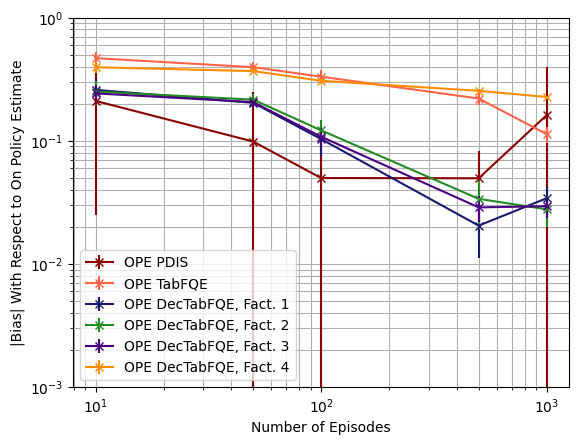

In [43]:
label = 'bias'
plot_graphs(bias_means, bias_stds, label, 10**-3, 10**0, shorter_D, estimator='DM')

OPE PDIS-----[0.21038808 0.09845371 0.04979866 0.04956478 0.16095716]
OPE DR-----[0.17708744 0.16814924 0.10982387 0.06117267 0.10569953]
OPE DecDR, Fact. 1-----[0.22368306 0.1118545  0.22523092 0.16297205 0.13688683]
OPE DecDR, Fact. 2-----[0.45122038 0.29743313 0.1206807  0.09954089 0.08136796]
OPE DecDR, Fact. 3-----[0.12489515 0.12078576 0.07994446 0.04313902 0.13205982]
OPE DecDR, Fact. 4-----[0.16775893 0.13210744 0.20690509 0.16582282 0.15755149]


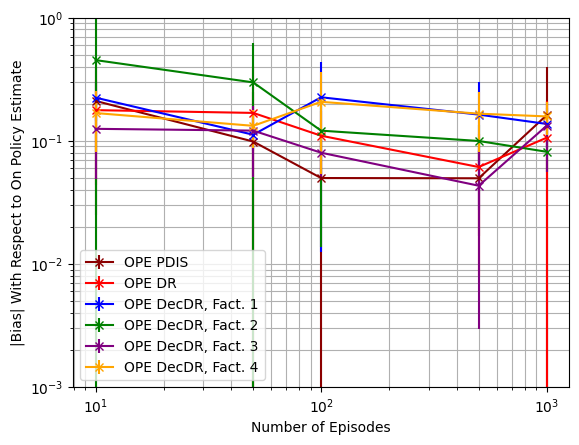

In [44]:
label = 'bias'
plot_graphs(bias_means, bias_stds, label, 10**-3, 10**0, shorter_D, estimator='DR')

##### Plot Variance

On Policy-----[0.02237518 0.01161249 0.00517436 0.00263435 0.00110857]
OPE PDIS-----[1.28867162 0.37977334 0.17311292 0.07200112 1.31013409]
OPE TabFQE-----[0.0628855  0.04735358 0.01859314 0.01173892 0.00734779]
OPE DecTabFQE, Fact. 1-----[0.03635077 0.01593626 0.00772011 0.0038526  0.00123355]
OPE DecTabFQE, Fact. 2-----[0.03424658 0.0177883  0.00819186 0.00327077 0.0014489 ]
OPE DecTabFQE, Fact. 3-----[0.04222803 0.01253109 0.00695015 0.00293599 0.00103884]
OPE DecTabFQE, Fact. 4-----[0.01170638 0.00459921 0.00194236 0.00103871 0.00031196]


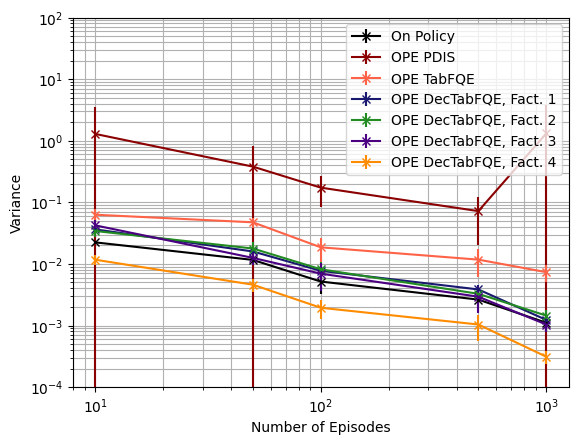

In [45]:
label = 'var'
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, estimator='DM')

On Policy-----[0.02237518 0.01161249 0.00517436 0.00263435 0.00110857]
OPE PDIS-----[1.28867162 0.37977334 0.17311292 0.07200112 1.31013409]
OPE DR-----[0.33363093 1.35778593 0.64165581 0.14298822 0.13677845]
OPE DecDR, Fact. 1-----[0.58136758 0.2202098  1.83286837 0.45911413 0.06782795]
OPE DecDR, Fact. 2-----[7.68236712 2.16707532 0.34351291 0.08299225 0.01454513]
OPE DecDR, Fact. 3-----[0.39602463 0.33675077 0.10802821 0.03837065 0.10089774]
OPE DecDR, Fact. 4-----[0.35517401 0.14952759 0.81199813 0.21804484 0.04962372]


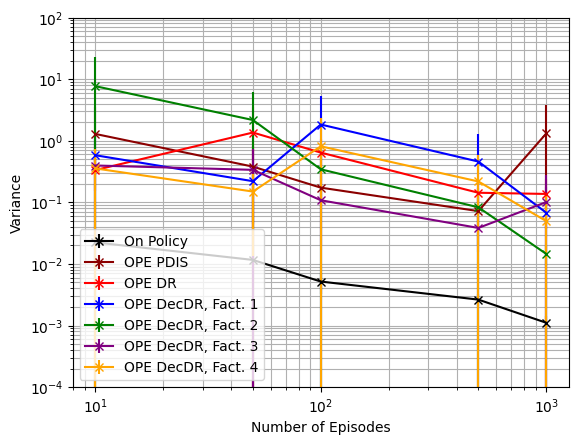

In [46]:
label = 'var'
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, estimator='DR')

##### Plot MSE

On Policy-----[0.02237518 0.01161249 0.00517436 0.00263435 0.00110857]
OPE PDIS-----[1.36740071 0.41132889 0.18073808 0.07552517 1.38995026]
OPE TabFQE-----[0.28528992 0.20544736 0.12982547 0.0608525  0.02046671]
OPE DecTabFQE, Fact. 1-----[0.10651082 0.05738161 0.01914952 0.00435689 0.00246404]
OPE DecTabFQE, Fact. 2-----[0.09997808 0.06476794 0.02358032 0.00462609 0.0022814 ]
OPE DecTabFQE, Fact. 3-----[0.10267212 0.05519355 0.01889755 0.00381379 0.0019359 ]
OPE DecTabFQE, Fact. 4-----[0.16913605 0.13984792 0.09631504 0.06557786 0.05168864]


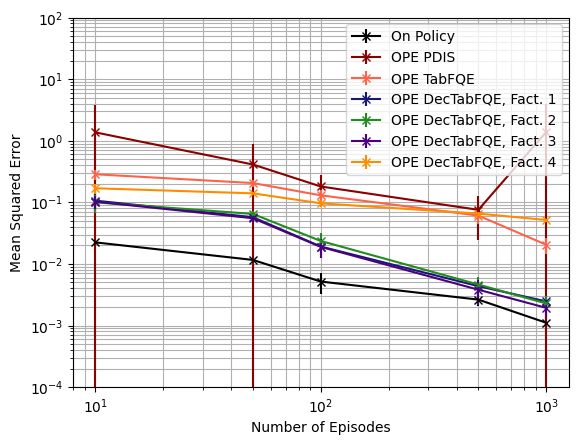

In [47]:
label = 'MSE'
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, estimator='DM')

On Policy-----[0.02237518 0.01161249 0.00517436 0.00263435 0.00110857]
OPE PDIS-----[1.36740071 0.41132889 0.18073808 0.07552517 1.38995026]
OPE DR-----[0.38268503 1.44339251 0.65788573 0.14955909 0.15914474]
OPE DecDR, Fact. 1-----[0.63747123 0.23355953 1.92881508 0.50399118 0.08896505]
OPE DecDR, Fact. 2-----[8.35609088 2.36340423 0.36950554 0.09415418 0.02181199]
OPE DecDR, Fact. 3-----[0.41742012 0.35620592 0.11530766 0.04184474 0.12411688]
OPE DecDR, Fact. 4-----[0.39095757 0.16899031 0.87820991 0.25269619 0.07664664]


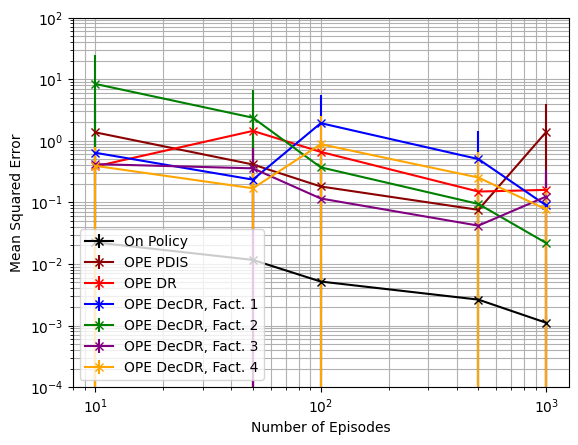

In [48]:
label = 'MSE'
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, estimator='DR')

##### Plot ESS

On Policy-----[ 10.  20.  50. 100. 200.]
OPE PDIS-----[1.39225442 1.55617947 2.21722233 4.83691683 3.89332027]
OPE TabFQE-----[ 3.86902492  5.0008303  14.66357665 27.4365513  34.99178722]
OPE DecTabFQE, Fact. 1-----[  6.52754803  15.72623923  33.21644527  71.0094298  189.17033806]
OPE DecTabFQE, Fact. 2-----[  6.87765983  14.97989753  35.44395391  83.36679443 159.10243533]
OPE DecTabFQE, Fact. 3-----[  5.52552291  18.98697396  43.09554015 121.31679216 221.9525766 ]
OPE DecTabFQE, Fact. 4-----[ 19.79996313  52.35992818 143.65025236 305.17247064 781.5577806 ]


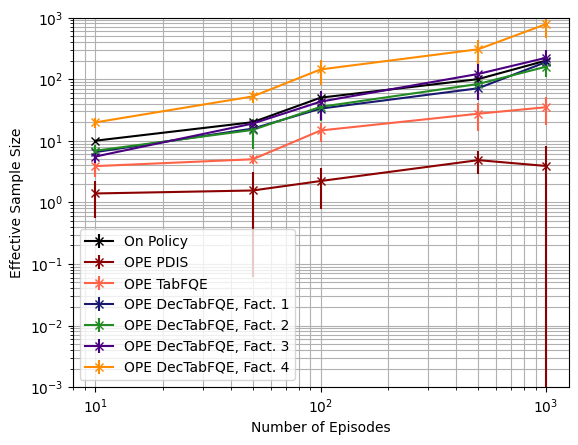

In [49]:
label = 'ESS'
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, estimator='DM')

On Policy-----[ 10.  20.  50. 100. 200.]
OPE PDIS-----[1.39225442 1.55617947 2.21722233 4.83691683 3.89332027]
OPE DR-----[0.84290923 0.9862084  0.96016763 2.25485903 3.45668277]
OPE DecDR, Fact. 1-----[ 1.69155221  1.62587436  2.69762977  8.70324828 19.6872753 ]
OPE DecDR, Fact. 2-----[ 1.76563458  1.15126067  4.79168866  9.8822062  21.29858147]
OPE DecDR, Fact. 3-----[ 0.64035784  1.8256607   3.6560471   9.99723986 17.57060049]
OPE DecDR, Fact. 4-----[ 1.65699919  2.3450305   6.48059125 15.52613566 23.91413219]


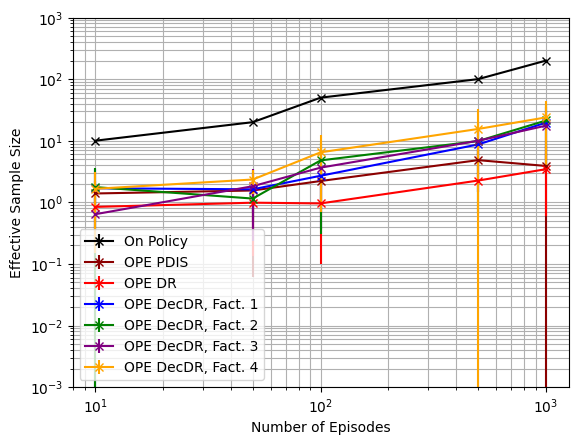

In [50]:
label = 'ESS'
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, estimator='DR')

### Varying Episodes $\epsilon_{e} = 0.6$ (Policy Divergence $3.2^{20}$)

Set up evaluation policy, generate data and convert into factored format

In [ ]:
EVAL_EPSILON = 0.6

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
# Calculate policy divergence from Voloshin et al.
D = 0
for state in range(randPol.shape[0] - 1):
    for action in range(randPol.shape[1] - 1):
        difference = evalPolSoft[state, action]/randPol[state, action]
        D = max(D, difference)
print(D)
shorter_D = round(D,2)

3.2


In [ ]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=evalPolSoft, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_e = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_e.shape

(100000, 20, 5)

In [ ]:
f_tr_e1, f_tr_e2, f_tr_e3, f_tr_e4 = factorise_dataset(nf_tr_e)

In [ ]:
factored_evalPolSoft1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4 = factor_policy_4(evalPolSoft)

In [ ]:
pad_evalPolSoft = pad_policy(evalPolSoft)

pad_factored_evalPolSoft1 = [None, None]
pad_factored_evalPolSoft1[0] = pad_policy(factored_evalPolSoft1[0])
pad_factored_evalPolSoft1[1] = pad_policy(factored_evalPolSoft1[1])

pad_factored_evalPolSoft2 = [None, None]
pad_factored_evalPolSoft2[0] = pad_policy(factored_evalPolSoft2[0])
pad_factored_evalPolSoft2[1] = pad_policy(factored_evalPolSoft2[1])

pad_factored_evalPolSoft3 = [None, None]
pad_factored_evalPolSoft3[0] = pad_policy(factored_evalPolSoft3[0])
pad_factored_evalPolSoft3[1] = pad_policy(factored_evalPolSoft3[1])

pad_factored_evalPolSoft4 = [None, None, None]
pad_factored_evalPolSoft4[0] = pad_policy(factored_evalPolSoft4[0])
pad_factored_evalPolSoft4[1] = pad_policy(factored_evalPolSoft4[1])
pad_factored_evalPolSoft4[2] = pad_policy(factored_evalPolSoft4[2])

In [ ]:
import policy_estimators as pe
import gc

def evaluate_PE(RUNS, EPISODES, SHORTER_D, STEPS=NSTEPS):

  biases = np.zeros((5, 13))
  variances = np.zeros((5, 13))
  MSEs = np.zeros((5, 13))
  ESSs = np.zeros((5, 13))

  # Reshape data for processing
  T, ldim = nf_tr_b.shape[-2], nf_tr_b.shape[-1]
  nfb = nf_tr_b.reshape((-1, RUNS, EPISODES, T, ldim))
  nfe = nf_tr_e.reshape((-1, RUNS, EPISODES, T, ldim))

  T, D1, ldim = f_tr_b1.shape[-3], f_tr_b1.shape[-2], f_tr_b1.shape[-1]
  fb1 = f_tr_b1.reshape((-1, RUNS, EPISODES, T, D1, ldim))
  fe1 = f_tr_e1.reshape((-1, RUNS, EPISODES, T, D1, ldim))

  T, D2, ldim = f_tr_b2.shape[-3], f_tr_b2.shape[-2], f_tr_b2.shape[-1]
  fb2 = f_tr_b2.reshape((-1, RUNS, EPISODES, T, D2, ldim))
  fe2 = f_tr_e2.reshape((-1, RUNS, EPISODES, T, D2, ldim))

  T, D3, ldim = f_tr_b3.shape[-3], f_tr_b3.shape[-2], f_tr_b3.shape[-1]
  fb3 = f_tr_b3.reshape((-1, RUNS, EPISODES, T, D3, ldim))
  fe3 = f_tr_e3.reshape((-1, RUNS, EPISODES, T, D3, ldim))

  T, D4, ldim = f_tr_b4.shape[-3], f_tr_b4.shape[-2], f_tr_b4.shape[-1]
  fb4 = f_tr_b4.reshape((-1, RUNS, EPISODES, T, D4, ldim))
  fe4 = f_tr_e4.reshape((-1, RUNS, EPISODES, T, D4, ldim))

  for t in range(5):
    print()

    lower_index = 0
    estimates_on_policy = np.zeros(RUNS)
    estimates_OPE_IS = np.zeros(RUNS)
    estimates_OPE_PDIS = np.zeros(RUNS)
    estimates_OPE_TabFQE = np.zeros(RUNS)
    estimates_OPE_DR = np.zeros(RUNS)

    estimates_OPE_DecTabFQE1 = np.zeros(RUNS)
    estimates_OPE_DecDR1 = np.zeros(RUNS)

    estimates_OPE_DecTabFQE2 = np.zeros(RUNS)
    estimates_OPE_DecDR2 = np.zeros(RUNS)

    estimates_OPE_DecTabFQE3 = np.zeros(RUNS)
    estimates_OPE_DecDR3 = np.zeros(RUNS)

    estimates_OPE_DecTabFQE4 = np.zeros(RUNS)
    estimates_OPE_DecDR4 = np.zeros(RUNS)

    for r in range(RUNS):
        #On policy Q estimate
        estimates_on_policy[r] = pe.on_policy_Q_estimate(nfe[t, r, :, :STEPS, :], DISCOUNT_Pol)
        #Off policy IS estimate
        estimates_OPE_IS[r] = pe.off_policy_IS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, pad_randPol, pad_evalPolSoft)
        #Off policy PDIS estimate
        estimates_OPE_PDIS[r] = pe.off_policy_PDIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, pad_randPol, pad_evalPolSoft)

        #Off policy tabular FQE
        Q, V = tabular_FQE(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, evalPolSoft, 20, 1440, 8)
        estimates_OPE_TabFQE[r] = V[136]
        #Off policy DR
        estimates_OPE_DR[r] = off_policy_DR_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft, 20, 0.5, 1440, 8)

        #Factorisation 1----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_evalPolSoft1, 20, [1440,1440], [2,4])
        for d in range(2):
          estimates_OPE_DecTabFQE1[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR1[r], _ = off_policy_DecDR_estimator(fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol1, factored_evalPolSoft1, 20, 0.5, [1440,1440], [2,4])

        #Factorisation 2----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_evalPolSoft2, 20, [1440,1440], [2,4])
        for d in range(2):
          estimates_OPE_DecTabFQE2[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR2[r], _ = off_policy_DecDR_estimator(fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol2, factored_evalPolSoft2, 20, 0.5, [1440,1440], [2,4])

        #Factorisation 3----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_evalPolSoft3, 20, [1440,1440], [2,4])
        for d in range(2):
          estimates_OPE_DecTabFQE3[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR3[r], _ = off_policy_DecDR_estimator(fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol3, factored_evalPolSoft3, 20, 0.5, [1440,1440], [2,4])

        #Factorisation 4----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_evalPolSoft4, 20, [1440,1440,1440], [2,2,2])
        for d in range(2):
          estimates_OPE_DecTabFQE4[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR4[r], _ = off_policy_DecDR_estimator(fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_randPol4, factored_evalPolSoft4, 20, 0.5, [1440,1440,1440], [2,2,2])

    mean_on_policy = np.mean(estimates_on_policy)
    var_on_policy = np.var(estimates_on_policy, ddof=0)
    print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

    from sklearn.metrics import mean_squared_error

    #For on policy
    biases[t, 0] = 0.0
    variances[t, 0] = var_on_policy
    MSEs[t, 0] = var_on_policy
    ESSs[t, 0] = EPISODES

    def generate_results(estimates, mean_true, label):
      MSE = mean_squared_error(estimates, [mean_true]*RUNS)
      mean = np.mean(estimates)
      var = np.var(estimates, ddof=0)
      bias1 = np.sqrt(MSE - var)
      bias2 = abs(mean - mean_true)
      print(f'Mean {label} estimate: {mean}. Bias1: {bias1}. Bias2: {bias2}. Variance: {var}. MSE: {MSE}')
      return bias1, var, MSE

    label_list = ['OPE IS', 'OPE PDIS', 'OPE TabFQE', 'OPE DR',
                  'OPE DecTabFQE: Fact. 1', 'OPE DecDR: Fact. 1',
                  'OPE DecTabFQE: Fact. 2', 'OPE DecDR: Fact. 2',
                  'OPE DecTabFQE: Fact. 3', 'OPE DecDR: Fact. 3',
                  'OPE DecTabFQE: Fact. 4', 'OPE DecDR: Fact. 4'
                  ]

    estimates = [estimates_OPE_IS, estimates_OPE_PDIS, estimates_OPE_TabFQE, estimates_OPE_DR,
                estimates_OPE_DecTabFQE1, estimates_OPE_DecDR1,
                estimates_OPE_DecTabFQE2, estimates_OPE_DecDR2,
                estimates_OPE_DecTabFQE3, estimates_OPE_DecDR3,
                estimates_OPE_DecTabFQE4, estimates_OPE_DecDR4
                ]

    for (id, val) in enumerate(label_list):
      biases[t, 1+id], variances[t, 1+id], MSEs[t, 1+id] = generate_results(estimates[id], mean_on_policy, label_list[id])
      ESSs[t, 1+id] = (EPISODES*variances[t, 0])/variances[t, 1+id]
      gc.collect()

  return np.mean(biases, axis=0), np.std(biases, axis=0), np.mean(variances, axis=0), np.std(variances, axis=0), np.mean(MSEs, axis=0), np.std(MSEs, axis=0), np.mean(ESSs, axis=0), np.std(ESSs, axis=0)

#### Run Everything

In [ ]:
EPISODES = [10, 20, 50, 100, 200]

bias_means = np.zeros((len(EPISODES), 13))
bias_stds = np.zeros((len(EPISODES), 13))
var_means = np.zeros((len(EPISODES), 13))
var_stds = np.zeros((len(EPISODES), 13))
MSE_means = np.zeros((len(EPISODES), 13))
MSE_stds = np.zeros((len(EPISODES), 13))
ESS_means = np.zeros((len(EPISODES), 13))
ESS_stds = np.zeros((len(EPISODES), 13))

RUNS = 20

for id in range(len(EPISODES)):
  e = EPISODES[id]
  print(f'{e} Episodes, {RUNS} ----------------------------------')
  bias_means[id, :], bias_stds[id, :], var_means[id, :], var_stds[id, :], MSE_means[id, :], MSE_stds[id, :], ESS_means[id, :], ESS_stds[id, :] = evaluate_PE(RUNS=RUNS, EPISODES=e, SHORTER_D=shorter_D)
  print()
  gc.collect()

print('BIAS MEANS')
print(list(bias_means))
print('\nBIAS STDS')
print(list(bias_stds))
print('\nVAR MEANS')
print(list(var_means))
print('\nVAR STDS')
print(list(var_stds))
print('\nMSE MEANS')
print(list(MSE_means))
print('\nMSE STDS')
print(list(MSE_stds))
print('\nESS MEANS')
print(list(ESS_means))
print('\nESS STDS')
print(list(ESS_stds))

10 Episodes, 20 ----------------------------------

Mean on policy Q estimate: -0.8794326881902761. Variance of on policy Q estimate: 0.008848227712566154
Mean OPE IS estimate: -0.7647220624140494. Bias1: 0.11471062577622672. Bias2: 0.1147106257762267. Variance: 0.025779822038478943. MSE: 0.03893834970445247
Mean OPE PDIS estimate: -0.7647220624140494. Bias1: 0.11471062577622672. Bias2: 0.1147106257762267. Variance: 0.025779822038478943. MSE: 0.03893834970445247
Mean OPE TabFQE estimate: -0.26408650724023813. Bias1: 0.615346180950038. Bias2: 0.615346180950038. Variance: 0.03491191742986778. MSE: 0.4135628398396647
Mean OPE DR estimate: -0.76301261975493. Bias1: 0.11642006843534604. Bias2: 0.11642006843534614. Variance: 0.10726754195949906. MSE: 0.12082117429398971
Mean OPE DecTabFQE: Fact. 1 estimate: -0.4811502598424213. Bias1: 0.39828242834785477. Bias2: 0.39828242834785477. Variance: 0.026602487134891613. MSE: 0.18523137986555568
Mean OPE DecDR: Fact. 1 estimate: -0.736597396511708.

#### Plot Graphs

##### Plot Bias

OPE PDIS-----[0.10019315 0.05789673 0.03130794 0.02361456 0.06323671]
OPE TabFQE-----[0.58867058 0.53417036 0.44657431 0.34807554 0.2277854 ]
OPE DecTabFQE, Fact. 1-----[0.39133636 0.33449005 0.21349836 0.13293784 0.06550694]
OPE DecTabFQE, Fact. 2-----[0.3726074  0.33008591 0.22333592 0.13768882 0.06612241]
OPE DecTabFQE, Fact. 3-----[0.35823032 0.32517474 0.21730371 0.14035648 0.07321495]
OPE DecTabFQE, Fact. 4-----[0.51571077 0.47555072 0.40267525 0.35763842 0.32375811]


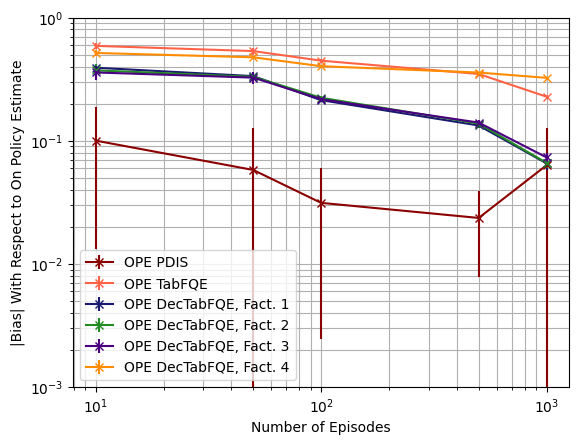

In [ ]:
label = 'bias'
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, estimator='DM')

OPE PDIS-----[0.10019315 0.05789673 0.03130794 0.02361456 0.06323671]
OPE DR-----[0.12384084 0.09492186 0.02096187 0.03892715 0.04653173]
OPE DecDR, Fact. 1-----[0.1307347  0.02549259 0.05745743 0.04320434 0.03628837]
OPE DecDR, Fact. 2-----[0.18236182 0.10276738 0.03991872 0.0314553  0.02573459]
OPE DecDR, Fact. 3-----[0.0726787  0.05018738 0.0380685  0.02341024 0.04513814]
OPE DecDR, Fact. 4-----[0.07400615 0.03886542 0.06024641 0.03765191 0.04386322]


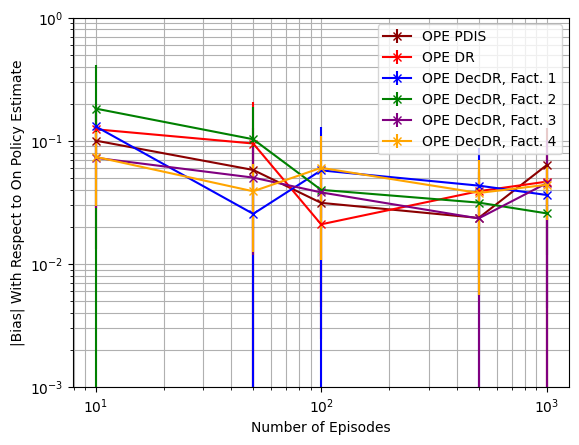

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, estimator='DR')

##### Plot Variance

On Policy-----[0.0097292  0.00450203 0.00172478 0.00090144 0.00055541]
OPE PDIS-----[0.33750922 0.09356309 0.03494886 0.02023639 0.11843792]
OPE TabFQE-----[0.03514267 0.02343507 0.00859075 0.00576243 0.00260583]
OPE DecTabFQE, Fact. 1-----[0.02769903 0.01099331 0.00548835 0.00219011 0.00077482]
OPE DecTabFQE, Fact. 2-----[0.02815545 0.01019489 0.00536543 0.00182509 0.00077105]
OPE DecTabFQE, Fact. 3-----[0.03161164 0.00871131 0.00388569 0.00182455 0.00072018]
OPE DecTabFQE, Fact. 4-----[0.01092261 0.00386173 0.00152433 0.00078772 0.00024471]


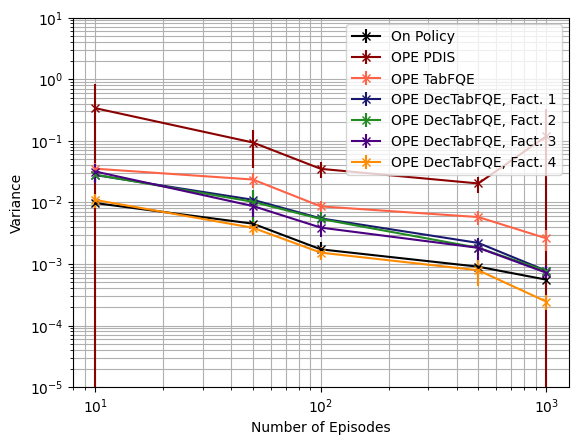

In [ ]:
label = 'var'
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, estimator='DM')

On Policy-----[0.0097292  0.00450203 0.00172478 0.00090144 0.00055541]
OPE PDIS-----[0.33750922 0.09356309 0.03494886 0.02023639 0.11843792]
OPE DR-----[0.26838579 0.30761754 0.12193673 0.0422803  0.02904593]
OPE DecDR, Fact. 1-----[0.17875826 0.08849712 0.20452076 0.05755249 0.01440788]
OPE DecDR, Fact. 2-----[0.78748001 0.25460244 0.04492642 0.0331608  0.00649268]
OPE DecDR, Fact. 3-----[0.23365056 0.14934832 0.03881245 0.01847837 0.07497977]
OPE DecDR, Fact. 4-----[0.13740077 0.06216361 0.09195112 0.03982949 0.00649073]


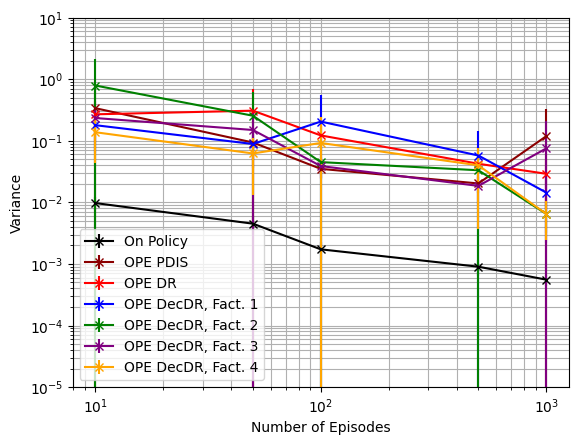

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, estimator='DR')

##### Plot MSE

On Policy-----[0.0097292  0.00450203 0.00172478 0.00090144 0.00055541]
OPE PDIS-----[0.35512445 0.10150796 0.03676267 0.02104346 0.12656674]
OPE TabFQE-----[0.3826377  0.30987422 0.20820324 0.12715797 0.05457941]
OPE DecTabFQE, Fact. 1-----[0.1818045  0.12303696 0.05110224 0.01991209 0.00512467]
OPE DecTabFQE, Fact. 2-----[0.16886909 0.11949709 0.05533413 0.02089254 0.00517974]
OPE DecTabFQE, Fact. 3-----[0.16191546 0.11561187 0.05119812 0.02159148 0.00611617]
OPE DecTabFQE, Fact. 4-----[0.27772592 0.23019585 0.16373806 0.12872278 0.10509395]


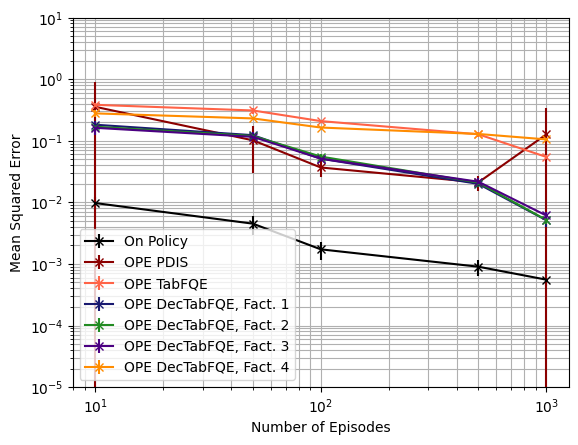

In [ ]:
label = 'MSE'
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, estimator='DM')

On Policy-----[0.0097292  0.00450203 0.00172478 0.00090144 0.00055541]
OPE PDIS-----[0.35512445 0.10150796 0.03676267 0.02104346 0.12656674]
OPE DR-----[0.28906259 0.32888516 0.12264739 0.04406234 0.0340867 ]
OPE DecDR, Fact. 1-----[0.1976397  0.08979102 0.21280332 0.06134055 0.0167429 ]
OPE DecDR, Fact. 2-----[0.87357909 0.27221322 0.04736475 0.03482524 0.0073499 ]
OPE DecDR, Fact. 3-----[0.24091279 0.15334053 0.04047195 0.01955638 0.0801455 ]
OPE DecDR, Fact. 4-----[0.14483845 0.06437287 0.098034   0.04227397 0.00885479]


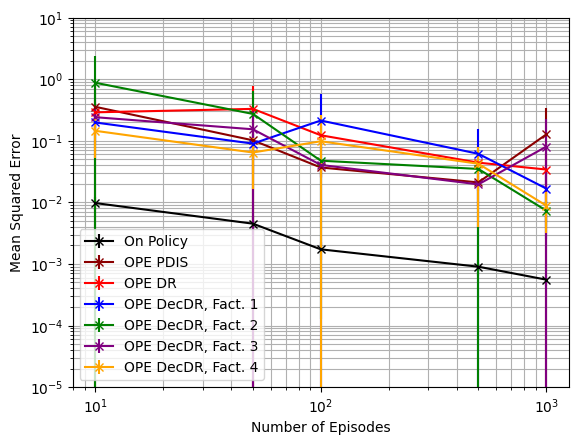

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, estimator='DR')

##### Plot ESS

On Policy-----[ 10.  20.  50. 100. 200.]
OPE PDIS-----[1.43294303 1.28762171 2.60820643 4.98794505 5.79819508]
OPE TabFQE-----[ 3.18476141  4.02136782 10.24931218 16.45424559 47.80869884]
OPE DecTabFQE, Fact. 1-----[  3.72072      9.95698763  15.61117023  43.6267114  152.60753961]
OPE DecTabFQE, Fact. 2-----[  3.71649134   9.85736974  18.07437502  65.83319528 144.57013206]
OPE DecTabFQE, Fact. 3-----[  3.649622    12.52215177  24.34471496  54.98510148 159.34670877]
OPE DecTabFQE, Fact. 4-----[  9.70939034  26.60625949  56.64096566 149.86904349 498.96376448]


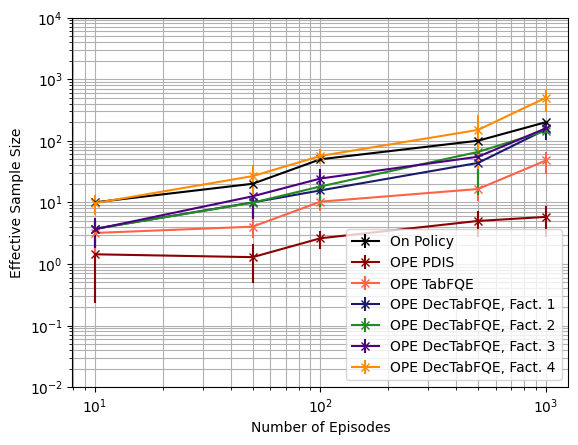

In [ ]:
label = 'ESS'
plot_graphs(ESS_means, ESS_stds, label, 10**(-2), 10**4, shorter_D, estimator='DM')

On Policy-----[ 10.  20.  50. 100. 200.]
OPE PDIS-----[1.43294303 1.28762171 2.60820643 4.98794505 5.79819508]
OPE DR-----[0.54622948 0.80222718 0.81248067 2.18874092 6.338144  ]
OPE DecDR, Fact. 1-----[ 1.15424612  1.23044754  2.14903031  7.24584364 12.17293493]
OPE DecDR, Fact. 2-----[ 1.35407181  1.00300008  3.42555327  6.58704772 24.66640485]
OPE DecDR, Fact. 3-----[ 0.46194475  1.51569086  2.2830181   6.11208043 19.14550542]
OPE DecDR, Fact. 4-----[ 1.32587783  2.08357282  3.87560686  5.2660129  24.20439122]


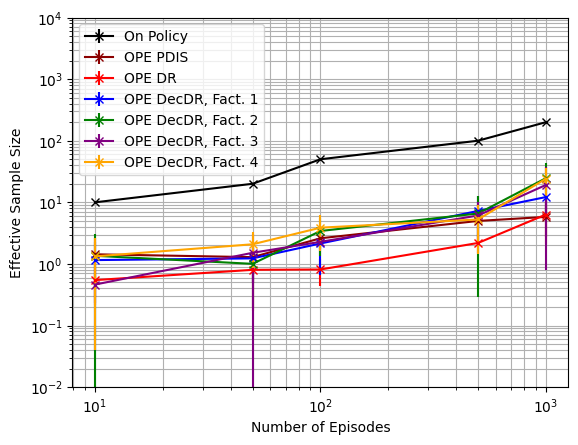

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-2), 10**4, shorter_D, estimator='DR')

### Varying Episodes $\epsilon_{e} = 0.8$ (Policy Divergence $1.6^{20}$)



Set up evaluation policy, generate data and convert into factored format

In [ ]:
EVAL_EPSILON = 0.8

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
# Calculate policy divergence from Voloshin et al.
D = 0
for state in range(randPol.shape[0] - 1):
    for action in range(randPol.shape[1] - 1):
        difference = evalPolSoft[state, action]/randPol[state, action]
        D = max(D, difference)
print(D)
shorter_D = round(D,2)

1.5999999999999996


In [ ]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=evalPolSoft, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_e = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_e.shape

(100000, 20, 5)

In [ ]:
f_tr_e1, f_tr_e2, f_tr_e3, f_tr_e4 = factorise_dataset(nf_tr_e)

In [ ]:
factored_evalPolSoft1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4 = factor_policy_4(evalPolSoft)

In [ ]:
pad_evalPolSoft = pad_policy(evalPolSoft)

pad_factored_evalPolSoft1 = [None, None]
pad_factored_evalPolSoft1[0] = pad_policy(factored_evalPolSoft1[0])
pad_factored_evalPolSoft1[1] = pad_policy(factored_evalPolSoft1[1])

pad_factored_evalPolSoft2 = [None, None]
pad_factored_evalPolSoft2[0] = pad_policy(factored_evalPolSoft2[0])
pad_factored_evalPolSoft2[1] = pad_policy(factored_evalPolSoft2[1])

pad_factored_evalPolSoft3 = [None, None]
pad_factored_evalPolSoft3[0] = pad_policy(factored_evalPolSoft3[0])
pad_factored_evalPolSoft3[1] = pad_policy(factored_evalPolSoft3[1])

pad_factored_evalPolSoft4 = [None, None, None]
pad_factored_evalPolSoft4[0] = pad_policy(factored_evalPolSoft4[0])
pad_factored_evalPolSoft4[1] = pad_policy(factored_evalPolSoft4[1])
pad_factored_evalPolSoft4[2] = pad_policy(factored_evalPolSoft4[2])

In [ ]:
import policy_estimators as pe
import gc

def evaluate_PE(RUNS, EPISODES, SHORTER_D, STEPS=NSTEPS):

  biases = np.zeros((5, 13))
  variances = np.zeros((5, 13))
  MSEs = np.zeros((5, 13))
  ESSs = np.zeros((5, 13))

  # Reshape data for processing
  T, ldim = nf_tr_b.shape[-2], nf_tr_b.shape[-1]
  nfb = nf_tr_b.reshape((-1, RUNS, EPISODES, T, ldim))
  nfe = nf_tr_e.reshape((-1, RUNS, EPISODES, T, ldim))

  T, D1, ldim = f_tr_b1.shape[-3], f_tr_b1.shape[-2], f_tr_b1.shape[-1]
  fb1 = f_tr_b1.reshape((-1, RUNS, EPISODES, T, D1, ldim))
  fe1 = f_tr_e1.reshape((-1, RUNS, EPISODES, T, D1, ldim))

  T, D2, ldim = f_tr_b2.shape[-3], f_tr_b2.shape[-2], f_tr_b2.shape[-1]
  fb2 = f_tr_b2.reshape((-1, RUNS, EPISODES, T, D2, ldim))
  fe2 = f_tr_e2.reshape((-1, RUNS, EPISODES, T, D2, ldim))

  T, D3, ldim = f_tr_b3.shape[-3], f_tr_b3.shape[-2], f_tr_b3.shape[-1]
  fb3 = f_tr_b3.reshape((-1, RUNS, EPISODES, T, D3, ldim))
  fe3 = f_tr_e3.reshape((-1, RUNS, EPISODES, T, D3, ldim))

  T, D4, ldim = f_tr_b4.shape[-3], f_tr_b4.shape[-2], f_tr_b4.shape[-1]
  fb4 = f_tr_b4.reshape((-1, RUNS, EPISODES, T, D4, ldim))
  fe4 = f_tr_e4.reshape((-1, RUNS, EPISODES, T, D4, ldim))

  for t in range(5):
    print()

    lower_index = 0
    estimates_on_policy = np.zeros(RUNS)
    estimates_OPE_IS = np.zeros(RUNS)
    estimates_OPE_PDIS = np.zeros(RUNS)
    estimates_OPE_TabFQE = np.zeros(RUNS)
    estimates_OPE_DR = np.zeros(RUNS)

    estimates_OPE_DecTabFQE1 = np.zeros(RUNS)
    estimates_OPE_DecDR1 = np.zeros(RUNS)

    estimates_OPE_DecTabFQE2 = np.zeros(RUNS)
    estimates_OPE_DecDR2 = np.zeros(RUNS)

    estimates_OPE_DecTabFQE3 = np.zeros(RUNS)
    estimates_OPE_DecDR3 = np.zeros(RUNS)

    estimates_OPE_DecTabFQE4 = np.zeros(RUNS)
    estimates_OPE_DecDR4 = np.zeros(RUNS)

    for r in range(RUNS):
        #On policy Q estimate
        estimates_on_policy[r] = pe.on_policy_Q_estimate(nfe[t, r, :, :STEPS, :], DISCOUNT_Pol)
        #Off policy IS estimate
        estimates_OPE_IS[r] = pe.off_policy_IS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, pad_randPol, pad_evalPolSoft)
        #Off policy PDIS estimate
        estimates_OPE_PDIS[r] = pe.off_policy_PDIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, pad_randPol, pad_evalPolSoft)

        #Off policy tabular FQE
        Q, V = tabular_FQE(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, evalPolSoft, 20, 1440, 8)
        estimates_OPE_TabFQE[r] = V[136]
        #Off policy DR
        estimates_OPE_DR[r] = off_policy_DR_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft, 20, 0.5, 1440, 8)

        #Factorisation 1----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_evalPolSoft1, 20, [1440,1440], [2,4])
        for d in range(2):
          estimates_OPE_DecTabFQE1[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR1[r], _ = off_policy_DecDR_estimator(fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol1, factored_evalPolSoft1, 20, 0.5, [1440,1440], [2,4])

        #Factorisation 2----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_evalPolSoft2, 20, [1440,1440], [2,4])
        for d in range(2):
          estimates_OPE_DecTabFQE2[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR2[r], _ = off_policy_DecDR_estimator(fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol2, factored_evalPolSoft2, 20, 0.5, [1440,1440], [2,4])

        #Factorisation 3----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_evalPolSoft3, 20, [1440,1440], [2,4])
        for d in range(2):
          estimates_OPE_DecTabFQE3[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR3[r], _ = off_policy_DecDR_estimator(fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol3, factored_evalPolSoft3, 20, 0.5, [1440,1440], [2,4])

        #Factorisation 4----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_evalPolSoft4, 20, [1440,1440,1440], [2,2,2])
        for d in range(2):
          estimates_OPE_DecTabFQE4[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR4[r], _ = off_policy_DecDR_estimator(fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_randPol4, factored_evalPolSoft4, 20, 0.5, [1440,1440,1440], [2,2,2])

    mean_on_policy = np.mean(estimates_on_policy)
    var_on_policy = np.var(estimates_on_policy, ddof=0)
    print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

    from sklearn.metrics import mean_squared_error

    #For on policy
    biases[t, 0] = 0.0
    variances[t, 0] = var_on_policy
    MSEs[t, 0] = var_on_policy
    ESSs[t, 0] = EPISODES

    def generate_results(estimates, mean_true, label):
      MSE = mean_squared_error(estimates, [mean_true]*RUNS)
      mean = np.mean(estimates)
      var = np.var(estimates, ddof=0)
      bias1 = np.sqrt(MSE - var)
      bias2 = abs(mean - mean_true)
      print(f'Mean {label} estimate: {mean}. Bias1: {bias1}. Bias2: {bias2}. Variance: {var}. MSE: {MSE}')
      return bias1, var, MSE

    label_list = ['OPE IS', 'OPE PDIS', 'OPE TabFQE', 'OPE DR',
                  'OPE DecTabFQE: Fact. 1', 'OPE DecDR: Fact. 1',
                  'OPE DecTabFQE: Fact. 2', 'OPE DecDR: Fact. 2',
                  'OPE DecTabFQE: Fact. 3', 'OPE DecDR: Fact. 3',
                  'OPE DecTabFQE: Fact. 4', 'OPE DecDR: Fact. 4'
                  ]

    estimates = [estimates_OPE_IS, estimates_OPE_PDIS, estimates_OPE_TabFQE, estimates_OPE_DR,
                estimates_OPE_DecTabFQE1, estimates_OPE_DecDR1,
                estimates_OPE_DecTabFQE2, estimates_OPE_DecDR2,
                estimates_OPE_DecTabFQE3, estimates_OPE_DecDR3,
                estimates_OPE_DecTabFQE4, estimates_OPE_DecDR4
                ]

    for (id, val) in enumerate(label_list):
      biases[t, 1+id], variances[t, 1+id], MSEs[t, 1+id] = generate_results(estimates[id], mean_on_policy, label_list[id])
      ESSs[t, 1+id] = (EPISODES*variances[t, 0])/variances[t, 1+id]
      gc.collect()

  return np.mean(biases, axis=0), np.std(biases, axis=0), np.mean(variances, axis=0), np.std(variances, axis=0), np.mean(MSEs, axis=0), np.std(MSEs, axis=0), np.mean(ESSs, axis=0), np.std(ESSs, axis=0)

#### Run Everything

In [ ]:
EPISODES = [10, 20, 50, 100, 200]

bias_means = np.zeros((len(EPISODES), 13))
bias_stds = np.zeros((len(EPISODES), 13))
var_means = np.zeros((len(EPISODES), 13))
var_stds = np.zeros((len(EPISODES), 13))
MSE_means = np.zeros((len(EPISODES), 13))
MSE_stds = np.zeros((len(EPISODES), 13))
ESS_means = np.zeros((len(EPISODES), 13))
ESS_stds = np.zeros((len(EPISODES), 13))

RUNS = 20

for id in range(len(EPISODES)):
  e = EPISODES[id]
  print(f'{e} Episodes, {RUNS} ----------------------------------')
  bias_means[id, :], bias_stds[id, :], var_means[id, :], var_stds[id, :], MSE_means[id, :], MSE_stds[id, :], ESS_means[id, :], ESS_stds[id, :] = evaluate_PE(RUNS=RUNS, EPISODES=e, SHORTER_D=shorter_D)
  print()
  gc.collect()

print('BIAS MEANS')
print(list(bias_means))
print('\nBIAS STDS')
print(list(bias_stds))
print('\nVAR MEANS')
print(list(var_means))
print('\nVAR STDS')
print(list(var_stds))
print('\nMSE MEANS')
print(list(MSE_means))
print('\nMSE STDS')
print(list(MSE_stds))
print('\nESS MEANS')
print(list(ESS_means))
print('\nESS STDS')
print(list(ESS_stds))

10 Episodes, 20 ----------------------------------

Mean on policy Q estimate: -0.9457439038662411. Variance of on policy Q estimate: 0.003978863233407559
Mean OPE IS estimate: -0.9318861414106937. Bias1: 0.013857762455547578. Bias2: 0.013857762455547373. Variance: 0.00694967768782836. MSE: 0.007141715268102744
Mean OPE PDIS estimate: -0.9318861414106937. Bias1: 0.013857762455547578. Bias2: 0.013857762455547373. Variance: 0.00694967768782836. MSE: 0.007141715268102744
Mean OPE TabFQE estimate: -0.24795483333333337. Bias1: 0.6977890705329077. Bias2: 0.6977890705329077. Variance: 0.023546339248056127. MSE: 0.5104559262032354
Mean OPE DR estimate: -0.9063752174643401. Bias1: 0.03936868640190088. Bias2: 0.03936868640190094. Variance: 0.06529540397651087. MSE: 0.06684529744552209
Mean OPE DecTabFQE: Fact. 1 estimate: -0.47133994075556007. Bias1: 0.4744039631106811. Bias2: 0.474403963110681. Variance: 0.016228634826275505. MSE: 0.24128775504139602
Mean OPE DecDR: Fact. 1 estimate: -0.8994988

#### Plot Graphs

##### Plot Bias

OPE PDIS-----[0.02291979 0.01055883 0.00741952 0.00519439 0.00599242]
OPE TabFQE-----[0.6551137  0.58478477 0.51352191 0.40719136 0.27868553]
OPE DecTabFQE, Fact. 1-----[0.42565359 0.38089676 0.2684292  0.18287324 0.11249165]
OPE DecTabFQE, Fact. 2-----[0.41861863 0.37409357 0.26872704 0.18399607 0.11216972]
OPE DecTabFQE, Fact. 3-----[0.42696664 0.37471683 0.27116778 0.1900282  0.11729811]
OPE DecTabFQE, Fact. 4-----[0.55007332 0.50712442 0.4412255  0.39567633 0.36461192]


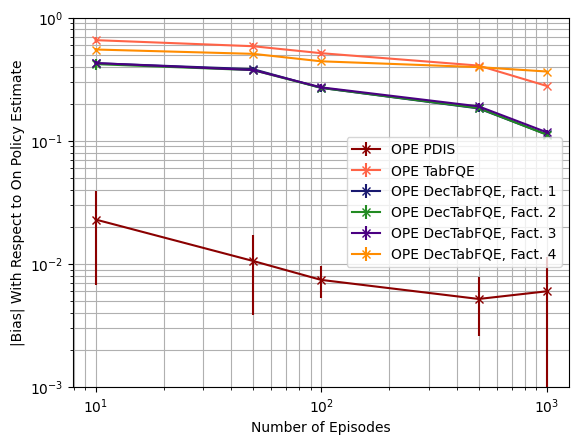

In [ ]:
label = 'bias'
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, estimator='DM')

OPE PDIS-----[0.02291979 0.01055883 0.00741952 0.00519439 0.00599242]
OPE DR-----[0.07930944 0.02061191 0.01419586 0.01929615 0.01383031]
OPE DecDR, Fact. 1-----[0.06320433 0.03343529 0.01993294 0.00594739 0.0088802 ]
OPE DecDR, Fact. 2-----[0.05386066 0.01292189 0.0180774  0.00355827 0.01071214]
OPE DecDR, Fact. 3-----[0.03156186 0.01915347 0.00919432 0.0076243  0.00964384]
OPE DecDR, Fact. 4-----[0.03868477 0.01942156 0.01723178 0.00564189 0.00678457]


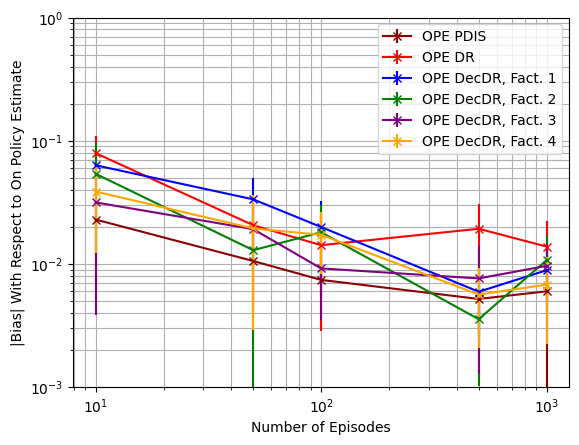

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, estimator='DR')

##### Plot Variance

On Policy-----[0.00660549 0.00278449 0.00081329 0.00038993 0.00019251]
OPE PDIS-----[0.01643139 0.00653152 0.0025855  0.00155109 0.00085344]
OPE TabFQE-----[0.01867263 0.01368632 0.00481222 0.00238196 0.00125303]
OPE DecTabFQE, Fact. 1-----[0.01566237 0.00643467 0.00339057 0.001184   0.00044749]
OPE DecTabFQE, Fact. 2-----[0.01901215 0.00892435 0.00316363 0.00121025 0.00038268]
OPE DecTabFQE, Fact. 3-----[0.01973957 0.00666678 0.00247238 0.00122907 0.00044912]
OPE DecTabFQE, Fact. 4-----[0.00821333 0.00312955 0.00111297 0.0005173  0.00016101]


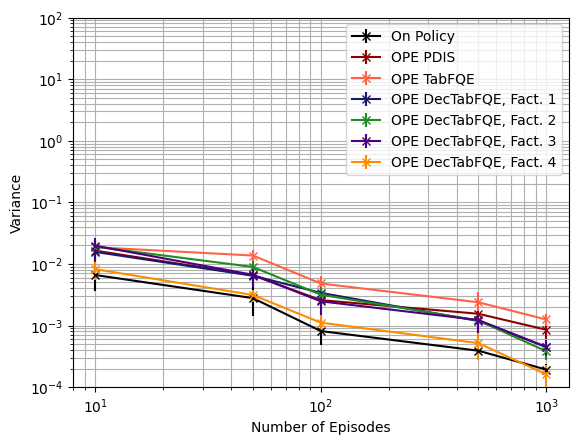

In [ ]:
label = 'var'
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, estimator='DM')

On Policy-----[0.00660549 0.00278449 0.00081329 0.00038993 0.00019251]
OPE PDIS-----[0.01643139 0.00653152 0.0025855  0.00155109 0.00085344]
OPE DR-----[0.06556967 0.03258378 0.01207806 0.00860214 0.00309874]
OPE DecDR, Fact. 1-----[0.03411261 0.01598881 0.00686806 0.0025257  0.00133072]
OPE DecDR, Fact. 2-----[0.03400913 0.01565371 0.00579637 0.00306084 0.0012181 ]
OPE DecDR, Fact. 3-----[0.04092699 0.01837019 0.00533386 0.00384861 0.00135791]
OPE DecDR, Fact. 4-----[0.02366159 0.01093823 0.0044696  0.00217451 0.00093775]


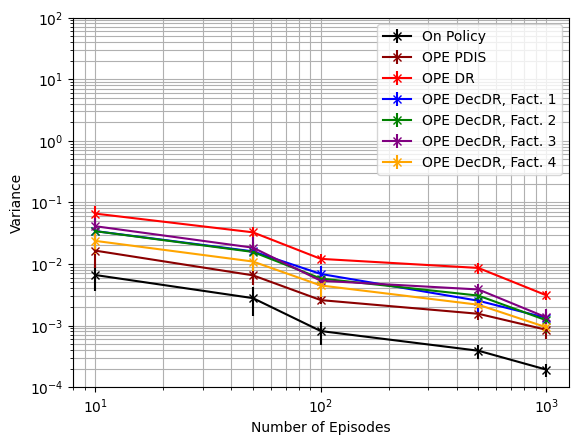

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, estimator='DR')

##### Plot MSE

On Policy-----[0.00660549 0.00278449 0.00081329 0.00038993 0.00019251]
OPE PDIS-----[0.01721897 0.00668807 0.00264529 0.00158471 0.00091798]
OPE TabFQE-----[0.44922198 0.35683645 0.26902867 0.16835601 0.07896749]
OPE DecTabFQE, Fact. 1-----[0.19807334 0.15167921 0.07579389 0.03474428 0.01312526]
OPE DecTabFQE, Fact. 2-----[0.19596563 0.14902285 0.07559966 0.03509361 0.01297857]
OPE DecTabFQE, Fact. 3-----[0.20232545 0.14724807 0.07630124 0.03747505 0.01422968]
OPE DecTabFQE, Fact. 4-----[0.31118076 0.26041251 0.1959116  0.15711358 0.1331205 ]


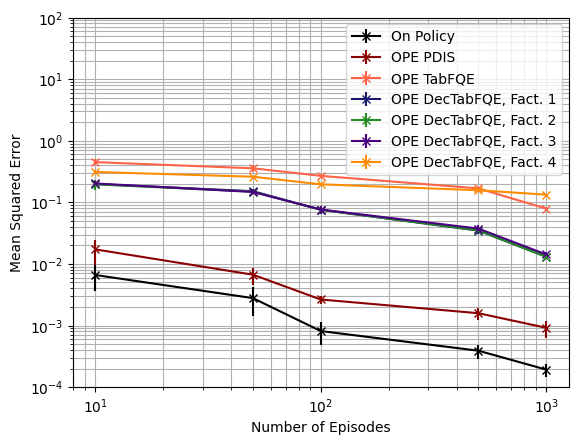

In [ ]:
label = 'MSE'
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, estimator='DM')

On Policy-----[0.00660549 0.00278449 0.00081329 0.00038993 0.00019251]
OPE PDIS-----[0.01721897 0.00668807 0.00264529 0.00158471 0.00091798]
OPE DR-----[0.07272474 0.03311925 0.01240875 0.00910605 0.00336208]
OPE DecDR, Fact. 1-----[0.03832101 0.01736961 0.00742837 0.00257362 0.00143249]
OPE DecDR, Fact. 2-----[0.03867274 0.01603813 0.00627302 0.0030799  0.00136948]
OPE DecDR, Fact. 3-----[0.04269222 0.01883713 0.00545045 0.00394694 0.00147373]
OPE DecDR, Fact. 4-----[0.02585928 0.01158806 0.00484699 0.00221917 0.00100441]


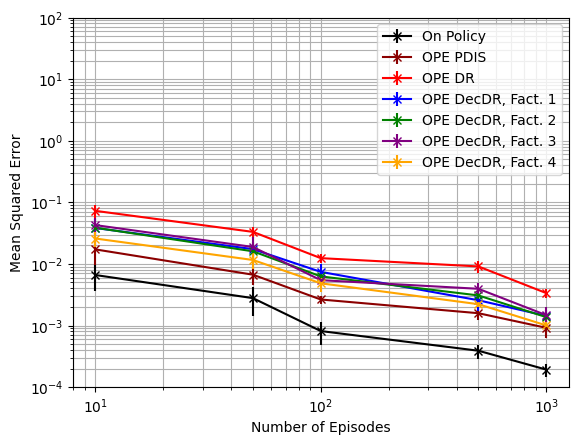

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, estimator='DR')

##### Plot ESS

On Policy-----[ 10.  20.  50. 100. 200.]
OPE PDIS-----[ 4.3882656   9.21649795 16.12250409 25.48812939 51.33762215]
OPE TabFQE-----[ 3.97300833  4.19677026  8.61220372 19.2768668  33.17190488]
OPE DecTabFQE, Fact. 1-----[ 5.18484981  8.86657754 12.06457427 36.27193069 93.15195081]
OPE DecTabFQE, Fact. 2-----[  4.06372601   6.40487018  14.46928573  32.55471752 109.83554988]
OPE DecTabFQE, Fact. 3-----[ 3.94282761  9.93875623 19.39807238 36.04532037 93.88073126]
OPE DecTabFQE, Fact. 4-----[  9.23632186  19.65378326  42.78182496  85.65028484 266.6338324 ]


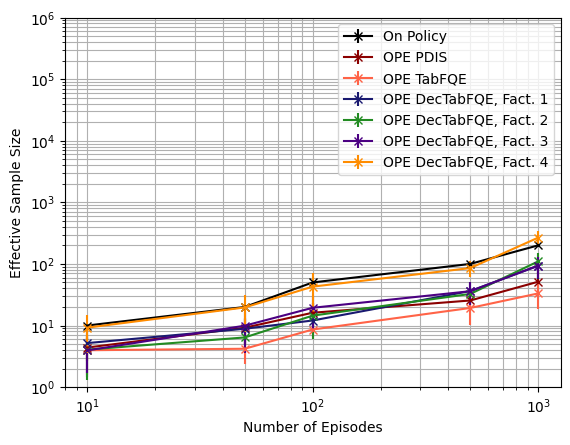

In [ ]:
label = 'ESS'
plot_graphs(ESS_means, ESS_stds, label, 10**(0), 10**6, shorter_D, estimator='DM')

On Policy-----[ 10.  20.  50. 100. 200.]
OPE PDIS-----[ 4.3882656   9.21649795 16.12250409 25.48812939 51.33762215]
OPE DR-----[ 1.19006968  1.65552155  3.68436155  4.67006431 13.07109436]
OPE DecDR, Fact. 1-----[ 3.27434336  3.40191081  6.42347098 16.99785994 30.28106098]
OPE DecDR, Fact. 2-----[ 2.01323861  3.90739608  7.03300496 14.1942072  34.31615985]
OPE DecDR, Fact. 3-----[ 2.66422513  3.81257245  7.57788898 10.45501455 31.62789716]
OPE DecDR, Fact. 4-----[ 3.57680786  5.32318593  9.26391599 18.19737005 42.06865333]


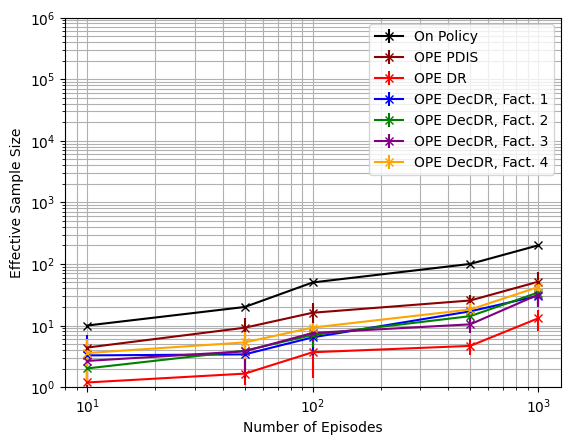

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(0), 10**6, shorter_D, estimator='DR')

### Varying Episode Length $T$ With $\epsilon_{e} = 0.8$ (Policy Divergence $1.6^{T}$)

Set up evaluation policy, generate data and convert into factored format

In [42]:
EVAL_EPSILON = 0.8

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [43]:
# Calculate policy divergence from Voloshin et al.
D = 0
for state in range(randPol.shape[0] - 1):
    for action in range(randPol.shape[1] - 1):
        difference = evalPolSoft[state, action]/randPol[state, action]
        D = max(D, difference)
print(D)
shorter_D = round(D,2)

1.5999999999999996


In [44]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=evalPolSoft, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

In [45]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_e = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_e.shape

(100000, 20, 5)

In [46]:
f_tr_e1, f_tr_e2, f_tr_e3, f_tr_e4 = factorise_dataset(nf_tr_e)

In [47]:
factored_evalPolSoft1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4 = factor_policy_4(evalPolSoft)

In [48]:
pad_evalPolSoft = pad_policy(evalPolSoft)

pad_factored_evalPolSoft1 = [None, None]
pad_factored_evalPolSoft1[0] = pad_policy(factored_evalPolSoft1[0])
pad_factored_evalPolSoft1[1] = pad_policy(factored_evalPolSoft1[1])

pad_factored_evalPolSoft2 = [None, None]
pad_factored_evalPolSoft2[0] = pad_policy(factored_evalPolSoft2[0])
pad_factored_evalPolSoft2[1] = pad_policy(factored_evalPolSoft2[1])

pad_factored_evalPolSoft3 = [None, None]
pad_factored_evalPolSoft3[0] = pad_policy(factored_evalPolSoft3[0])
pad_factored_evalPolSoft3[1] = pad_policy(factored_evalPolSoft3[1])

pad_factored_evalPolSoft4 = [None, None, None]
pad_factored_evalPolSoft4[0] = pad_policy(factored_evalPolSoft4[0])
pad_factored_evalPolSoft4[1] = pad_policy(factored_evalPolSoft4[1])
pad_factored_evalPolSoft4[2] = pad_policy(factored_evalPolSoft4[2])

In [49]:
import policy_estimators as pe
import gc

def evaluate_PE(RUNS, EPISODES, SHORTER_D, STEPS=NSTEPS):

  biases = np.zeros((5, 13))
  variances = np.zeros((5, 13))
  MSEs = np.zeros((5, 13))
  ESSs = np.zeros((5, 13))

  # Reshape data for processing
  T, ldim = nf_tr_b.shape[-2], nf_tr_b.shape[-1]
  nfb = nf_tr_b.reshape((-1, RUNS, EPISODES, T, ldim))
  nfe = nf_tr_e.reshape((-1, RUNS, EPISODES, T, ldim))

  T, D1, ldim = f_tr_b1.shape[-3], f_tr_b1.shape[-2], f_tr_b1.shape[-1]
  fb1 = f_tr_b1.reshape((-1, RUNS, EPISODES, T, D1, ldim))
  fe1 = f_tr_e1.reshape((-1, RUNS, EPISODES, T, D1, ldim))

  T, D2, ldim = f_tr_b2.shape[-3], f_tr_b2.shape[-2], f_tr_b2.shape[-1]
  fb2 = f_tr_b2.reshape((-1, RUNS, EPISODES, T, D2, ldim))
  fe2 = f_tr_e2.reshape((-1, RUNS, EPISODES, T, D2, ldim))

  T, D3, ldim = f_tr_b3.shape[-3], f_tr_b3.shape[-2], f_tr_b3.shape[-1]
  fb3 = f_tr_b3.reshape((-1, RUNS, EPISODES, T, D3, ldim))
  fe3 = f_tr_e3.reshape((-1, RUNS, EPISODES, T, D3, ldim))

  T, D4, ldim = f_tr_b4.shape[-3], f_tr_b4.shape[-2], f_tr_b4.shape[-1]
  fb4 = f_tr_b4.reshape((-1, RUNS, EPISODES, T, D4, ldim))
  fe4 = f_tr_e4.reshape((-1, RUNS, EPISODES, T, D4, ldim))

  for t in range(5):
    print()

    lower_index = 0
    estimates_on_policy = np.zeros(RUNS)
    estimates_OPE_IS = np.zeros(RUNS)
    estimates_OPE_PDIS = np.zeros(RUNS)
    estimates_OPE_TabFQE = np.zeros(RUNS)
    estimates_OPE_DR = np.zeros(RUNS)

    estimates_OPE_DecTabFQE1 = np.zeros(RUNS)
    estimates_OPE_DecDR1 = np.zeros(RUNS)

    estimates_OPE_DecTabFQE2 = np.zeros(RUNS)
    estimates_OPE_DecDR2 = np.zeros(RUNS)

    estimates_OPE_DecTabFQE3 = np.zeros(RUNS)
    estimates_OPE_DecDR3 = np.zeros(RUNS)

    estimates_OPE_DecTabFQE4 = np.zeros(RUNS)
    estimates_OPE_DecDR4 = np.zeros(RUNS)

    for r in range(RUNS):
        #On policy Q estimate
        estimates_on_policy[r] = pe.on_policy_Q_estimate(nfe[t, r, :, :STEPS, :], DISCOUNT_Pol)
        #Off policy IS estimate
        estimates_OPE_IS[r] = pe.off_policy_IS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, pad_randPol, pad_evalPolSoft)
        #Off policy PDIS estimate
        estimates_OPE_PDIS[r] = pe.off_policy_PDIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, pad_randPol, pad_evalPolSoft)

        #Off policy tabular FQE
        Q, V = tabular_FQE(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, evalPolSoft, 20, 1440, 8)
        estimates_OPE_TabFQE[r] = V[136]
        #Off policy DR
        estimates_OPE_DR[r] = off_policy_DR_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft, 20, 0.5, 1440, 8)

        #Factorisation 1----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_evalPolSoft1, 20, [1440,1440], [2,4])
        for d in range(2):
          estimates_OPE_DecTabFQE1[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR1[r], _ = off_policy_DecDR_estimator(fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol1, factored_evalPolSoft1, 20, 0.5, [1440,1440], [2,4])

        #Factorisation 2----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_evalPolSoft2, 20, [1440,1440], [2,4])
        for d in range(2):
          estimates_OPE_DecTabFQE2[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR2[r], _ = off_policy_DecDR_estimator(fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol2, factored_evalPolSoft2, 20, 0.5, [1440,1440], [2,4])

        #Factorisation 3----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_evalPolSoft3, 20, [1440,1440], [2,4])
        for d in range(2):
          estimates_OPE_DecTabFQE3[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR3[r], _ = off_policy_DecDR_estimator(fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol3, factored_evalPolSoft3, 20, 0.5, [1440,1440], [2,4])

        #Factorisation 4----------------------------------

        #Off policy decomposed IS estimate
        Q, V = tabular_DecFQE(fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_evalPolSoft4, 20, [1440,1440,1440], [2,2,2])
        for d in range(2):
          estimates_OPE_DecTabFQE4[r] += V[d][136]
        #Off policy decomposed PDIS estimate
        estimates_OPE_DecDR4[r], _ = off_policy_DecDR_estimator(fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_randPol4, factored_evalPolSoft4, 20, 0.5, [1440,1440,1440], [2,2,2])

    mean_on_policy = np.mean(estimates_on_policy)
    var_on_policy = np.var(estimates_on_policy, ddof=0)
    print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

    from sklearn.metrics import mean_squared_error

    #For on policy
    biases[t, 0] = 0.0
    variances[t, 0] = var_on_policy
    MSEs[t, 0] = var_on_policy
    ESSs[t, 0] = EPISODES

    def generate_results(estimates, mean_true, label):
      MSE = mean_squared_error(estimates, [mean_true]*RUNS)
      mean = np.mean(estimates)
      var = np.var(estimates, ddof=0)
      bias1 = np.sqrt(MSE - var)
      bias2 = abs(mean - mean_true)
      print(f'Mean {label} estimate: {mean}. Bias1: {bias1}. Bias2: {bias2}. Variance: {var}. MSE: {MSE}')
      return bias1, var, MSE

    label_list = ['OPE IS', 'OPE PDIS', 'OPE TabFQE', 'OPE DR',
                  'OPE DecTabFQE: Fact. 1', 'OPE DecDR: Fact. 1',
                  'OPE DecTabFQE: Fact. 2', 'OPE DecDR: Fact. 2',
                  'OPE DecTabFQE: Fact. 3', 'OPE DecDR: Fact. 3',
                  'OPE DecTabFQE: Fact. 4', 'OPE DecDR: Fact. 4'
                  ]

    estimates = [estimates_OPE_IS, estimates_OPE_PDIS, estimates_OPE_TabFQE, estimates_OPE_DR,
                estimates_OPE_DecTabFQE1, estimates_OPE_DecDR1,
                estimates_OPE_DecTabFQE2, estimates_OPE_DecDR2,
                estimates_OPE_DecTabFQE3, estimates_OPE_DecDR3,
                estimates_OPE_DecTabFQE4, estimates_OPE_DecDR4
                ]

    for (id, val) in enumerate(label_list):
      biases[t, 1+id], variances[t, 1+id], MSEs[t, 1+id] = generate_results(estimates[id], mean_on_policy, label_list[id])
      ESSs[t, 1+id] = (EPISODES*variances[t, 0])/variances[t, 1+id]
      gc.collect()

  return np.mean(biases, axis=0), np.std(biases, axis=0), np.mean(variances, axis=0), np.std(variances, axis=0), np.mean(MSEs, axis=0), np.std(MSEs, axis=0), np.mean(ESSs, axis=0), np.std(ESSs, axis=0)

#### Run Everything

In [50]:
LENGTHS = [1, 5, 10, 20]

bias_means = np.zeros((len(LENGTHS), 13))
bias_stds = np.zeros((len(LENGTHS), 13))
var_means = np.zeros((len(LENGTHS), 13))
var_stds = np.zeros((len(LENGTHS), 13))
MSE_means = np.zeros((len(LENGTHS), 13))
MSE_stds = np.zeros((len(LENGTHS), 13))
ESS_means = np.zeros((len(LENGTHS), 13))
ESS_stds = np.zeros((len(LENGTHS), 13))

RUNS = 20

for id in range(len(LENGTHS)):
  e = LENGTHS[id]
  print(f'{e} Steps, {RUNS} ----------------------------------')
  bias_means[id, :], bias_stds[id, :], var_means[id, :], var_stds[id, :], MSE_means[id, :], MSE_stds[id, :], ESS_means[id, :], ESS_stds[id, :] = evaluate_PE(RUNS=RUNS, EPISODES=100, STEPS=e, SHORTER_D=shorter_D)
  print()
  gc.collect()

print('BIAS MEANS')
print(list(bias_means))
print('\nBIAS STDS')
print(list(bias_stds))
print('\nVAR MEANS')
print(list(var_means))
print('\nVAR STDS')
print(list(var_stds))
print('\nMSE MEANS')
print(list(MSE_means))
print('\nMSE STDS')
print(list(MSE_stds))
print('\nESS MEANS')
print(list(ESS_means))
print('\nESS STDS')
print(list(ESS_stds))

1 Steps, 20 ----------------------------------

Mean on policy Q estimate: -0.25349999999999995. Variance of on policy Q estimate: 0.0023027499999999997
Mean OPE IS estimate: -0.2956571428571429. Bias1: 0.0421571428571429. Bias2: 0.04215714285714295. Variance: 0.0020497110204081618. MSE: 0.0038269357142857166
Mean OPE PDIS estimate: -0.2956571428571429. Bias1: 0.0421571428571429. Bias2: 0.04215714285714295. Variance: 0.0020497110204081618. MSE: 0.0038269357142857166
Mean OPE TabFQE estimate: -0.30876220731987536. Bias1: 0.05526220731987539. Bias2: 0.05526220731987541. Variance: 0.001610424872800673. MSE: 0.004664336430665562
Mean OPE DR estimate: -0.31040053727273154. Bias1: 0.05690053727273158. Bias2: 0.05690053727273159. Variance: 0.004034700571090737. MSE: 0.0072723717130162525
Mean OPE DecTabFQE: Fact. 1 estimate: -0.3015748022210986. Bias1: 0.04807480222109867. Bias2: 0.04807480222109867. Variance: 0.0014407366156022733. MSE: 0.0037519232242000265
Mean OPE DecDR: Fact. 1 estimate:

#### Plot Graphs

##### Plot Bias

OPE PDIS-----[0.02916571 0.01796973 0.00849725 0.00519439]
OPE TabFQE-----[0.03421061 0.31115937 0.38661821 0.40719136]
OPE DecTabFQE, Fact. 1-----[0.03381436 0.0829856  0.15666443 0.18287324]
OPE DecTabFQE, Fact. 2-----[0.04900492 0.08308874 0.15521127 0.18399607]
OPE DecTabFQE, Fact. 3-----[0.04059701 0.08691249 0.16426607 0.1900282 ]
OPE DecTabFQE, Fact. 4-----[0.06747658 0.28992437 0.36911997 0.39567633]


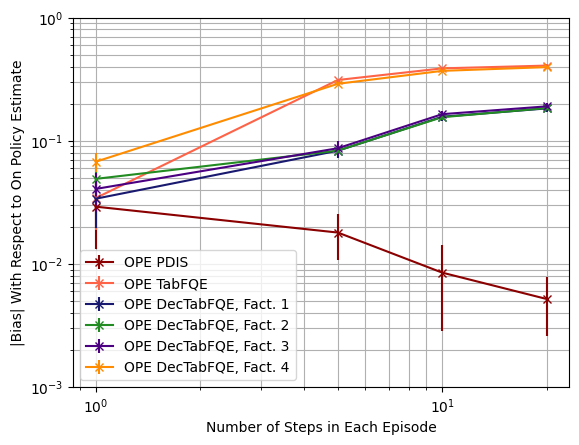

In [59]:
label = 'bias'
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, estimator='DM')

OPE PDIS-----[0.02916571 0.01796973 0.00849725 0.00519439]
OPE DR-----[0.03027019 0.00917364 0.01102334 0.01929615]
OPE DecDR, Fact. 1-----[0.02979719 0.02342713 0.01489336 0.00594739]
OPE DecDR, Fact. 2-----[0.0428123  0.02647198 0.00972573 0.00355827]
OPE DecDR, Fact. 3-----[0.03139721 0.01773445 0.00902144 0.0076243 ]
OPE DecDR, Fact. 4-----[0.03324084 0.02735052 0.01221142 0.00564189]


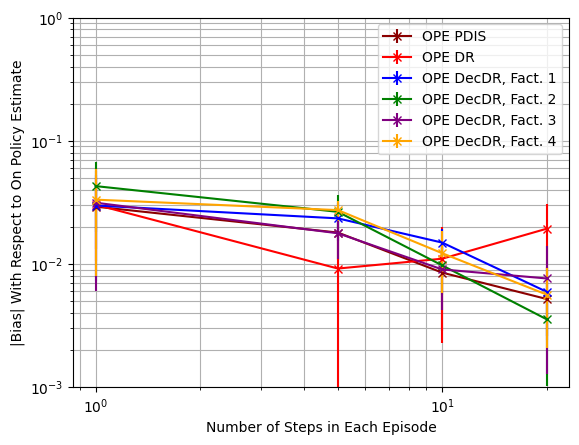

In [60]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, estimator='DR')

##### Plot Variance

On Policy-----[0.0016506  0.00143548 0.00058133 0.00038993]
OPE PDIS-----[0.00266957 0.00228655 0.00185276 0.00155109]
OPE TabFQE-----[0.00199828 0.00320522 0.00200879 0.00238196]
OPE DecTabFQE, Fact. 1-----[0.00205983 0.00139681 0.00127279 0.001184  ]
OPE DecTabFQE, Fact. 2-----[0.0022057  0.00127145 0.0011774  0.00121025]
OPE DecTabFQE, Fact. 3-----[0.00220591 0.00139494 0.00127292 0.00122907]
OPE DecTabFQE, Fact. 4-----[0.00108488 0.00061907 0.00057088 0.0005173 ]


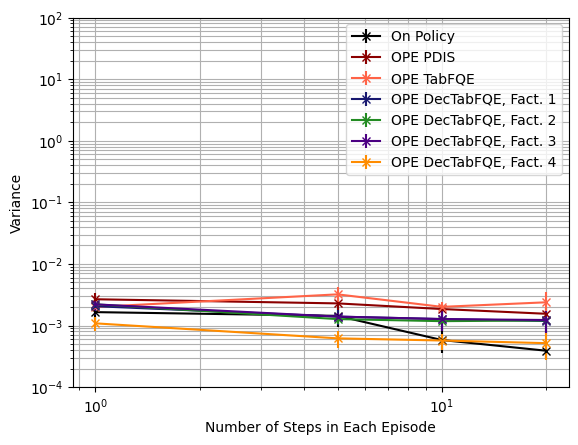

In [61]:
label = 'var'
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, estimator='DM')

On Policy-----[0.0016506  0.00143548 0.00058133 0.00038993]
OPE PDIS-----[0.00266957 0.00228655 0.00185276 0.00155109]
OPE DR-----[0.00313365 0.00663764 0.00832996 0.00860214]
OPE DecDR, Fact. 1-----[0.00325973 0.00339381 0.00373979 0.0025257 ]
OPE DecDR, Fact. 2-----[0.00343364 0.00301521 0.00255832 0.00306084]
OPE DecDR, Fact. 3-----[0.00357841 0.00396145 0.00389365 0.00384861]
OPE DecDR, Fact. 4-----[0.00352523 0.00290665 0.00276163 0.00217451]


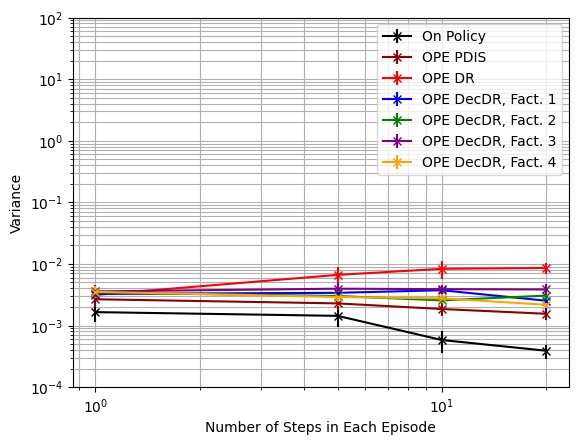

In [62]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, estimator='DR')

##### Plot MSE

On Policy-----[0.0016506  0.00143548 0.00058133 0.00038993]
OPE PDIS-----[0.00377846 0.00266243 0.00195672 0.00158471]
OPE TabFQE-----[0.00340311 0.10007025 0.15155555 0.16835601]
OPE DecTabFQE, Fact. 1-----[0.00340954 0.00839384 0.0259826  0.03474428]
OPE DecTabFQE, Fact. 2-----[0.0048412  0.00822313 0.02534037 0.03509361]
OPE DecTabFQE, Fact. 3-----[0.00405897 0.00908653 0.02833745 0.03747505]
OPE DecTabFQE, Fact. 4-----[0.00578349 0.08473222 0.13688348 0.15711358]


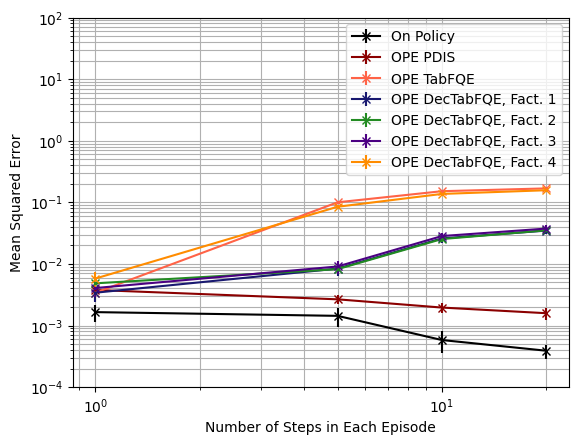

In [63]:
label = 'MSE'
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, estimator='DM')

On Policy-----[0.0016506  0.00143548 0.00058133 0.00038993]
OPE PDIS-----[0.00377846 0.00266243 0.00195672 0.00158471]
OPE DR-----[0.00443727 0.00681193 0.00852772 0.00910605]
OPE DecDR, Fact. 1-----[0.00465586 0.00400622 0.00398178 0.00257362]
OPE DecDR, Fact. 2-----[0.00587974 0.00381831 0.00267026 0.0030799 ]
OPE DecDR, Fact. 3-----[0.005206   0.0043216  0.00399771 0.00394694]
OPE DecDR, Fact. 4-----[0.00526735 0.00368196 0.00295119 0.00221917]


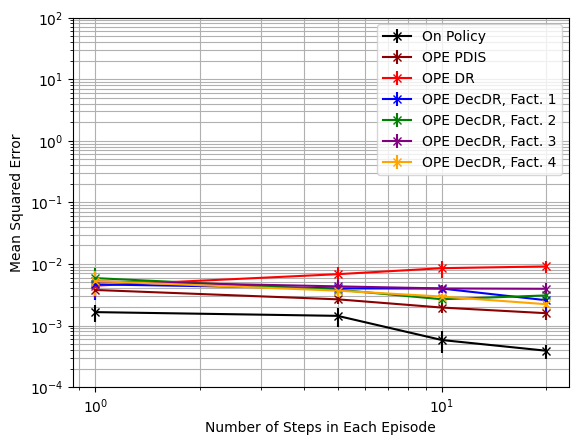

In [64]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, estimator='DR')

##### Plot ESS

On Policy-----[100. 100. 100. 100.]
OPE PDIS-----[65.25282394 66.1176925  32.28568014 25.48812939]
OPE TabFQE-----[86.69133352 48.04944765 29.61162838 19.2768668 ]
OPE DecTabFQE, Fact. 1-----[ 88.13421846 102.56303507  46.24639809  36.27193069]
OPE DecTabFQE, Fact. 2-----[ 83.42331442 115.03579791  49.07639079  32.55471752]
OPE DecTabFQE, Fact. 3-----[ 79.89184857 104.24590143  54.91133507  36.04532037]
OPE DecTabFQE, Fact. 4-----[164.29991112 229.65149332 102.13288973  85.65028484]


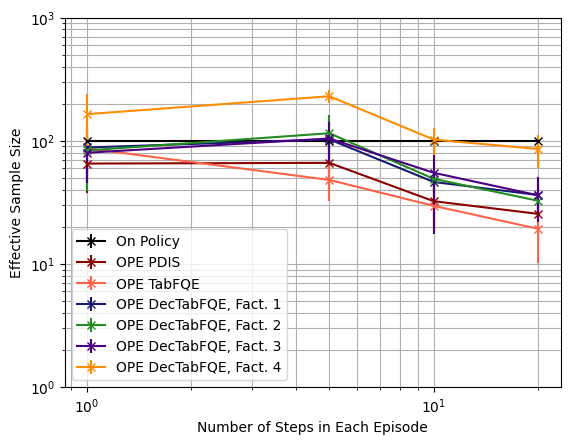

In [65]:
label = 'ESS'
plot_graphs(ESS_means, ESS_stds, label, 10**(0), 10**3, shorter_D, estimator='DM')

On Policy-----[100. 100. 100. 100.]
OPE PDIS-----[65.25282394 66.1176925  32.28568014 25.48812939]
OPE DR-----[54.45650021 25.46742975  8.0940895   4.67006431]
OPE DecDR, Fact. 1-----[54.56194379 42.38452047 15.92958878 16.99785994]
OPE DecDR, Fact. 2-----[50.84006453 50.74452588 22.60479522 14.1942072 ]
OPE DecDR, Fact. 3-----[49.66018149 39.17031137 15.64876635 10.45501455]
OPE DecDR, Fact. 4-----[49.27861979 55.62708352 20.44740586 18.19737005]


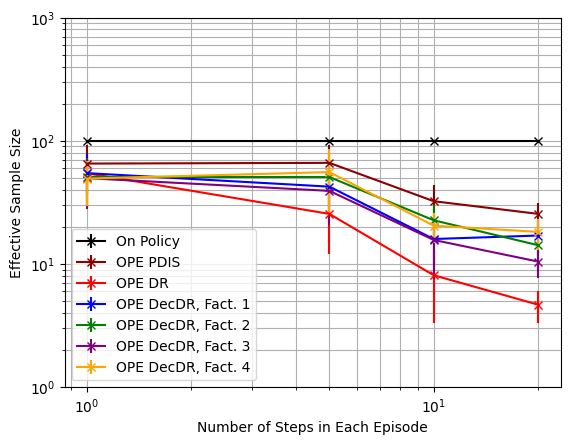

In [66]:
plot_graphs(ESS_means, ESS_stds, label, 10**(0), 10**3, shorter_D, estimator='DR')

# Test Out on 1 State MDP

In [ ]:
#Change our working directory
if os.getcwd() == '/content':
  os.chdir('./Factored-Action-Spaces-for-OPE')

## Varying Number of Episodes: Policy Divergence 1.44

**Note**: Restart the runtime before running all code in this section

### Generate Data Set

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

Policy divergence: 1.44
Start state: state, start state no: 0


### Run Estimates on Collected Data Sets

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 1.44
VERSION_NUMBER = 1

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_numbers, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_tabularFQE = np.zeros(RUNS)
  estimates_OPE_DR = np.zeros(RUNS)
  estimates_OPE_tabularDecFQE = np.zeros(RUNS)
  estimates_OPE_DecDR = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      Q, V = tabular_FQE(nfb[run], 0.7, pi_e, 20, 2, 4)
      estimates_OPE_tabularFQE[run] = V[START_STATE_NO]
      #Off policy decomposed PDIS estimate
      estimates_OPE_DR[run] = off_policy_DR_estimator(nfb[run], 0.7, pi_b, pi_e, 20, 0.5, 2, 4)
      #Off policy decomposed IS estimate
      Q, V = tabular_DecFQE(fb[run], 0.7, action_spaces, factored_evaluation_policies, 20, [2,2], [2,2])
      for d in range(len(action_spaces)):
        s = factored_state_abstractions[d]['state'][0]
        s_num = factored_state_numbers[d][s]
        estimates_OPE_tabularDecFQE[run] += V[d][s_num]
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecDR[run], _ = off_policy_DecDR_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies, 20, 0.5, [2,2], [2,2])

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_tabularFQE = mean_squared_error(estimates_OPE_tabularFQE, [mean_on_policy]*RUNS)
  mean_OPE_tabularFQE = np.mean(estimates_OPE_tabularFQE)
  var_OPE_tabularFQE = np.var(estimates_OPE_tabularFQE, ddof=0)
  bias1_OPE_tabularFQE = np.sqrt(MSE_OPE_tabularFQE - var_OPE_tabularFQE)
  bias2_OPE_tabularFQE = abs(mean_OPE_tabularFQE - mean_on_policy)
  print(f'Mean off policy tabular FQE estimate: {mean_OPE_tabularFQE}. Bias1: {bias1_OPE_tabularFQE}. Bias2: {bias2_OPE_tabularFQE}. Variance: {var_OPE_tabularFQE}. MSE: {MSE_OPE_tabularFQE}')

  MSE_OPE_DR = mean_squared_error(estimates_OPE_DR, [mean_on_policy]*RUNS)
  mean_OPE_DR = np.mean(estimates_OPE_DR)
  var_OPE_DR = np.var(estimates_OPE_DR, ddof=0)
  bias1_OPE_DR = np.sqrt(MSE_OPE_DR - var_OPE_DR)
  bias2_OPE_DR = abs(mean_OPE_DR - mean_on_policy)
  print(f'Mean off policy DR estimate: {mean_OPE_DR}. Bias1: {bias1_OPE_DR}. Bias2: {bias2_OPE_DR}. Variance: {var_OPE_DR}. MSE: {MSE_OPE_DR}')

  MSE_OPE_tabularDecFQE = mean_squared_error(estimates_OPE_tabularDecFQE, [mean_on_policy]*RUNS)
  mean_OPE_tabularDecFQE = np.mean(estimates_OPE_tabularDecFQE)
  var_OPE_tabularDecFQE = np.var(estimates_OPE_tabularDecFQE, ddof=0)
  bias1_OPE_tabularDecFQE = np.sqrt(MSE_OPE_tabularDecFQE - var_OPE_tabularDecFQE)
  bias2_OPE_tabularDecFQE = abs(mean_OPE_tabularDecFQE - mean_on_policy)
  print(f'Mean off policy tabular DecFQE estimate: {mean_OPE_tabularDecFQE}. Bias1: {bias1_OPE_tabularDecFQE}. Bias2: {bias2_OPE_tabularDecFQE}. Variance: {var_OPE_tabularDecFQE}. MSE: {MSE_OPE_tabularDecFQE}')

  MSE_OPE_DecDR = mean_squared_error(estimates_OPE_DecDR, [mean_on_policy]*RUNS)
  mean_OPE_DecDR = np.mean(estimates_OPE_DecDR)
  var_OPE_DecDR = np.var(estimates_OPE_DecDR, ddof=0)
  bias1_OPE_DecDR = np.sqrt(MSE_OPE_DecDR - var_OPE_DecDR)
  bias2_OPE_DecDR = abs(mean_OPE_DecDR - mean_on_policy)
  print(f'Mean off policy DecDR estimate: {mean_OPE_DecDR}. Bias1: {bias1_OPE_DecDR}. Bias2: {bias2_OPE_DecDR}. Variance: {var_OPE_DecDR}. MSE: {MSE_OPE_DecDR}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_tabularFQE, mean_OPE_DR, mean_OPE_tabularDecFQE, mean_OPE_DecDR])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_tabularFQE, MSE_OPE_DR, MSE_OPE_tabularDecFQE, MSE_OPE_DecDR])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_tabularFQE, var_OPE_DR, var_OPE_tabularDecFQE, var_OPE_DecDR])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_tabularFQE, bias1_OPE_DR, bias1_OPE_tabularDecFQE, bias1_OPE_DecDR])
  return means, biases, vars, MSEs

In [ ]:
means = np.zeros((7, 7))
biases = np.zeros((7, 7))
vars = np.zeros((7, 7))
MSEs = np.zeros((7, 7))

#### 100 runs, 10 episodes

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 10)
gc.collect()

Mean on policy Q estimate: 1.1869999999999998. Variance of on policy Q estimate: 0.041330999999999986
Mean off policy IS estimate: 1.2038399999999998. Bias1: 0.01683999999999991. Bias2: 0.016839999999999966. Variance: 0.1311289344. MSE: 0.13141252
Mean off policy PDIS estimate: 1.2038399999999998. Bias1: 0.01683999999999991. Bias2: 0.016839999999999966 Variance: 0.1311289344. MSE: 0.13141252
Mean off policy tabular FQE estimate: 1.1328. Bias1: 0.05419999999999992. Bias2: 0.054199999999999804. Variance: 0.03234815999999999. MSE: 0.03528579999999998
Mean off policy DR estimate: 1.21008. Bias1: 0.02308000000000021. Bias2: 0.02308000000000021. Variance: 0.09466191359999998. MSE: 0.09519459999999999
Mean off policy tabular DecFQE estimate: 1.2. Bias1: 0.01300000000000012. Bias2: 0.013000000000000123. Variance: 0.0. MSE: 0.00016900000000000313
Mean off policy DecDR estimate: 1.1856. Bias1: 0.0014000000000001797. Bias2: 0.0013999999999998458. Variance: 0.004112639999999999. MSE: 0.00411459999

116

#### 1000 runs, 50 episodes

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 50)
gc.collect()

Mean on policy Q estimate: 1.2022000000000002. Variance of on policy Q estimate: 0.00952716
Mean off policy IS estimate: 1.1664. Bias1: 0.03580000000000015. Bias2: 0.035800000000000054. Variance: 0.016562073599999994. MSE: 0.017843713600000005
Mean off policy PDIS estimate: 1.1664. Bias1: 0.03580000000000015. Bias2: 0.035800000000000054 Variance: 0.016562073599999994. MSE: 0.017843713600000005
Mean off policy tabular FQE estimate: 1.2. Bias1: 0.002200000000000202. Bias2: 0.002200000000000202. Variance: 0.0. MSE: 4.840000000000889e-06
Mean off policy DR estimate: 1.2. Bias1: 0.002200000000000202. Bias2: 0.002200000000000202. Variance: 0.0. MSE: 4.840000000000889e-06
Mean off policy tabular DecFQE estimate: 1.2. Bias1: 0.002200000000000202. Bias2: 0.002200000000000202. Variance: 0.0. MSE: 4.840000000000889e-06
Mean off policy DecDR estimate: 1.2. Bias1: 0.002200000000000202. Bias2: 0.002200000000000202. Variance: 0.0. MSE: 4.840000000000889e-06


0

#### 1000 runs, 100 episodes

In [ ]:
means[2, :], biases[2, :], vars[2, :], MSEs[2, :] = evaluate_PE(100, 100)
gc.collect()

Mean on policy Q estimate: 1.2066. Variance of on policy Q estimate: 0.004664440000000002
Mean off policy IS estimate: 1.176288. Bias1: 0.030311999999999988. Bias2: 0.030311999999999895. Variance: 0.009563360256000015. MSE: 0.010482177600000014
Mean off policy PDIS estimate: 1.176288. Bias1: 0.030311999999999988. Bias2: 0.030311999999999895 Variance: 0.009563360256000015. MSE: 0.010482177600000014
Mean off policy tabular FQE estimate: 1.2. Bias1: 0.006599999999999938. Bias2: 0.006599999999999939. Variance: 0.0. MSE: 4.355999999999918e-05
Mean off policy DR estimate: 1.2. Bias1: 0.006599999999999717. Bias2: 0.006599999999999939. Variance: 4.930380657631324e-32. MSE: 4.355999999999627e-05
Mean off policy tabular DecFQE estimate: 1.2. Bias1: 0.006599999999999938. Bias2: 0.006599999999999939. Variance: 0.0. MSE: 4.355999999999918e-05
Mean off policy DecDR estimate: 1.2. Bias1: 0.006599999999999717. Bias2: 0.006599999999999939. Variance: 4.930380657631324e-32. MSE: 4.355999999999627e-05


0

#### 1000 runs, 500 episodes

In [ ]:
means[3, :], biases[3, :], vars[3, :], MSEs[3, :] = evaluate_PE(100, 500)
gc.collect()

Mean on policy Q estimate: 1.20324. Variance of on policy Q estimate: 0.0008579824000000015
Mean off policy IS estimate: 1.1995776. Bias1: 0.0036624000000000856. Bias2: 0.0036624000000000656. Variance: 0.001947789066240001. MSE: 0.0019612022400000016
Mean off policy PDIS estimate: 1.1995776. Bias1: 0.0036624000000000856. Bias2: 0.0036624000000000656 Variance: 0.001947789066240001. MSE: 0.0019612022400000016
Mean off policy tabular FQE estimate: 1.2. Bias1: 0.003240000000000131. Bias2: 0.0032400000000001317. Variance: 0.0. MSE: 1.0497600000000848e-05
Mean off policy DR estimate: 1.2. Bias1: 0.003240000000000131. Bias2: 0.0032400000000001317. Variance: 0.0. MSE: 1.0497600000000848e-05
Mean off policy tabular DecFQE estimate: 1.2. Bias1: 0.003240000000000131. Bias2: 0.0032400000000001317. Variance: 0.0. MSE: 1.0497600000000848e-05
Mean off policy DecDR estimate: 1.2. Bias1: 0.003240000000000131. Bias2: 0.0032400000000001317. Variance: 0.0. MSE: 1.0497600000000848e-05


0

#### 1000 runs, 1000 episodes

In [ ]:
means[4, :], biases[4, :], vars[4, :], MSEs[4, :] = evaluate_PE(100, 1000)
gc.collect()

Mean on policy Q estimate: 1.20238. Variance of on policy Q estimate: 0.000428695600000001
Mean off policy IS estimate: 1.1980128. Bias1: 0.00436719999999994. Bias2: 0.0043671999999999045. Variance: 0.0010785900441599996. MSE: 0.001097662479999999
Mean off policy PDIS estimate: 1.1980128. Bias1: 0.00436719999999994. Bias2: 0.0043671999999999045 Variance: 0.0010785900441599996. MSE: 0.001097662479999999
Mean off policy tabular FQE estimate: 1.2. Bias1: 0.0023800000000000483. Bias2: 0.0023800000000000487. Variance: 0.0. MSE: 5.664400000000231e-06
Mean off policy DR estimate: 1.1999999999999995. Bias1: 0.0023800000000002704. Bias2: 0.002380000000000493. Variance: 4.930380657631324e-32. MSE: 5.664400000001288e-06
Mean off policy tabular DecFQE estimate: 1.2. Bias1: 0.0023800000000000483. Bias2: 0.0023800000000000487. Variance: 0.0. MSE: 5.664400000000231e-06
Mean off policy DecDR estimate: 1.1999999999999995. Bias1: 0.0023800000000002704. Bias2: 0.002380000000000493. Variance: 4.9303806576

0

#### 1000 runs, 5000 episodes

In [ ]:
means[5, :], biases[5, :], vars[5, :], MSEs[5, :] = evaluate_PE(100, 5000)
gc.collect()

Mean on policy Q estimate: 1.2002560000000002. Variance of on policy Q estimate: 0.00010714166400000008
Mean off policy IS estimate: 1.20087168. Bias1: 0.0006156799999998017. Bias2: 0.0006156799999998963. Variance: 0.00022114228469759999. MSE: 0.00022152134655999974
Mean off policy PDIS estimate: 1.20087168. Bias1: 0.0006156799999998017. Bias2: 0.0006156799999998963 Variance: 0.00022114228469759999. MSE: 0.00022152134655999974
Mean off policy tabular FQE estimate: 1.2. Bias1: 0.000256000000000256. Bias2: 0.000256000000000256. Variance: 0.0. MSE: 6.553600000013108e-08
Mean off policy DR estimate: 1.2. Bias1: 0.000256000000000256. Bias2: 0.000256000000000256. Variance: 0.0. MSE: 6.553600000013108e-08
Mean off policy tabular DecFQE estimate: 1.2. Bias1: 0.000256000000000256. Bias2: 0.000256000000000256. Variance: 0.0. MSE: 6.553600000013108e-08
Mean off policy DecDR estimate: 1.2. Bias1: 0.000256000000000256. Bias2: 0.000256000000000256. Variance: 0.0. MSE: 6.553600000013108e-08


0

#### 1000 runs, 10000 episodes

In [ ]:
means[6, :], biases[6, :], vars[6, :], MSEs[6, :] = evaluate_PE(100, 10000)
gc.collect()

Mean on policy Q estimate: 1.2003649999999997. Variance of on policy Q estimate: 3.454487500000007e-05
Mean off policy IS estimate: 1.19917344. Bias1: 0.0011915599999996055. Bias2: 0.0011915599999996473. Variance: 0.00011210709104640014. MSE: 0.0001135269062799992
Mean off policy PDIS estimate: 1.19917344. Bias1: 0.0011915599999996055. Bias2: 0.0011915599999996473 Variance: 0.00011210709104640014. MSE: 0.0001135269062799992
Mean off policy tabular FQE estimate: 1.2. Bias1: 0.00036499999999972665. Bias2: 0.00036499999999972665. Variance: 0.0. MSE: 1.3322499999980045e-07
Mean off policy DR estimate: 1.2. Bias1: 0.00036499999999972665. Bias2: 0.00036499999999972665. Variance: 0.0. MSE: 1.3322499999980045e-07
Mean off policy tabular DecFQE estimate: 1.2. Bias1: 0.00036499999999972665. Bias2: 0.00036499999999972665. Variance: 0.0. MSE: 1.3322499999980045e-07
Mean off policy DecDR estimate: 1.2. Bias1: 0.00036499999999972665. Bias2: 0.00036499999999972665. Variance: 0.0. MSE: 1.3322499999980

0

#### Write out the readings dict (to copy and paste)

In [ ]:
biases_dict = {
      'On Policy': list(biases[:, 0]),
      'OPE IS': list(biases[:, 1]),
      'OPE PDIS': list(biases[:, 2]),
      'OPE TabFQE': list(biases[:, 3]),
      'OPE DR': list(biases[:, 4]),
      'OPE DecTabFQE': list(biases[:, 5]),
      'OPE DecDR': list(biases[:, 6]),
  }

vars_dict = {
      'On Policy': list(vars[:, 0]),
      'OPE IS': list(vars[:, 1]),
      'OPE PDIS': list(vars[:, 2]),
      'OPE TabFQE': list(vars[:, 3]),
      'OPE DR': list(vars[:, 4]),
      'OPE DecTabFQE': list(vars[:, 5]),
      'OPE DecDR': list(vars[:, 6]),
  }

MSEs_dict = {
      'On Policy': list(MSEs[:, 0]),
      'OPE IS': list(MSEs[:, 1]),
      'OPE PDIS': list(MSEs[:, 2]),
      'OPE TabFQE': list(MSEs[:, 3]),
      'OPE DR': list(MSEs[:, 4]),
      'OPE DecTabFQE': list(MSEs[:, 5]),
      'OPE DecDR': list(MSEs[:, 6]),
  }

print(biases_dict)
print()
print(vars_dict)
print()
print(MSEs_dict)

{'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'OPE IS': [0.04583999999999991, 0.010399999999999642, 0.0045840000000001956, 0.005264800000000042, 0.008866400000000297, 0.0030144800000000273, 0.0013211200000002475], 'OPE PDIS': [0.04583999999999991, 0.010399999999999642, 0.0045840000000001956, 0.005264800000000042, 0.008866400000000297, 0.0030144800000000273, 0.0013211200000002475], 'OPE TabFQE': [0.06840000000000024, 0.005599999999999604, 0.004199999999999981, 0.00038000000000004697, 0.002060000000000173, 0.0014419999999999435, 0.000676000000000121], 'OPE DR': [0.008399999999999012, 0.005887999999999607, 0.004199999999999981, 0.000380000000000491, 0.0020599999999999508, 0.0014420000000154867, 0.0006759999999379485], 'OPE DecTabFQE': [0.030000000000000252, 0.005599999999999604, 0.004199999999999981, 0.00038000000000004697, 0.002060000000000173, 0.0014419999999999435, 0.000676000000000121], 'OPE DecDR': [0.02640000000000021, 0.005599999999999604, 0.004199999999999981, 0.0003800000000

### Plot Graphs
<a id='vs_ep_pd_1_44'></a>
<a name="vs_ep_pd_1_44"></a>

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

def calculate_ESS(variances, episodes):
  ESS = {}
  on_policy_vars = variances['On Policy']
  for key in variances.keys():
    ESS[key] = []
    for ind in range(len(on_policy_vars)):
      ESS[key].append(episodes[ind] * on_policy_vars[ind]/(variances[key][ind] + 1e-10))
  return ESS

def generate_mean_std(readings, legend):
  arrays = None
  for r_dict in readings:
    add_val = np.expand_dims(np.array(r_dict[legend]), axis=0)
    if arrays is None:
      arrays = add_val
    else:
      arrays = np.concatenate((arrays, add_val), axis=0)

  return np.mean(arrays, axis=0), np.std(arrays, axis=0)

def plot_graphs(readings, label, low_ylim, up_ylim):
  EPISODES = [10, 50, 100, 500, 1000, 5000, 10000]

  colours = {
      'On Policy': 'k',
      'OPE PDIS': 'b',
      'OPE TabFQE': 'g',
      'OPE DecTabFQE': 'lime',
      'OPE DR': 'r',
      'OPE DecDR': 'coral'
  }

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error ($Variance \ + \ Bias^2$)',
      'ESS': 'Effective Sample Size'
  }

  legend_list = ['OPE PDIS', 'OPE TabFQE', 'OPE DecTabFQE', 'OPE DR', 'OPE DecDR']

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
  for legend in legend_list:
    mean_reading, std_reading = generate_mean_std(readings, legend)
    if label == 'var':
      mean_reading[np.isclose(mean_reading, 0.)] = 1e-10
      print(mean_reading)
    plt.errorbar(EPISODES, mean_reading, yerr=std_reading, color=colours[legend], marker='x')

  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Number of Episodes')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-vs-episodes-policy-divergence-1-44.pdf', dpi=300)
  plt.show()

#### Bias

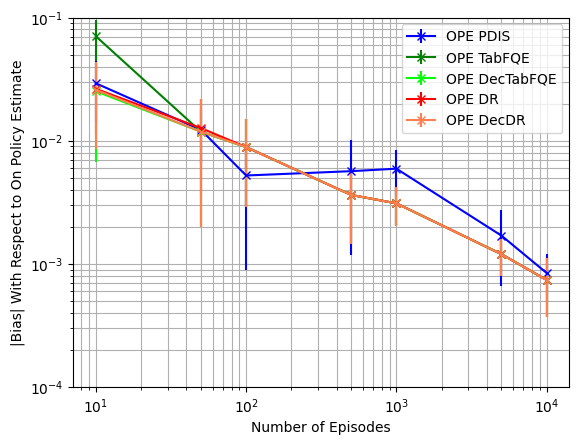

In [ ]:
biases1 = {'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'OPE IS': [0.017199999999999757, 0.018039999999999817, 0.0015879999999985556, 0.014051999999999783, 0.008566800000000041, 0.00281711999999992, 0.0004994399999999293],
           'OPE PDIS': [0.017199999999999757, 0.018039999999999817, 0.0015879999999985556, 0.014051999999999783, 0.008566800000000041, 0.00281711999999992, 0.0004994399999999293],
           'OPE TabFQE': [0.07959999999999987, 0.0002000000000002, 0.001300000000000079, 0.006179999999999852, 0.0034500000000001756, 0.001211999999999991, 0.0003420000000000645],
           'OPE DR': [0.012560000000001289, 0.004040000000000229, 0.001300000000000079, 0.006180000000000296, 0.0034500000000003976, 0.001211999999984448, 0.000342000000062237],
           'OPE DecTabFQE': [0.004000000000000319, 0.0002000000000002, 0.001300000000000079, 0.006179999999999852, 0.0034500000000001756, 0.001211999999999991, 0.0003420000000000645],
           'OPE DecDR': [0.007600000000000087, 0.0002000000000002, 0.001300000000000079, 0.006180000000000296, 0.0034500000000003976, 0.001211999999984448, 0.000342000000062237]}

biases2 = {'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'OPE IS': [0.0068000000000002165, 0.011056000000000055, 0.0018639999999998903, 0.004409599999999965, 0.004714799999999952, 0.0007894400000000462, 0.0010842799999999978],
           'OPE PDIS': [0.0068000000000002165, 0.011056000000000055, 0.0018639999999998903, 0.004409599999999965, 0.004714799999999952, 0.0007894400000000462, 0.0010842799999999978],
           'OPE TabFQE': [0.08919999999999993, 0.01159999999999983, 0.012999999999999904, 0.005919999999999925, 0.004049999999999887, 0.0015439999999999898, 0.0010189999999998811],
           'OPE DR': [0.038320000000000215, 0.01159999999999983, 0.012999999999999904, 0.005919999999999482, 0.004049999999999666, 0.001544000000015533, 0.0010189999999377084],
           'OPE DecTabFQE': [0.004000000000000102, 0.01159999999999983, 0.012999999999999904, 0.005919999999999925, 0.004049999999999887, 0.0015439999999999898, 0.0010189999999998811],
           'OPE DecDR': [0.006400000000000037, 0.01159999999999983, 0.012999999999999904, 0.005919999999999482, 0.004049999999999666, 0.001544000000015533, 0.0010189999999377084]}

biases3 = {'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'OPE IS': [0.0442400000000003, 0.018839999999999905, 0.01348799999999994, 0.0006759999999998599, 0.002659600000000066, 0.000503359999999949, 0.00037748000000005337],
           'OPE PDIS': [0.0442400000000003, 0.018839999999999905, 0.01348799999999994, 0.0006759999999998599, 0.002659600000000066, 0.000503359999999949, 0.00037748000000005337],
           'OPE TabFQE': [0.021999999999999884, 0.029399999999999878, 0.018000000000000013, 0.0032599999999998177, 0.004329999999999945, 0.00043999999999999595, 0.0003649999999999487],
           'OPE DR': [0.024080000000000296, 0.029399999999999878, 0.018000000000000013, 0.003259999999999375, 0.004329999999999723, 0.0004399999999844529, 0.0003649999999377762],
           'OPE DecTabFQE': [0.05000000000000005, 0.029399999999999878, 0.018000000000000013, 0.0032599999999998177, 0.004329999999999945, 0.00043999999999999595, 0.0003649999999999487],
           'OPE DecDR': [0.051200000000000044, 0.029399999999999878, 0.018000000000000013, 0.003259999999999375, 0.004329999999999723, 0.0004399999999844529, 0.0003649999999377762]}

biases4 = {'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'OPE IS': [0.03224000000000014, 0.002959999999999509, 0.004580000000000278, 0.0038976000000003038, 0.004836000000000081, 0.001357919999999744, 0.0009303199999999153],
           'OPE PDIS': [0.03224000000000014, 0.002959999999999509, 0.004580000000000278, 0.0038976000000003038, 0.004836000000000081, 0.001357919999999744, 0.0009303199999999153],
           'OPE TabFQE': [0.09320000000000025, 0.012399999999999967, 0.007900000000000018, 0.0024000000000001798, 0.0016199999999999548, 0.0013559999999996908, 0.0012979999999997993],
           'OPE DR': [0.04856000000000025, 0.012399999999999967, 0.007900000000000018, 0.0023999999999997357, 0.0016199999999997325, 0.001356000000015234, 0.0012979999999376268],
           'OPE DecTabFQE': [0.03800000000000026, 0.012399999999999967, 0.007900000000000018, 0.0024000000000001798, 0.0016199999999999548, 0.0013559999999996908, 0.0012979999999997993],
           'OPE DecDR': [0.03800000000000025, 0.012399999999999967, 0.007900000000000018, 0.0023999999999997357, 0.0016199999999997325, 0.001356000000015234, 0.0012979999999376268]}

biases5 = {'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'OPE IS': [0.04583999999999991, 0.010399999999999642, 0.0045840000000001956, 0.005264800000000042, 0.008866400000000297, 0.0030144800000000273, 0.0013211200000002475],
           'OPE PDIS': [0.04583999999999991, 0.010399999999999642, 0.0045840000000001956, 0.005264800000000042, 0.008866400000000297, 0.0030144800000000273, 0.0013211200000002475],
           'OPE TabFQE': [0.06840000000000024, 0.005599999999999604, 0.004199999999999981, 0.00038000000000004697, 0.002060000000000173, 0.0014419999999999435, 0.000676000000000121],
           'OPE DR': [0.008399999999999012, 0.005887999999999607, 0.004199999999999981, 0.000380000000000491, 0.0020599999999999508, 0.0014420000000154867, 0.0006759999999379485],
           'OPE DecTabFQE': [0.030000000000000252, 0.005599999999999604, 0.004199999999999981, 0.00038000000000004697, 0.002060000000000173, 0.0014419999999999435, 0.000676000000000121],
           'OPE DecDR': [0.02640000000000021, 0.005599999999999604, 0.004199999999999981, 0.000380000000000491, 0.0020599999999999508, 0.0014420000000154867, 0.0006759999999379485]}

biases = [biases1, biases2, biases3, biases4, biases5]

plot_graphs(biases, 'bias', 10**(-4), 10**(-1))

#### Variance

[4.7749600e-02 9.1759840e-03 4.8558520e-03 9.7778184e-04 5.3601762e-04
 9.5987324e-05 4.3539174e-05]
[0.10114781 0.01956668 0.01010112 0.00193866 0.00096126 0.00021715
 0.00010675]
[3.204288e-02 1.000000e-10 1.000000e-10 1.000000e-10 1.000000e-10
 1.000000e-10 1.000000e-10]
[1.4256e-03 1.0000e-10 1.0000e-10 1.0000e-10 1.0000e-10 1.0000e-10
 1.0000e-10]
[7.25787648e-02 1.46517811e-04 1.00000000e-10 1.00000000e-10
 1.00000000e-10 1.00000000e-10 1.00000000e-10]
[3.679776e-03 1.000000e-10 1.000000e-10 1.000000e-10 1.000000e-10
 1.000000e-10 1.000000e-10]


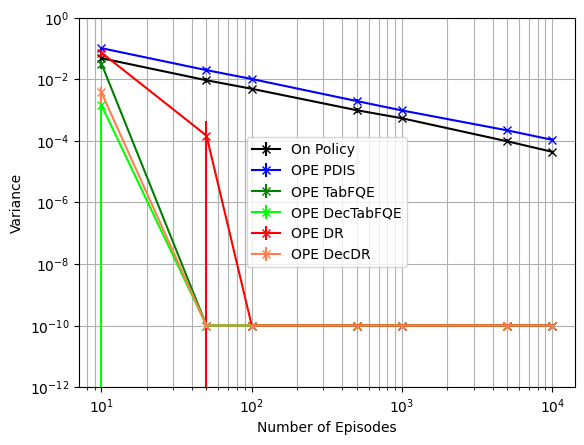

In [ ]:
vars1 = {'On Policy': [0.04259600000000001, 0.007307960000000001, 0.004347310000000003, 0.0008536076000000014, 0.0005296275000000006, 9.294945600000012e-05, 3.9977236e-05],
         'OPE IS': [0.09649152, 0.017402572799999978, 0.010765126656000011, 0.0018390343679999992, 0.0007940884377599993, 0.00021784229314560034, 0.0001107498737664],
         'OPE PDIS': [0.09649152, 0.017402572799999978, 0.010765126656000011, 0.0018390343679999992, 0.0007940884377599993, 0.00021784229314560034, 0.0001107498737664],
         'OPE TabFQE': [0.040573439999999995, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DR': [0.10356848639999999, 0.0007243776000000004, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31],
         'OPE DecTabFQE': [0.0035639999999999977, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DecDR': [0.00653184, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31]}

vars2 = {'On Policy': [0.04839599999999999, 0.010569439999999996, 0.0052510000000000005, 0.0009515136000000006, 0.000591607500000001, 9.610886400000008e-05, 4.811773899999988e-05],
         'OPE IS': [0.12485375999999998, 0.01711875686399998, 0.009044066304000007, 0.001844068515840002, 0.0009991186329600004, 0.00019840739696640026, 0.00010907631452159991],
         'OPE PDIS': [0.12485375999999998, 0.01711875686399998, 0.009044066304000007, 0.001844068515840002, 0.0009991186329600004, 0.00019840739696640026, 0.00010907631452159991],
         'OPE TabFQE': [0.048130559999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DR': [0.09528053759999996, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31],
         'OPE DecTabFQE': [0.003563999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DecDR': [0.004969439999999999, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31]}

vars3 = {'On Policy': [0.04249999999999999, 0.00785964, 0.004828000000000001, 0.0013634124000000017, 0.0005694811000000015, 0.00011597599999999972, 4.966247499999992e-05],
         'OPE IS': [0.09848586239999997, 0.024170803199999983, 0.009898822656000008, 0.0016714414079999997, 0.0008885075558400002, 0.00022348361687039994, 0.0001156887530495997],
         'OPE PDIS': [0.09848586239999997, 0.024170803199999983, 0.009898822656000008, 0.0016714414079999997, 0.0008885075558400002, 0.00022348361687039994, 0.0001156887530495997],
         'OPE TabFQE': [0.029376, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DR': [0.056743833599999995, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31],
         'OPE DecTabFQE': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DecDR': [0.0007185599999999987, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31]}

vars4 = {'On Policy': [0.050356, 0.00903024, 0.00536259, 0.0007693600000000013, 0.0004325956000000008, 7.299646400000005e-05, 3.9344995999999864e-05],
         'OPE IS': [0.0890855424, 0.020264140799999983, 0.009390182400000013, 0.0018792220262399994, 0.0010143014400000006, 0.0002261816487936001, 8.058379253759936e-05],
         'OPE PDIS': [0.0890855424, 0.020264140799999983, 0.009390182400000013, 0.0018792220262399994, 0.0010143014400000006, 0.0002261816487936001, 8.058379253759936e-05],
         'OPE TabFQE': [0.02748096, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DR': [0.04094576640000001, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31],
         'OPE DecTabFQE': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DecDR': [0.003168, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31]}

vars5 = {'On Policy': [0.05489999999999999, 0.011112640000000002, 0.00449036, 0.0009510156000000015, 0.0005567764000000002, 0.00010190583600000004, 4.0593424000000057e-05],
         'OPE IS': [0.09682237439999997, 0.018877132799999977, 0.011407417344000003, 0.0024595528089600012, 0.0011102717030399994, 0.00021985962024960014, 0.00011764299202559985],
         'OPE PDIS': [0.09682237439999997, 0.018877132799999977, 0.011407417344000003, 0.0024595528089600012, 0.0011102717030399994, 0.00021985962024960014, 0.00011764299202559985],
         'OPE TabFQE': [0.014653440000000004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DR': [0.0663552, 8.21145600000009e-06, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31],
         'OPE DecTabFQE': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DecDR': [0.0030110400000000013, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31]}


vars = [vars1, vars2, vars3, vars4, vars5]

plot_graphs(vars, 'var', 1e-12, 10**0)

#### MSE

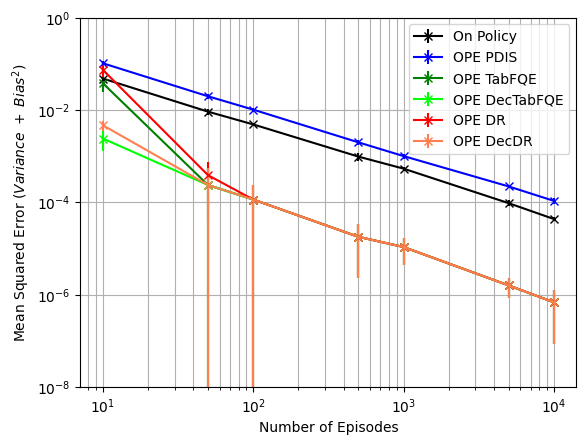

In [ ]:
MSEs1 = {'On Policy': [0.04259600000000001, 0.007307960000000001, 0.004347310000000003, 0.0008536076000000014, 0.0005296275000000006, 9.294945600000012e-05, 3.9977236e-05],
         'OPE IS': [0.09678735999999999, 0.01772801439999997, 0.010767648400000007, 0.002036493071999993, 0.0008674785, 0.0002257784582399999, 0.00011099931407999994],
         'OPE PDIS': [0.09678735999999999, 0.01772801439999997, 0.010767648400000007, 0.002036493071999993, 0.0008674785, 0.0002257784582399999, 0.00011099931407999994],
         'OPE TabFQE': [0.046909599999999975, 4.000000000008e-08, 1.6900000000002055e-06, 3.8192399999998174e-05, 1.1902500000001211e-05, 1.4689439999999786e-06, 1.169640000000441e-07],
         'OPE DR': [0.10372624000000003, 0.0007406992000000023, 1.6900000000002055e-06, 3.819240000000366e-05, 1.1902500000002744e-05, 1.468943999962302e-06, 1.1696400004257012e-07],
         'OPE DecTabFQE': [0.0035800000000000003, 4.000000000008e-08, 1.6900000000002055e-06, 3.8192399999998174e-05, 1.1902500000001211e-05, 1.4689439999999786e-06, 1.169640000000441e-07],
         'OPE DecDR': [0.006589600000000001, 4.000000000008e-08, 1.6900000000002055e-06, 3.819240000000366e-05, 1.1902500000002744e-05, 1.468943999962302e-06, 1.1696400004257012e-07]}

MSEs2 = {'On Policy': [0.04839599999999999, 0.010569439999999996, 0.0052510000000000005, 0.0009515136000000006, 0.000591607500000001, 9.610886400000008e-05, 4.811773899999988e-05],
         'OPE IS': [0.12489999999999998, 0.017240991999999983, 0.009047540800000007, 0.0018635130880000016, 0.001021347972, 0.00019903061248000033, 0.0001102519776399999],
         'OPE PDIS': [0.12489999999999998, 0.017240991999999983, 0.009047540800000007, 0.0018635130880000016, 0.001021347972, 0.00019903061248000033, 0.0001102519776399999],
         'OPE TabFQE': [0.05608719999999998, 0.00013455999999999606, 0.00016899999999999752, 3.5046399999999116e-05, 1.6402499999999086e-05, 2.3839359999999685e-06, 1.0383609999997578e-06],
         'OPE DR': [0.09674895999999998, 0.00013455999999999606, 0.00016899999999999752, 3.5046399999993865e-05, 1.6402499999997294e-05, 2.3839360000479657e-06, 1.03836099987305e-06],
         'OPE DecTabFQE': [0.00358, 0.00013455999999999606, 0.00016899999999999752, 3.5046399999999116e-05, 1.6402499999999086e-05, 2.3839359999999685e-06, 1.0383609999997578e-06],
         'OPE DecDR': [0.005010399999999999, 0.00013455999999999606, 0.00016899999999999752, 3.5046399999993865e-05, 1.6402499999997294e-05, 2.3839360000479657e-06, 1.03836099987305e-06]}

MSEs3 = {'On Policy': [0.04249999999999999, 0.00785964, 0.004828000000000001, 0.0013634124000000017, 0.0005694811000000015, 0.00011597599999999972, 4.966247499999992e-05],
         'OPE IS': [0.10044304, 0.02452574879999998, 0.010080748800000006, 0.0016718983839999996, 0.0008955810280000005, 0.00022373698815999989, 0.00011583124419999974],
         'OPE PDIS': [0.10044304, 0.02452574879999998, 0.010080748800000006, 0.0016718983839999996, 0.0008955810280000005, 0.00022373698815999989, 0.00011583124419999974],
         'OPE TabFQE': [0.029859999999999994, 0.0008643599999999927, 0.00032400000000000045, 1.0627599999998812e-05, 1.874889999999952e-05, 1.935999999999964e-07, 1.3322499999996255e-07],
         'OPE DR': [0.05732368000000001, 0.0008643599999999927, 0.00032400000000000045, 1.0627599999995924e-05, 1.8748899999997604e-05, 1.9359999998631853e-07, 1.3322499995457664e-07],
         'OPE DecTabFQE': [0.002500000000000005, 0.0008643599999999927, 0.00032400000000000045, 1.0627599999998812e-05, 1.874889999999952e-05, 1.935999999999964e-07, 1.3322499999996255e-07],
         'OPE DecDR': [0.003340000000000003, 0.0008643599999999927, 0.00032400000000000045, 1.0627599999995924e-05, 1.8748899999997604e-05, 1.9359999998631853e-07, 1.3322499995457664e-07]}

MSEs4 = {'On Policy': [0.050356, 0.00903024, 0.00536259, 0.0007693600000000013, 0.0004325956000000008, 7.299646400000005e-05, 3.9344995999999864e-05],
         'OPE IS': [0.09012496, 0.02027290239999998, 0.009411158800000015, 0.0018944133120000017, 0.0010376883360000014, 0.00022802559551999942, 8.14492878399992e-05],
         'OPE PDIS': [0.09012496, 0.02027290239999998, 0.009411158800000015, 0.0018944133120000017, 0.0010376883360000014, 0.00022802559551999942, 8.14492878399992e-05],
         'OPE TabFQE': [0.036167200000000045, 0.00015375999999999915, 6.241000000000029e-05, 5.760000000000862e-06, 2.6243999999998537e-06, 1.8387359999991617e-06, 1.6848039999994791e-06],
         'OPE DR': [0.04330384000000003, 0.00015375999999999915, 6.241000000000029e-05, 5.759999999998732e-06, 2.6243999999991333e-06, 1.8387360000413143e-06, 1.6848039998380791e-06],
         'OPE DecTabFQE': [0.00144400000000002, 0.00015375999999999915, 6.241000000000029e-05, 5.760000000000862e-06, 2.6243999999998537e-06, 1.8387359999991617e-06, 1.6848039999994791e-06],
         'OPE DecDR': [0.004612000000000019, 0.00015375999999999915, 6.241000000000029e-05, 5.759999999998732e-06, 2.6243999999991333e-06, 1.8387360000413143e-06, 1.6848039998380791e-06]}

MSEs5 = {'On Policy': [0.05489999999999999, 0.011112640000000002, 0.00449036, 0.0009510156000000015, 0.0005567764000000002, 0.00010190583600000004, 4.0593424000000057e-05],
         'OPE IS': [0.09892367999999996, 0.01898529279999997, 0.011428430400000005, 0.0024872709280000017, 0.0011888847520000047, 0.0002289467099200003, 0.0001193883500800005],
         'OPE PDIS': [0.09892367999999996, 0.01898529279999997, 0.011428430400000005, 0.0024872709280000017, 0.0011888847520000047, 0.0002289467099200003, 0.0001193883500800005],
         'OPE TabFQE': [0.019332000000000037, 3.135999999999557e-05, 1.7639999999999838e-05, 1.4440000000003568e-07, 4.243600000000712e-06, 2.079363999999837e-06, 4.569760000001636e-07],
         'OPE DR': [0.06642575999999999, 4.287999999999546e-05, 1.7639999999999838e-05, 1.4440000000037317e-07, 4.243599999999797e-06, 2.0793640000446634e-06, 4.5697599991610626e-07],
         'OPE DecTabFQE': [0.000900000000000015, 3.135999999999557e-05, 1.7639999999999838e-05, 1.4440000000003568e-07, 4.243600000000712e-06, 2.079363999999837e-06, 4.569760000001636e-07],
         'OPE DecDR': [0.0037080000000000125, 3.135999999999557e-05, 1.7639999999999838e-05, 1.4440000000037317e-07, 4.243599999999797e-06, 2.0793640000446634e-06, 4.5697599991610626e-07]}

MSEs = [MSEs1, MSEs2, MSEs3, MSEs4, MSEs5]

plot_graphs(MSEs, 'MSE', 10**(-8), 10**0)

#### ESS

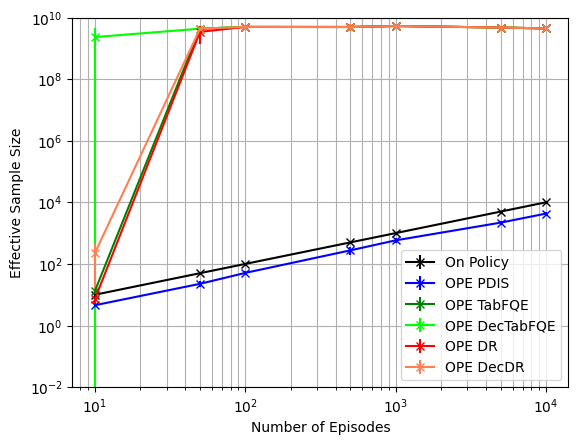

In [ ]:
EPISODES = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

vars1 = {'On Policy': [0.04259600000000001, 0.007307960000000001, 0.004347310000000003, 0.0008536076000000014, 0.0005296275000000006, 9.294945600000012e-05, 3.9977236e-05],
         'OPE IS': [0.09649152, 0.017402572799999978, 0.010765126656000011, 0.0018390343679999992, 0.0007940884377599993, 0.00021784229314560034, 0.0001107498737664],
         'OPE PDIS': [0.09649152, 0.017402572799999978, 0.010765126656000011, 0.0018390343679999992, 0.0007940884377599993, 0.00021784229314560034, 0.0001107498737664],
         'OPE TabFQE': [0.040573439999999995, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DR': [0.10356848639999999, 0.0007243776000000004, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31],
         'OPE DecTabFQE': [0.0035639999999999977, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DecDR': [0.00653184, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31]}

ESS1 = calculate_ESS(vars1, EPISODES)

vars2 = {'On Policy': [0.04839599999999999, 0.010569439999999996, 0.0052510000000000005, 0.0009515136000000006, 0.000591607500000001, 9.610886400000008e-05, 4.811773899999988e-05],
         'OPE IS': [0.12485375999999998, 0.01711875686399998, 0.009044066304000007, 0.001844068515840002, 0.0009991186329600004, 0.00019840739696640026, 0.00010907631452159991],
         'OPE PDIS': [0.12485375999999998, 0.01711875686399998, 0.009044066304000007, 0.001844068515840002, 0.0009991186329600004, 0.00019840739696640026, 0.00010907631452159991],
         'OPE TabFQE': [0.048130559999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DR': [0.09528053759999996, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31],
         'OPE DecTabFQE': [0.003563999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DecDR': [0.004969439999999999, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31]}

ESS2 = calculate_ESS(vars2, EPISODES)

vars3 = {'On Policy': [0.04249999999999999, 0.00785964, 0.004828000000000001, 0.0013634124000000017, 0.0005694811000000015, 0.00011597599999999972, 4.966247499999992e-05],
         'OPE IS': [0.09848586239999997, 0.024170803199999983, 0.009898822656000008, 0.0016714414079999997, 0.0008885075558400002, 0.00022348361687039994, 0.0001156887530495997],
         'OPE PDIS': [0.09848586239999997, 0.024170803199999983, 0.009898822656000008, 0.0016714414079999997, 0.0008885075558400002, 0.00022348361687039994, 0.0001156887530495997],
         'OPE TabFQE': [0.029376, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DR': [0.056743833599999995, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31],
         'OPE DecTabFQE': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DecDR': [0.0007185599999999987, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31]}

ESS3 = calculate_ESS(vars3, EPISODES)

vars4 = {'On Policy': [0.050356, 0.00903024, 0.00536259, 0.0007693600000000013, 0.0004325956000000008, 7.299646400000005e-05, 3.9344995999999864e-05],
         'OPE IS': [0.0890855424, 0.020264140799999983, 0.009390182400000013, 0.0018792220262399994, 0.0010143014400000006, 0.0002261816487936001, 8.058379253759936e-05],
         'OPE PDIS': [0.0890855424, 0.020264140799999983, 0.009390182400000013, 0.0018792220262399994, 0.0010143014400000006, 0.0002261816487936001, 8.058379253759936e-05],
         'OPE TabFQE': [0.02748096, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DR': [0.04094576640000001, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31],
         'OPE DecTabFQE': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DecDR': [0.003168, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31]}


ESS4 = calculate_ESS(vars4, EPISODES)

vars5 = {'On Policy': [0.05489999999999999, 0.011112640000000002, 0.00449036, 0.0009510156000000015, 0.0005567764000000002, 0.00010190583600000004, 4.0593424000000057e-05],
         'OPE IS': [0.09682237439999997, 0.018877132799999977, 0.011407417344000003, 0.0024595528089600012, 0.0011102717030399994, 0.00021985962024960014, 0.00011764299202559985],
         'OPE PDIS': [0.09682237439999997, 0.018877132799999977, 0.011407417344000003, 0.0024595528089600012, 0.0011102717030399994, 0.00021985962024960014, 0.00011764299202559985],
         'OPE TabFQE': [0.014653440000000004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DR': [0.0663552, 8.21145600000009e-06, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31],
         'OPE DecTabFQE': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
         'OPE DecDR': [0.0030110400000000013, 0.0, 0.0, 0.0, 4.930380657631324e-32, 0.0, 1.9721522630525295e-31]}

ESS5 = calculate_ESS(vars5, EPISODES)

ESS = [ESS1, ESS2, ESS3, ESS4]

plot_graphs(ESS, 'ESS', 10**(-2), 10**10)

# Test on 4 State MDP

In [ ]:
#Change our working directory
if os.getcwd() == '/content':
  os.chdir('./Factored-Action-Spaces-for-OPE')

## Varying Trajectory Length With $\gamma = 0.7$

### Generate Data Set

#### From behaviour policy, generate maximum length trajectory

Dataset 1

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 2

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 3

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 4

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 5

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 6

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 7

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 8

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 9

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 10

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Estimate on dataset 1

In [ ]:
import sys
MDP_NAME = '4-state-MDP'
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_state_numbers
from load_discrete_MDP import action_spaces, action_space_mapping
from load_datasets import load_MDP_transitions
from discrete_MDP_helper_functions import find_state_abstraction
import gc

START_STATE_NO = 0
NO_TRAJECTORIES = 10000
TRAJECTORY_LENGTH = 1000
SHORTER_D = 1.44

def evaluate_PE(RUNS, NUM_EPISODES, EPISODE_LENGTH, VERSION_NUMBER):

  estimates = np.zeros(shape=(7,RUNS))

  nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                          START_STATE_NO,
                                                                                          NO_TRAJECTORIES,
                                                                                          TRAJECTORY_LENGTH,
                                                                                          SHORTER_D,
                                                                                          VERSION_NUMBER)

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  for run in range(2*RUNS, 3*RUNS):

      #On policy Q estimate
      estimates[0, run - 2*RUNS] = pe.on_policy_Q_estimate(nfe[run, :, :EPISODE_LENGTH, :], 0.7)
      #Off policy IS estimate
      estimates[1, run - 2*RUNS] = pe.off_policy_IS_estimator(nfb[run, :, :EPISODE_LENGTH, :], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates[2, run - 2*RUNS] = pe.off_policy_PDIS_estimator(nfb[run, :, :EPISODE_LENGTH, :], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      Q, V = tabular_FQE(nfb[run, :, :EPISODE_LENGTH, :], 0.7, pi_e, 20, 4, 4)
      estimates[3, run - 2*RUNS] = V[START_STATE_NO]
      #Off policy decomposed PDIS estimate
      estimates[4, run - 2*RUNS] = off_policy_DR_estimator(nfb[run, :, :EPISODE_LENGTH, :], 0.7, pi_b, pi_e, 20, 0.5, 4, 4)
      #Off policy decomposed IS estimate
      Q, V = tabular_DecFQE(fb[run, :, :EPISODE_LENGTH, :, :], 0.7, action_spaces, factored_evaluation_policies, 20, [2,2], [2,2])
      for d in range(len(action_spaces)):
        s, _ = find_state_abstraction(factored_state_abstractions[d], '0,0')
        s_num = factored_state_numbers[d][s]
        estimates[5, run - 2*RUNS] += V[d][s_num]
      #Off policy decomposed PDIS estimate
      estimates[6, run - 2*RUNS], _ = off_policy_DecDR_estimator(fb[run, :, :EPISODE_LENGTH, :, :], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies, 20, 0.5, [2,2], [2,2])

  return estimates


In [ ]:
from sklearn.metrics import mean_squared_error

def generate_graph_data(estimates):
  means = np.mean(estimates, axis=-1)
  variances = np.var(estimates, ddof=0, axis=-1)
  MSEs = mean_squared_error(estimates.T, np.full((estimates.T).shape, means[0]), multioutput='raw_values')
  biases_1 = np.sqrt(MSEs - variances)
  biases_2 = np.abs(means - np.full(means.shape, means[0]))

  print(f'Mean on policy Q estimate: {means[0]}. Variance of on policy Q estimate: {variances[0]}')
  print(f'Mean off policy IS estimate: {means[1]}. Bias1: {biases_1[1]}. Bias2: {biases_2[1]}. Variance: {variances[1]}. MSE: {MSEs[1]}')
  print(f'Mean off policy PDIS estimate: {means[2]}. Bias1: {biases_1[2]}. Bias2: {biases_2[2]} Variance: {variances[2]}. MSE: {MSEs[2]}')
  print(f'Mean off policy TabFQE estimate: {means[3]}. Bias1: {biases_1[3]}. Bias2: {biases_2[3]}. Variance: {variances[3]}. MSE: {MSEs[3]}')
  print(f'Mean off policy DR estimate: {means[4]}. Bias1: {biases_1[4]}. Bias2: {biases_2[4]}. Variance: {variances[4]}. MSE: {MSEs[4]}')
  print(f'Mean off policy DecTabFQE estimate: {means[5]}. Bias1: {biases_1[5]}. Bias2: {biases_2[5]}. Variance: {variances[5]}. MSE: {MSEs[5]}')
  print(f'Mean off policy DecDR estimate: {means[6]}. Bias1: {biases_1[6]}. Bias2: {biases_2[6]}. Variance: {variances[6]}. MSE: {MSEs[6]}')

  return means, variances, MSEs, biases_1, biases_2

### Run Estimates on Collected Data Sets

#### 100 runs, 1000 episodes, trajectory length 1

In [ ]:
e_1 = evaluate_PE(10, 100, 1, 1)
gc.collect()
e_2 = evaluate_PE(10, 100, 1, 2)
gc.collect()
e_3 = evaluate_PE(10, 100, 1, 3)
gc.collect()
e_4 = evaluate_PE(10, 100, 1, 4)
gc.collect()
e_5 = evaluate_PE(10, 100, 1, 5)
gc.collect()
e_6 = evaluate_PE(10, 100, 1, 6)
gc.collect()
e_7 = evaluate_PE(10, 100, 1, 7)
gc.collect()
e_8 = evaluate_PE(10, 100, 1, 8)
gc.collect()
e_9 = evaluate_PE(10, 100, 1, 9)
gc.collect()
e_10 = evaluate_PE(10, 100, 1, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

(7, 100)


In [ ]:
means, variances, MSEs, biases_1, biases_2 = generate_graph_data(estimates)

Mean on policy Q estimate: 1.2039. Variance of on policy Q estimate: 0.003977790000000002
Mean off policy IS estimate: 1.213824. Bias1: 0.009924000000000047. Bias2: 0.009924000000000044. Variance: 0.012698394624000004. MSE: 0.012796880400000005
Mean off policy PDIS estimate: 1.213824. Bias1: 0.009924000000000047. Bias2: 0.009924000000000044 Variance: 0.012698394624000004. MSE: 0.012796880400000005
Mean off policy TabFQE estimate: 1.3492954485784032. Bias1: 0.14539544857840297. Bias2: 0.14539544857840325. Variance: 0.00013804588346217448. MSE: 0.0212778823507772
Mean off policy DR estimate: 1.202684676997611. Bias1: 0.0012153230023891103. Bias2: 0.0012153230023890238. Variance: 0.0010831723797571989. MSE: 0.001084649389757335
Mean off policy DecTabFQE estimate: 1.6649652983048226. Bias1: 0.4610652983048232. Bias2: 0.4610652983048227. Variance: 0.00018022000206709504. MSE: 0.2127614293029827
Mean off policy DecDR estimate: 1.2039974278543943. Bias1: 9.742785439359487e-05. Bias2: 9.742785

#### 100 runs, 1000 episodes, trajectory length 5

In [ ]:
e_1 = evaluate_PE(10, 100, 5, 1)
gc.collect()
e_2 = evaluate_PE(10, 100, 5, 2)
gc.collect()
e_3 = evaluate_PE(10, 100, 5, 3)
gc.collect()
e_4 = evaluate_PE(10, 100, 5, 4)
gc.collect()
e_5 = evaluate_PE(10, 100, 5, 5)
gc.collect()
e_6 = evaluate_PE(10, 100, 5, 6)
gc.collect()
e_7 = evaluate_PE(10, 100, 5, 7)
gc.collect()
e_8 = evaluate_PE(10, 100, 5, 8)
gc.collect()
e_9 = evaluate_PE(10, 100, 5, 9)
gc.collect()
e_10 = evaluate_PE(10, 100, 5, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

(7, 100)


In [ ]:
means_new, variances_new, MSEs_new, biases_1_new, biases_2_new = generate_graph_data(estimates)
means = np.stack((means, means_new), axis=-1)
variances = np.stack((variances, variances_new), axis=-1)
MSEs = np.stack((MSEs, MSEs_new), axis=-1)
biases_1 = np.stack((biases_1, biases_1_new), axis=-1)
print(means)

Mean on policy Q estimate: 0.7580552300000001. Variance of on policy Q estimate: 0.0066603922703571
Mean off policy IS estimate: 0.7760889010402097. Bias1: 0.01803367104020975. Bias2: 0.018033671040209587. Variance: 0.010096146042027822. MSE: 0.010421359333214322
Mean off policy PDIS estimate: 0.7698325244490547. Bias1: 0.011777294449054595. Bias2: 0.01177729444905462 Variance: 0.01906847128928285. MSE: 0.019207175953822583
Mean off policy TabFQE estimate: 0.6448784912211154. Bias1: 0.11317673877888448. Bias2: 0.11317673877888468. Variance: 0.0039303645284755094. MSE: 0.016739338729099364
Mean off policy DR estimate: 0.774469148392246. Bias1: 0.01641391839224602. Bias2: 0.01641391839224593. Variance: 0.0022709131798008438. MSE: 0.002540329896788156
Mean off policy DecTabFQE estimate: 0.6441136575970619. Bias1: 0.11394157240293822. Bias2: 0.11394157240293823. Variance: 0.0020621435555362084. MSE: 0.015044825477190221
Mean off policy DecDR estimate: 0.7766628155496532. Bias1: 0.018607585

<ipython-input-56-4e33386a1be1>:7: RuntimeWarning: invalid value encountered in sqrt
  biases_1 = np.sqrt(MSEs - variances)


#### 100 runs, 1000 episodes, trajectory length 10

In [ ]:
e_1 = evaluate_PE(10, 100, 10, 1)
gc.collect()
e_2 = evaluate_PE(10, 100, 10, 2)
gc.collect()
e_3 = evaluate_PE(10, 100, 10, 3)
gc.collect()
e_4 = evaluate_PE(10, 100, 10, 4)
gc.collect()
e_5 = evaluate_PE(10, 100, 10, 5)
gc.collect()
e_6 = evaluate_PE(10, 100, 10, 6)
gc.collect()
e_7 = evaluate_PE(10, 100, 10, 7)
gc.collect()
e_8 = evaluate_PE(10, 100, 10, 8)
gc.collect()
e_9 = evaluate_PE(10, 100, 10, 9)
gc.collect()
e_10 = evaluate_PE(10, 100, 10, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

(7, 100)


In [ ]:
means_new, variances_new, MSEs_new, biases_1_new, biases_2_new = generate_graph_data(estimates)
means = np.concatenate((means, means_new[..., np.newaxis]), axis=-1)
variances = np.concatenate((variances, variances_new[..., np.newaxis]), axis=-1)
MSEs = np.concatenate((MSEs, MSEs_new[..., np.newaxis]), axis=-1)
biases_1 = np.concatenate((biases_1, biases_1_new[..., np.newaxis]), axis=-1)

Mean on policy Q estimate: 0.6486204092292001. Variance of on policy Q estimate: 0.007611452167113622
Mean off policy IS estimate: 0.6671162447588262. Bias1: 0.018495835529626067. Bias2: 0.018495835529626192. Variance: 0.020316697601875697. MSE: 0.020658793533814675
Mean off policy PDIS estimate: 0.6590670798027379. Bias1: 0.010446670573537726. Bias2: 0.010446670573537875 Variance: 0.02305349301962118. MSE: 0.0231626259456932
Mean off policy TabFQE estimate: 0.6425412726428321. Bias1: 0.006079136586367813. Bias2: 0.006079136586367939. Variance: 0.002401840745485213. MSE: 0.002438796647120929
Mean off policy DR estimate: 0.6663985645709549. Bias1: 0.01777815534175494. Bias2: 0.017778155341754864. Variance: 0.000783851588150242. MSE: 0.0010999143955058117
Mean off policy DecTabFQE estimate: 0.6362985779526754. Bias1: 0.012321831276524729. Bias2: 0.012321831276524642. Variance: 0.0019434526619222224. MSE: 0.0020952801879293654
Mean off policy DecDR estimate: 0.6623168068510636. Bias1: 0.0

#### 100 runs, 1000 episodes, trajectory length 50

In [ ]:
e_1 = evaluate_PE(10, 100, 50, 1)
gc.collect()
e_2 = evaluate_PE(10, 100, 50, 2)
gc.collect()
e_3 = evaluate_PE(10, 100, 50, 3)
gc.collect()
e_4 = evaluate_PE(10, 100, 50, 4)
gc.collect()
e_5 = evaluate_PE(10, 100, 50, 5)
gc.collect()
e_6 = evaluate_PE(10, 100, 50, 6)
gc.collect()
e_7 = evaluate_PE(10, 100, 50, 7)
gc.collect()
e_8 = evaluate_PE(10, 100, 50, 8)
gc.collect()
e_9 = evaluate_PE(10, 100, 50, 9)
gc.collect()
e_10 = evaluate_PE(10, 100, 50, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

In [ ]:
means_new, variances_new, MSEs_new, biases_1_new, biases_2_new = generate_graph_data(estimates)
means = np.concatenate((means, means_new[..., np.newaxis]), axis=-1)
variances = np.concatenate((variances, variances_new[..., np.newaxis]), axis=-1)
MSEs = np.concatenate((MSEs, MSEs_new[..., np.newaxis]), axis=-1)
biases_1 = np.concatenate((biases_1, biases_1_new[..., np.newaxis]), axis=-1)

#### 100 runs, 1000 episodes, trajectory length 100

In [ ]:
e_1 = evaluate_PE(10, 100, 100, 1)
gc.collect()
e_2 = evaluate_PE(10, 100, 100, 2)
gc.collect()
e_3 = evaluate_PE(10, 100, 100, 3)
gc.collect()
e_4 = evaluate_PE(10, 100, 100, 4)
gc.collect()
e_5 = evaluate_PE(10, 100, 100, 5)
gc.collect()
e_6 = evaluate_PE(10, 100, 100, 6)
gc.collect()
e_7 = evaluate_PE(10, 100, 100, 7)
gc.collect()
e_8 = evaluate_PE(10, 100, 100, 8)
gc.collect()
e_9 = evaluate_PE(10, 100, 100, 9)
gc.collect()
e_10 = evaluate_PE(10, 100, 100, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

(7, 100)


In [ ]:
means_new, variances_new, MSEs_new, biases_1_new, biases_2_new = generate_graph_data(estimates)
means = np.concatenate((means, means_new[..., np.newaxis]), axis=-1)
variances = np.concatenate((variances, variances_new[..., np.newaxis]), axis=-1)
MSEs = np.concatenate((MSEs, MSEs_new[..., np.newaxis]), axis=-1)
biases_1 = np.concatenate((biases_1, biases_1_new[..., np.newaxis]), axis=-1)

Mean on policy Q estimate: 0.6259058422178545. Variance of on policy Q estimate: 0.0076690055508137275
Mean off policy IS estimate: 0.4397231209074436. Bias1: 0.18618272131041763. Bias2: 0.18618272131041091. Variance: 4.001409122434433. MSE: 4.036073128148986
Mean off policy PDIS estimate: 0.636560121124536. Bias1: 0.010654278906681457. Bias2: 0.01065427890668147 Variance: 0.023766991115197995. MSE: 0.023880504774219352
Mean off policy TabFQE estimate: 0.6409747091068797. Bias1: 0.015068866889025201. Bias2: 0.015068866889025201. Variance: 0.00031403876683053987. MSE: 0.0005411095161496999
Mean off policy DR estimate: 0.640655322586369. Bias1: 0.01474948036851449. Bias2: 0.014749480368514534. Variance: 6.997670647663546e-05. MSE: 0.0002875238776178298
Mean off policy DecTabFQE estimate: 0.6386542680746681. Bias1: 0.012748425856813565. Bias2: 0.012748425856813572. Variance: 0.0001760591317984497. MSE: 0.0003385814936251224
Mean off policy DecDR estimate: 0.6408980404337626. Bias1: 0.0149

<ipython-input-56-4e33386a1be1>:7: RuntimeWarning: invalid value encountered in sqrt
  biases_1 = np.sqrt(MSEs - variances)


#### 100 runs, 1000 episodes, trajectory length 500

In [ ]:
e_1 = evaluate_PE(10, 100, 500, 1)
gc.collect()
e_2 = evaluate_PE(10, 100, 500, 2)
gc.collect()
e_3 = evaluate_PE(10, 100, 500, 3)
gc.collect()
e_4 = evaluate_PE(10, 100, 500, 4)
gc.collect()
e_5 = evaluate_PE(10, 100, 500, 5)
gc.collect()
e_6 = evaluate_PE(10, 100, 500, 6)
gc.collect()
e_7 = evaluate_PE(10, 100, 500, 7)
gc.collect()
e_8 = evaluate_PE(10, 100, 500, 8)
gc.collect()
e_9 = evaluate_PE(10, 100, 500, 9)
gc.collect()
e_10 = evaluate_PE(10, 100, 500, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

In [ ]:
means_new, variances_new, MSEs_new, biases_1_new, biases_2_new = generate_graph_data(estimates)
means = np.concatenate((means, means_new[..., np.newaxis]), axis=-1)
variances = np.concatenate((variances, variances_new[..., np.newaxis]), axis=-1)
MSEs = np.concatenate((MSEs, MSEs_new[..., np.newaxis]), axis=-1)
biases_1 = np.concatenate((biases_1, biases_1_new[..., np.newaxis]), axis=-1)

#### 100 runs, 1000 episodes, trajectory length 1000

In [ ]:
e_1 = evaluate_PE(10, 100, 1000, 1)
gc.collect()
e_2 = evaluate_PE(10, 100, 1000, 2)
gc.collect()
e_3 = evaluate_PE(10, 100, 1000, 3)
gc.collect()
e_4 = evaluate_PE(10, 100, 1000, 4)
gc.collect()
e_5 = evaluate_PE(10, 100, 1000, 5)
gc.collect()
e_6 = evaluate_PE(10, 100, 1000, 6)
gc.collect()
e_7 = evaluate_PE(10, 100, 1000, 7)
gc.collect()
e_8 = evaluate_PE(10, 100, 1000, 8)
gc.collect()
e_9 = evaluate_PE(10, 100, 1000, 9)
gc.collect()
e_10 = evaluate_PE(10, 100, 1000, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

In [ ]:
means_new, variances_new, MSEs_new, biases_1_new, biases_2_new = generate_graph_data(estimates)
means = np.concatenate((means, means_new[..., np.newaxis]), axis=-1)
variances = np.concatenate((variances, variances_new[..., np.newaxis]), axis=-1)
MSEs = np.concatenate((MSEs, MSEs_new[..., np.newaxis]), axis=-1)
biases_1 = np.concatenate((biases_1, biases_1_new[..., np.newaxis]), axis=-1)

#### Write out the readings dict (to copy and paste)

In [ ]:
biases_dict = {
      'On Policy': list(biases_1[0, :]),
      'OPE IS': list(biases_1[1, :]),
      'OPE PDIS': list(biases_1[2, :]),
      'OPE TabFQE': list(biases_1[3, :]),
      'OPE DR': list(biases_1[4, :]),
      'OPE DecTabFQE': list(biases_1[5, :]),
      'OPE DecDR': list(biases_1[6, :]),
  }

vars_dict = {
      'On Policy': list(variances[0, :]),
      'OPE IS': list(variances[1, :]),
      'OPE PDIS': list(variances[2, :]),
      'OPE TabFQE': list(variances[3, :]),
      'OPE DR': list(variances[4, :]),
      'OPE DecTabFQE': list(variances[5, :]),
      'OPE DecDR': list(variances[6, :]),
  }

MSEs_dict = {
      'On Policy': list(MSEs[0, :]),
      'OPE IS': list(MSEs[1, :]),
      'OPE PDIS': list(MSEs[2, :]),
      'OPE TabFQE': list(MSEs[3, :]),
      'OPE DR': list(MSEs[4, :]),
      'OPE DecTabFQE': list(MSEs[5, :]),
      'OPE DecDR': list(MSEs[6, :]),
  }

print(biases_dict)
print()
print(vars_dict)
print()
print(MSEs_dict)

{'On Policy': [0.0, nan, 9.313225746154785e-10, nan, nan], 'OPE IS': [0.009924000000000047, 0.01803367104020975, 0.018495835529626067, 0.013581747952414656, 0.18618272131041763], 'OPE PDIS': [0.009924000000000047, 0.011777294449054595, 0.010446670573537726, 0.010654277554466931, 0.010654278906681457], 'OPE TabFQE': [0.14539544857840297, 0.11317673877888448, 0.006079136586367813, 0.011911864280609776, 0.015068866889025201], 'OPE DR': [0.0012153230023891103, 0.01641391839224602, 0.01777815534175494, 0.013182289851031927, 0.01474948036851449], 'OPE DecTabFQE': [0.4610652983048232, 0.11394157240293822, 0.012321831276524729, 0.013694827313889012, 0.012748425856813565], 'OPE DecDR': [9.742785439359487e-05, 0.018607585549653107, 0.013696397621863608, 0.01411773107844843, 0.014992198215908126]}

{'On Policy': [0.003977790000000002, 0.0066603922703571, 0.007611452167113622, 0.007669005551777309, 0.0076690055508137275], 'OPE IS': [0.012698394624000004, 0.010096146042027822, 0.020316697601875697,

### Plot Graphs
<a id='vs_tr_len_g_0_7'></a>
<a name="vs_tr_len_g_0_7"></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_ESS(variances, episodes):
  ESS = {}
  on_policy_vars = variances['On Policy']
  for key in variances.keys():
    ESS[key] = []
    for ind in range(len(on_policy_vars)):
      ESS[key].append(episodes * on_policy_vars[ind]/variances[key][ind])
  return ESS

def generate_mean_std(readings, legend):
  arrays = None
  for r_dict in readings:
    add_val = np.expand_dims(np.array(r_dict[legend]), axis=0)
    if arrays is None:
      arrays = add_val
    else:
      arrays = np.concatenate((arrays, add_val), axis=0)

  return np.mean(arrays, axis=0), np.std(arrays, axis=0)

def plot_graphs(readings, label, low_ylim, up_ylim):
  LENGTHS = [1, 5, 10, 50, 100]

  colours = {
      'On Policy': 'k',
      'OPE PDIS': 'b',
      'OPE TabFQE': 'g',
      'OPE DecTabFQE': 'lime',
      'OPE DR': 'r',
      'OPE DecDR': 'coral'
  }

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error ($Variance \ + \ Bias^2$)',
      'ESS': 'Effective Sample Size'
  }

  legend_list = legend_list = ['OPE PDIS', 'OPE TabFQE', 'OPE DecTabFQE', 'OPE DR', 'OPE DecDR']

  plt.figure(figsize=(5.5,4))
  if label != 'bias':
    legend_list.insert(0,'On Policy')
  for legend in legend_list:
    mean_reading, std_reading = generate_mean_std(readings, legend)
    plt.errorbar(LENGTHS, mean_reading, yerr=std_reading, color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Time Steps in Episode')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-vs-episode-length-discount-0-7-policy-divergence-1-44.pdf', dpi=300)
  plt.show()

#### Bias

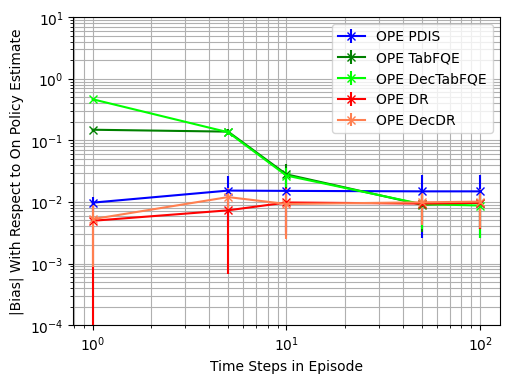

In [ ]:
biases_1 = {'On Policy': [0.0, 1.3170890159654386e-09, 0.0, 1.3170890159654386e-09, 0.0],
            'OPE IS': [0.006376000000000008, 0.014508289822810324, 0.009356046080236609, 0.03326994654355585, 0.16722294426518192],
            'OPE PDIS': [0.006376000000000008, 0.030981877121933215, 0.03233313927429774, 0.03234873296152588, 0.032348732599980806],
            'OPE TabFQE': [0.1516541494487697, 0.15146362298929697, 0.03683781289283483, 0.011839192312642518, 0.013337962622499904],
            'OPE DR': [0.0002625804779004126, 0.0028168023992353, 0.013496723215080872, 0.012064304157931145, 0.012160473020144282],
            'OPE DecTabFQE': [0.4669417022117239, 0.1502093439943435, 0.033672399683657164, 0.010734967675028947, 0.012088237852513032],
            'OPE DecDR': [0.0026243176650346174, 0.011384631154009867, 0.014389376234463265, 0.013002978010572638, 0.013764779534357143]}


biases_2 = {'On Policy': [0.0, 0.0, 0.0, 0.0, 1.3170890159654386e-09],
            'OPE IS': [0.007467999999999967, 0.00270728169483835, 0.01325967514979482, 0.10425128461395984, 0.016463860606307387],
            'OPE PDIS': [0.007467999999999967, 2.052321390869642e-06, 0.002212081116194569, 0.0021632720622446516, 0.0021632758514153307],
            'OPE TabFQE': [0.14448977541940516, 0.13816693588054765, 0.02242793921713066, 0.0034836051191381658, 0.004054876938398557],
            'OPE DR': [0.011608691672798675, 3.2356198759446876e-05, 8.811669768593652e-05, 0.002931422532693058, 0.0020179201794508217],
            'OPE DecTabFQE': [0.4621510053659575, 0.13342033742600778, 0.02219276862591842, 0.0013764757700146313, 0.001919123105280381],
            'OPE DecDR': [0.011750460951774974, 0.004952073340977716, 0.0009936167479666074, 0.002840133539088835, 0.002349293158492246]}


biases_3 = {'On Policy': [0.0, 0.0, 0.0, 2.2812650937430355e-09, 0.0],
            'OPE IS': [0.01222800000000028, 0.013759441210407767, 0.007958907594219048, 0.02791783173323361, 0.028434290967508078],
            'OPE PDIS': [0.01222800000000028, 0.00937371526610885, 0.004919876014749801, 0.0029275125169520725, 0.002927512888479343],
            'OPE TabFQE': [0.14366631804364252, 0.13574414926178083, 0.03452303163819489, 0.0012336890451787536, 0.0007879853213660827],
            'OPE DR': [0.01031794680729834, 0.003152116491801303, 0.0029373389099349723, 0.0037570572821711435, 0.00295871439010121],
            'OPE DecTabFQE': [0.460366003245216, 0.12706901381694324, 0.027411460968290457, 0.004129031268635075, 0.0009403047053736015],
            'OPE DecDR': [0.009040599145840812, 0.009304715118740618, 0.0011196181557995093, 0.0031178688268343833, 0.0025218241286983478]}

biases_4 = {'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0],
            'OPE IS': [0.012676000000000114, 0.0005073420308956123, 0.008225790135134052, 0.042780852029734306, 0.3760678080710525],
            'OPE PDIS': [0.012676000000000114, 0.02422962491608383, 0.025632107276037517, 0.02612777146578994, 0.026127777688196876],
            'OPE TabFQE': [0.15760219932703318, 0.15339749919737114, 0.04030657484779801, 0.016585755495641147, 0.015482952465876436],
            'OPE DR': [0.001300699979731248, 0.014098363016124289, 0.014631775126576641, 0.015080230337239254, 0.016482455550688932],
            'OPE DecTabFQE': [0.47049781506251587, 0.15183808224567077, 0.038296947226149965, 0.01609362389043506, 0.016014177218252032],
            'OPE DecDR': [0.0027487003219522628, 0.01565002743827483, 0.01607065448025273, 0.01615141090680084, 0.01691618771671152]}


biases_5 = {'On Policy': [0.0, 0.0, 9.313225746154785e-10, 0.0, 0.0],
            'OPE IS': [0.009924000000000047, 0.01803367104020975, 0.018495835529626067, 0.013581747952414656, 0.18618272131041763],
            'OPE PDIS': [0.009924000000000047, 0.011777294449054595, 0.010446670573537726, 0.010654277554466931, 0.010654278906681457],
            'OPE TabFQE': [0.14539544857840297, 0.11317673877888448, 0.006079136586367813, 0.011911864280609776, 0.015068866889025201],
            'OPE DR': [0.0012153230023891103, 0.01641391839224602, 0.01777815534175494, 0.013182289851031927, 0.01474948036851449],
            'OPE DecTabFQE': [0.4610652983048232, 0.11394157240293822, 0.012321831276524729, 0.013694827313889012, 0.012748425856813565],
            'OPE DecDR': [9.742785439359487e-05, 0.018607585549653107, 0.013696397621863608, 0.01411773107844843, 0.014992198215908126]}

biases = [biases_1, biases_2, biases_3, biases_4, biases_5]


plot_graphs(biases, 'bias', 10**(-4), 10**(1))

In [ ]:
def print_specific_mean_std(r_dict_list):
  r_1000 = np.zeros((5, 7))
  r_100000 = np.zeros((5, 7))

  for r in range(len(r_dict_list)):
    r_dict = r_dict_list[r]
    legends = list(r_dict.keys())
    for l in range(len(legends)):
      legend = legends[l]
      r_1000[r, l] = r_dict[legend][2]
      r_100000[r, l] = r_dict[legend][-1]

  print('10 STEPS')
  print(list(np.mean(r_1000, axis = 0)))
  print(list(np.std(r_1000, axis = 0)))
  print('\n1000 STEPS')
  print(list(np.mean(r_100000, axis = 0)))
  print(list(np.std(r_100000, axis = 0)))

print_specific_mean_std(biases)

10 STEPS
[6.585445079827192e-11, 0.0003489435321103368, 0.0004064998547361284, 0.03414886959949572, 0.03408293033251335, 0.0, 0.0]
[1.3170890159654387e-10, 0.0006978870642206736, 0.0008129997094722568, 0.06829773919899146, 0.0681658606650267, 0.0, 0.0]

1000 STEPS
[0.0, 0.12797153652234175, 0.0004468663209586441, 0.1209840854970308, 0.03637842564721932, 0.0, 0.0]
[0.0, 0.2559430730446835, 0.0008937326419172882, 0.24196817099406157, 0.07275685129443864, 0.0, 0.0]


#### Variance

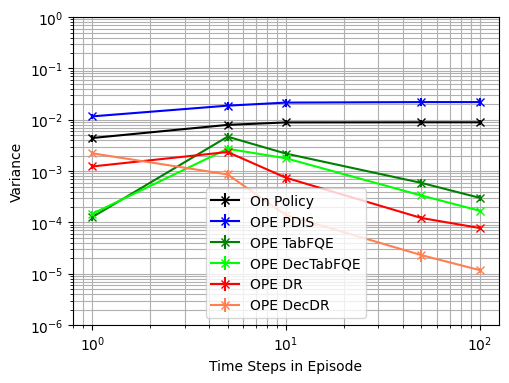

In [ ]:
vars1 = {'On Policy': [0.005159000000000002, 0.008610981504893601, 0.009064960595047293, 0.009130377409772827, 0.009130377462423855],
         'OPE IS': [0.011487412224000008, 0.012830181862581764, 0.017375561239734716, 0.3549157434435021, 3.507388810590439],
         'OPE PDIS': [0.011487412224000008, 0.025137346363528455, 0.028388108473430276, 0.028977936061495378, 0.028977935990965244],
         'OPE TabFQE': [0.00010426067512760395, 0.003966200950855089, 0.0022195160264254377, 0.0005399979474146205, 0.00035629530025277703],
         'OPE DR': [0.0012616246936303947, 0.0028387992477684914, 0.0006012429060262277, 0.00014335562604886248, 7.722053210332132e-05],
         'OPE DecTabFQE': [0.00016799147884360706, 0.003102002523932322, 0.0015963769234432048, 0.00029250871757317506, 0.00015690761367952665],
         'OPE DecDR': [0.00263367450910023, 0.0008079554138571188, 0.0001270011364178865, 1.999587809623748e-05, 1.1656438913832962e-05]}

vars2 = {'On Policy': [0.0035181100000000022, 0.008489071052674402, 0.0090963839995672, 0.009097505604163461, 0.009097505603918522],
         'OPE IS': [0.013228056576000015, 0.009104767088004758, 0.015205660084616443, 0.36320497169584465, 0.745919808807975],
         'OPE PDIS': [0.013228056576000015, 0.016511341623532374, 0.018546186919479877, 0.018498248873282334, 0.018498248952329224],
         'OPE TabFQE': [0.000127240047803112, 0.004556397774201587, 0.002421354475501874, 0.0007855127867901973, 0.00026703732893040947],
         'OPE DR': [0.0015090624786855255, 0.0023327720509027897, 0.0006282558722002378, 0.00011396121281888854, 9.030952552351092e-05],
         'OPE DecTabFQE': [0.00012604988319734294, 0.002504284697707576, 0.001595541580450622, 0.0003486112908001758, 0.00017223149276043194],
         'OPE DecDR': [0.002038965744728783, 0.0007495666049462331, 0.00010760439066630949, 1.875231032670384e-05, 1.032362038223769e-05]}

vars3 = {'On Policy': [0.004185390000000001, 0.008915739336017896, 0.010245322074490273, 0.010237450176769868, 0.010237450264883484],
         'OPE IS': [0.010510396416000014, 0.010493607358444772, 0.019594789499036574, 0.3961594670038992, 9.446052149780437],
         'OPE PDIS': [0.010510396416000014, 0.016150680801834634, 0.01927578711877815, 0.020088252446449992, 0.020088251124822445],
         'OPE TabFQE': [0.00015583100232252015, 0.00499163837805562, 0.002189015033260245, 0.0005640482784159184, 0.0003196972961053008],
         'OPE DR': [0.0011237080616219024, 0.0020128537256617414, 0.000689279682494166, 0.00012291629828958375, 7.230830661229038e-05],
         'OPE DecTabFQE': [0.00012261214075782662, 0.0026207313489207146, 0.0018077768447112958, 0.000315821005186146, 0.00017147327981021133],
         'OPE DecDR': [0.0020940847381686837, 0.0009858013887887411, 0.0001534343324121828, 1.6804281109142346e-05, 1.0906870664738332e-05]}

vars4 = {'On Policy': [0.0052449900000000015, 0.007126018427609096, 0.008402360061499973, 0.008531407746887232, 0.008531407654183722],
         'OPE IS': [0.01035637862400001, 0.009849731407899583, 0.01856327396806352, 0.41775181103618936, 0.8068259697036377],
         'OPE PDIS': [0.01035637862400001, 0.01741274943488931, 0.01883607097000258, 0.019253094072319444, 0.01925309403685115],
         'OPE TabFQE': [0.00010806268426464138, 0.0059891644347193984, 0.001747398043252992, 0.0005176807355237245, 0.00025329314479339004],
         'OPE DR': [0.0011831637488217033, 0.0023329124179071676, 0.001013330749208742, 0.00010871732327425556, 7.996356643490264e-05],
         'OPE DecTabFQE': [0.0001392024155756053, 0.0033216461967235313, 0.001959874021187579, 0.0003567175348120886, 0.0001693363665009809],
         'OPE DecDR': [0.001983029396553929, 0.0006097911222148997, 0.00017484361008901568, 3.402957323104314e-05, 1.3828211595171311e-05]}

vars5 = {'On Policy': [0.003977790000000002, 0.0066603922703571, 0.007611452167113622, 0.007669005551777309, 0.0076690055508137275],
         'OPE IS': [0.012698394624000004, 0.010096146042027822, 0.020316697601875697, 0.23476409481211763, 4.001409122434433],
         'OPE PDIS': [0.012698394624000004, 0.01906847128928285, 0.02305349301962118, 0.023766990305002126, 0.023766991115197995],
         'OPE TabFQE': [0.00013804588346217448, 0.0039303645284755094, 0.002401840745485213, 0.0005421453922442232, 0.00031403876683053987],
         'OPE DR': [0.0010831723797571989, 0.0022709131798008438, 0.000783851588150242, 0.00012204450198015983, 6.997670647663546e-05],
         'OPE DecTabFQE': [0.00018022000206709504, 0.0020621435555362084, 0.0019434526619222224, 0.0003625985670067931, 0.0001760591317984497],
         'OPE DecDR': [0.00236310088647638, 0.0011579714775033134, 0.00013312048606319848, 2.6016478864304644e-05, 1.2282770454211557e-05]}

vars = [vars1, vars2, vars3, vars4, vars5]

plot_graphs(vars, 'var', 10**(-6), 10**0)

In [ ]:
print_specific_mean_std(vars)

10 STEPS
[0.0001677946740973564, 0.00040765944315461955, 0.00044885334837717827, 0.0001926915824428623, 0.00024836025999558505, 0.0, 0.0]
[0.00033558934819471277, 0.0008153188863092391, 0.0008977066967543565, 0.00038538316488572464, 0.0004967205199911702, 0.0, 0.0]

1000 STEPS
[0.00016835009271367896, 8.328355140148818e-12, 0.0004627501815233502, 0.0038649510479346976, 0.0002519773806812488, 0.0, 0.0]
[0.00033670018542735793, 1.6656710280297632e-11, 0.0009255003630467006, 0.007729902095869394, 0.0005039547613624975, 0.0, 0.0]


#### MSE

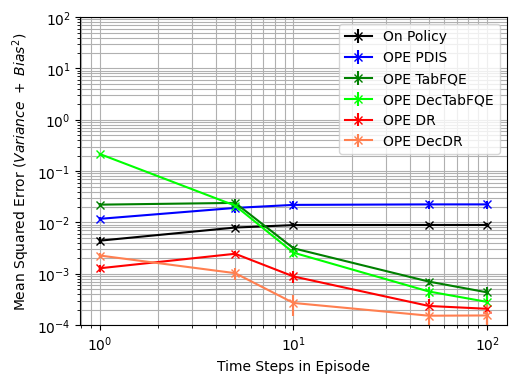

In [ ]:
MSEs1 = {'On Policy': [0.0051589999999999995, 0.008610981504893603, 0.009064960595047293, 0.009130377409772829, 0.009130377462423851],
         'OPE IS': [0.011528065600000009, 0.013040672336164426, 0.017463096837990227, 0.35602263278651314, 3.535352323679155],
         'OPE PDIS': [0.011528065600000009, 0.026097223073527024, 0.02943354036876141, 0.030024376585711488, 0.030024376491790305],
         'OPE TabFQE': [0.023103241720157378, 0.02690743003989898, 0.003576540485152946, 0.0006801644220303542, 0.0005341965471719816],
         'OPE DR': [0.001261693642137769, 0.002846733623524829, 0.0007834044435707306, 0.0002889030608639372, 0.00022509763617697831],
         'OPE DecTabFQE': [0.21820254474322584, 0.025664849547143338, 0.00273020742389916, 0.00040774824855709145, 0.00030303310805845555],
         'OPE DecDR': [0.002640561552307243, 0.0009375652403699708, 0.0003340552848348227, 0.00018907331523967307, 0.00020112559454329022]}

MSEs2 = {'On Policy': [0.0035181100000000022, 0.008489071052674399, 0.009096383999567196, 0.00909750560416346, 0.009097505603918523],
         'OPE IS': [0.013283827600000015, 0.009112096462179965, 0.01538147906969453, 0.3740733020395055, 0.746190867514039],
         'OPE PDIS': [0.013283827600000015, 0.016511341627744397, 0.0185510802223445, 0.018502928619297622, 0.01850292871473854],
         'OPE TabFQE': [0.021004535248553252, 0.02364649994482095, 0.0029243669330291816, 0.0007976482914162829, 0.0002834793559159659],
         'OPE DR': [0.0016438242010396308, 0.002332773097826388, 0.0006282636367526489, 0.00012255445088406913, 9.438152737414575e-05],
         'OPE DecTabFQE': [0.21370960164396263, 0.02030527113657735, 0.002088060559734171, 0.00035050597634561317, 0.00017591452625365296],
         'OPE DecDR': [0.0021770390773079716, 0.0007740896353206553, 0.00010859166490814923, 2.6818668846561113e-05, 1.5842798726776164e-05]}

MSEs3 = {'On Policy': [0.004185390000000001, 0.008915739336017896, 0.010245322074490273, 0.010237450176769873, 0.010237450264883484],
         'OPE IS': [0.01065992040000002, 0.01068292958086744, 0.01965813370912989, 0.39693887233258435, 9.446860658683262],
         'OPE PDIS': [0.01065992040000002, 0.016238547339724716, 0.01929999229877866, 0.020096822775986904, 0.020096821456534658],
         'OPE TabFQE': [0.020795841942539566, 0.023418112436860254, 0.0033808547467520504, 0.0005655702670761125, 0.0003203182169719892],
         'OPE DR': [0.0012301680879401404, 0.002022789564039627, 0.000697907642365984, 0.00013703177771109897, 8.106229745448235e-05],
         'OPE DecTabFQE': [0.21205946908473203, 0.018767265621331228, 0.002559165037127407, 0.00033286990440351216, 0.00017235745274915906],
         'OPE DecDR': [0.0021758171710844613, 0.0010723791122296614, 0.0001546878772269787, 2.652538713048796e-05, 1.7266467600823513e-05]}

MSEs4 = {'On Policy': [0.005244990000000002, 0.007126018427609095, 0.008402360061499973, 0.008531407746887232, 0.008531407654183724],
         'OPE IS': [0.010517059600000014, 0.009849988803835896, 0.01863093759141079, 0.4195820123365794, 0.9482529659710037],
         'OPE PDIS': [0.010517059600000014, 0.01799982415846342, 0.019493075893412877, 0.01993575451408799, 0.019935754803774988],
         'OPE TabFQE': [0.02494651591698254, 0.029519957194726876, 0.003372018019214135, 0.000792768020884915, 0.0004930149618539792],
         'OPE DR': [0.0011848555692589762, 0.0025316762576415887, 0.0012274195925634488, 0.0003361306702984467, 0.00035163490741533897],
         'OPE DecTabFQE': [0.22150739639417696, 0.026376449416766617, 0.003426530188030094, 0.0006157222647388708, 0.00042579023847856334],
         'OPE DecDR': [0.0019905847500138294, 0.0008547144810336548, 0.0004331095455126828, 0.00029489764751136833, 0.000299985618462193]}

MSEs5 = {'On Policy': [0.003977790000000002, 0.006660392270357098, 0.007611452167113623, 0.007669005551777306, 0.007669005550813727],
         'OPE IS': [0.012796880400000005, 0.010421359333214322, 0.020658793533814675, 0.23494855868956055, 4.036073128148986],
         'OPE PDIS': [0.012796880400000005, 0.019207175953822583, 0.0231626259456932, 0.023880503935209744, 0.023880504774219352],
         'OPE TabFQE': [0.0212778823507772, 0.016739338729099364, 0.002438796647120929, 0.0006840379028838902, 0.0005411095161496999],
         'OPE DR': [0.001084649389757335, 0.002540329896788156, 0.0010999143955058117, 0.00029581726769677916, 0.0002875238776178298],
         'OPE DecTabFQE': [0.2127614293029827, 0.015044825477190221, 0.0020952801879293654, 0.0005501468621640336, 0.0003385814936251224],
         'OPE DecDR': [0.002363110378663192, 0.0015042137174909726, 0.0003207117938793896, 0.0002253268096676933, 0.0002370487777992904]}

MSEs = [MSEs1, MSEs2, MSEs3, MSEs4, MSEs5]

plot_graphs(MSEs, 'MSE', 10**(-4), 10**2)

In [ ]:
print_specific_mean_std(MSEs)

10 STEPS
[0.0001677946740973564, 0.00040826825109762776, 0.0004496795590366807, 0.006023418057059679, 0.006056590960250377, 0.0, 0.0]
[0.00033558934819471277, 0.0008165365021952555, 0.0008993591180733614, 0.012046836114119358, 0.012113181920500754, 0.0, 0.0]

1000 STEPS
[0.00016835009271367896, 0.0818835708077736, 0.0004637486290673858, 0.07705069576569898, 0.006868926643532572, 0.0, 0.0]
[0.00033670018542735793, 0.1637671416155472, 0.0009274972581347716, 0.15410139153139796, 0.013737853287065142, 0.0, 0.0]


#### ESS

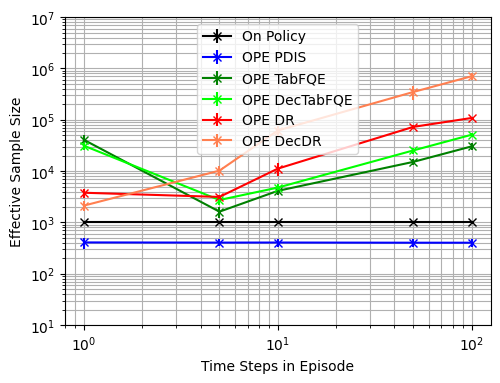

In [ ]:
vars1 = {'On Policy': [0.005159000000000002, 0.008610981504893601, 0.009064960595047293, 0.009130377409772827, 0.009130377462423855],
         'OPE IS': [0.011487412224000008, 0.012830181862581764, 0.017375561239734716, 0.3549157434435021, 3.507388810590439],
         'OPE PDIS': [0.011487412224000008, 0.025137346363528455, 0.028388108473430276, 0.028977936061495378, 0.028977935990965244],
         'OPE TabFQE': [0.00010426067512760395, 0.003966200950855089, 0.0022195160264254377, 0.0005399979474146205, 0.00035629530025277703],
         'OPE DR': [0.0012616246936303947, 0.0028387992477684914, 0.0006012429060262277, 0.00014335562604886248, 7.722053210332132e-05],
         'OPE DecTabFQE': [0.00016799147884360706, 0.003102002523932322, 0.0015963769234432048, 0.00029250871757317506, 0.00015690761367952665],
         'OPE DecDR': [0.00263367450910023, 0.0008079554138571188, 0.0001270011364178865, 1.999587809623748e-05, 1.1656438913832962e-05]}

ESS1 = calculate_ESS(vars1, 1000)


vars2 = {'On Policy': [0.0035181100000000022, 0.008489071052674402, 0.0090963839995672, 0.009097505604163461, 0.009097505603918522],
         'OPE IS': [0.013228056576000015, 0.009104767088004758, 0.015205660084616443, 0.36320497169584465, 0.745919808807975],
         'OPE PDIS': [0.013228056576000015, 0.016511341623532374, 0.018546186919479877, 0.018498248873282334, 0.018498248952329224],
         'OPE TabFQE': [0.000127240047803112, 0.004556397774201587, 0.002421354475501874, 0.0007855127867901973, 0.00026703732893040947],
         'OPE DR': [0.0015090624786855255, 0.0023327720509027897, 0.0006282558722002378, 0.00011396121281888854, 9.030952552351092e-05],
         'OPE DecTabFQE': [0.00012604988319734294, 0.002504284697707576, 0.001595541580450622, 0.0003486112908001758, 0.00017223149276043194],
         'OPE DecDR': [0.002038965744728783, 0.0007495666049462331, 0.00010760439066630949, 1.875231032670384e-05, 1.032362038223769e-05]}

ESS2 = calculate_ESS(vars2, 1000)

vars3 = {'On Policy': [0.0052449900000000015, 0.007126018427609096, 0.008402360061499973, 0.008531407746887232, 0.008531407654183722],
         'OPE IS': [0.01035637862400001, 0.009849731407899583, 0.01856327396806352, 0.41775181103618936, 0.8068259697036377],
         'OPE PDIS': [0.01035637862400001, 0.01741274943488931, 0.01883607097000258, 0.019253094072319444, 0.01925309403685115],
         'OPE TabFQE': [0.00010806268426464138, 0.0059891644347193984, 0.001747398043252992, 0.0005176807355237245, 0.00025329314479339004],
         'OPE DR': [0.0011831637488217033, 0.0023329124179071676, 0.001013330749208742, 0.00010871732327425556, 7.996356643490264e-05],
         'OPE DecTabFQE': [0.0001392024155756053, 0.0033216461967235313, 0.001959874021187579, 0.0003567175348120886, 0.0001693363665009809],
         'OPE DecDR': [0.001983029396553929, 0.0006097911222148997, 0.00017484361008901568, 3.402957323104314e-05, 1.3828211595171311e-05]}

ESS3 = calculate_ESS(vars3, 1000)

vars4 = {'On Policy': [0.0052449900000000015, 0.007126018427609096, 0.008402360061499973, 0.008531407746887232, 0.008531407654183722],
         'OPE IS': [0.01035637862400001, 0.009849731407899583, 0.01856327396806352, 0.41775181103618936, 0.8068259697036377],
         'OPE PDIS': [0.01035637862400001, 0.01741274943488931, 0.01883607097000258, 0.019253094072319444, 0.01925309403685115],
         'OPE TabFQE': [0.00010806268426464138, 0.0059891644347193984, 0.001747398043252992, 0.0005176807355237245, 0.00025329314479339004],
         'OPE DR': [0.0011831637488217033, 0.0023329124179071676, 0.001013330749208742, 0.00010871732327425556, 7.996356643490264e-05],
         'OPE DecTabFQE': [0.0001392024155756053, 0.0033216461967235313, 0.001959874021187579, 0.0003567175348120886, 0.0001693363665009809],
         'OPE DecDR': [0.001983029396553929, 0.0006097911222148997, 0.00017484361008901568, 3.402957323104314e-05, 1.3828211595171311e-05]}

ESS4 = calculate_ESS(vars4, 1000)

vars5 = {'On Policy': [0.003977790000000002, 0.0066603922703571, 0.007611452167113622, 0.007669005551777309, 0.0076690055508137275],
         'OPE IS': [0.012698394624000004, 0.010096146042027822, 0.020316697601875697, 0.23476409481211763, 4.001409122434433],
         'OPE PDIS': [0.012698394624000004, 0.01906847128928285, 0.02305349301962118, 0.023766990305002126, 0.023766991115197995],
         'OPE TabFQE': [0.00013804588346217448, 0.0039303645284755094, 0.002401840745485213, 0.0005421453922442232, 0.00031403876683053987],
         'OPE DR': [0.0010831723797571989, 0.0022709131798008438, 0.000783851588150242, 0.00012204450198015983, 6.997670647663546e-05],
         'OPE DecTabFQE': [0.00018022000206709504, 0.0020621435555362084, 0.0019434526619222224, 0.0003625985670067931, 0.0001760591317984497],
         'OPE DecDR': [0.00236310088647638, 0.0011579714775033134, 0.00013312048606319848, 2.6016478864304644e-05, 1.2282770454211557e-05]}

ESS5 = calculate_ESS(vars5, 1000)

ESS = [ESS1, ESS2, ESS3, ESS4, ESS5]

plot_graphs(ESS, 'ESS', 10**(1), 10**7)

In [ ]:
print_specific_mean_std(ESS)